In [1]:
import pickle 
def pickle_var(variable, name):
    
    file = open(f'/local/scratch/azure-investigation-results/{name}', 'wb')
    pickle.dump(variable,file)
    file.close()
    
def from_pickle_var(name):
    
    file = open(f'/local/scratch/azure-investigation-results/{name}', 'rb')
    data = pickle.load(file)
    file.close()
    return data


In [2]:
import os
os.system("/home/aati2/benchmarking/experiments.py")

32256

In [ ]:
labels = [
    
    "caelum-301",
    
    "caelum-405",
    "caelum-406",
    "caelum-407",    

    "caelum-605",
    "caelum-606",
    "caelum-607",
    "caelum-609",
    "caelum-610",
    "caelum-611",
    "caelum-612",
    "caelum-614",
    "caelum-106",
    "caelum-107",
    "caelum-108",
    "caelum-203",
    "caelum-206",
    "caelum-207",
    "caelum-209",
    "caelum-313",
    "caelum-314",    
]

backends = [
    "192.168.14.100:5000",

    "192.168.14.12:5000",
    "192.168.14.2:5000",
    "192.168.14.10:5000",
    
'192.168.14.13:5000', #605
'192.168.14.14:5000', #606
'192.168.14.15:5000', #607
'192.168.14.16:5000', #609

'192.168.14.17:5000', #610 to be reported
'192.168.14.18:5000', #611 to be reported
'192.168.14.19:5000', #612 to be reported
'192.168.14.20:5000', #614  to be reported
    
'192.168.14.21:5000', #106
'192.168.14.22:5000', #107
'192.168.14.23:5000', #108
'192.168.14.24:5000', #203
'192.168.14.25:5000', #206
'192.168.14.26:5000', #207
'192.168.14.27:5000', #209
# '192.168.14.28:5000', #310 to be reported as well!
'192.168.14.29:5000', #313
'192.168.14.30:5000', #314   
]

for index,backend in enumerate(backends):
    print(index,labels[index], (requests.get(f"http://{backend}/pod_status").text))    

In [995]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import json
from matplotlib.pyplot import text

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import time
import subprocess
import os
import signal

import binpacking
import random
import re


def set_cfs(backend):
    params = { 'script': 'setup_patch_clean_baseline.sh', 'ema':'1000' }
    r = requests.get(f"http://{backend}/setup_patch", params=params, headers={})
    print(r.text)   
    
def set_cfs_all():
    for backend in backends:
        print(backend)
        set_cfs(backend)
        
def set_llf(backend):
    params = { 'script': 'setup_patch_clean.sh', 'ema':'1000' }
    r = requests.get(f"http://{backend}/setup_patch", params=params, headers={})
    print(r.text)   

def set_llf_all():
    for backend in backends:
        print(backend)
        set_llf(backend)
        
        
def set_static(backend, offset):
    params = { 'script': 'setup_patch_clean_static.sh', 'ema':'1000', 'offset':10 }
    r = requests.get(f"http://{backend}/setup_patch", params=params, headers={})
    print(r.text)   

def set_static_all(offset=10):
    for backend in backends:
        print(backend)
        set_static(backend,offset)

def experiment_kickoff(trace_path, replica_count=10,threads=1000,funcs_offset=0,funcs_count=600):
    
    for replica_id in range(replica_count):

        cmd = f"'~/benchmarking/venv/bin/python ~/benchmarking/workload_generator.py --trace_path={trace_path} --offset={funcs_offset:03d} --funcs={funcs_count} --barrier=30 --threads={threads} --replica_count={replica_count} --replica_id={replica_id}'"
        print(cmd)

        !tmux new-session -d {cmd}

    start = time.time()
    
    print("kickedoff completed at ", start)
    return start

def experiment_results(funcs_count=600,replica_count=10):

    dumps = []

    for index,backend in enumerate(backends):

        lines = ((requests.get(f"http://{backend}/metrics_dump").text)).split("\n")
        dumps.append(lines)
        
    dumps_schedstat = []

    for index,backend in enumerate(backends):

        lines = ((requests.get(f"http://{backend}/metrics_dump_schedstat").text)).split("\n")
        dumps_schedstat.append(lines)        
        
    dfs = []

    for index in range(funcs_count):

        for r in range(replica_count):

            df = pd.read_csv(f'~/latencies-pytorch-classifier-{index:03d}.default.example.com-replica-{r}',header=None,names=['ts','duration','status_code'])
            df['ts'] = df['ts'].astype(float)
            df['timestamp'] = df['ts']
            df['duration'] = df['duration'].astype(float)   

            dfs.append(df)

    dfall = pd.concat(dfs)
    
    return dumps,dumps_schedstat, dfs


def experiment_sleep(epochs=6,funcs_count=600,replica_count=10):

    for i in range(epochs):
        print("epoch",i)
#         for index,backend in enumerate(backends):
#             print(index,labels[index], (requests.get(f"http://{backend}/pod_status").text))    
        time.sleep(100)
        dfs = []

        for index in range(funcs_count):

            for r in range(replica_count):

                df = pd.read_csv(f'~/latencies-pytorch-classifier-{index:03d}.default.example.com-replica-{r}',header=None,names=['ts','duration','status_code'])
                df['ts'] = df['ts'].astype(float)
                df['timestamp'] = df['ts']
                df['duration'] = df['duration'].astype(float)   

                dfs.append(df)   
                
#         df = pd.concat(dfs_profile_static)
#         df['ts_abs'] = df['ts'] - df['ts'].min()
#         df1 = df[df['status_code'] == 200]
#         df1['duration'].hist(cumulative=True, density=1, bins=10000,histtype='step',label='200')

        df = pd.concat(dfs)
        df['ts_abs'] = df['ts'] - df['ts'].min()
        df1 = df[df['status_code'] == 200]
        df1['duration'].hist(cumulative=True, density=1, bins=10000,histtype='step',label='200')
        display(df['status_code'].value_counts()) 
        plt.xscale('log')

        plt.show()

    !sudo killall python
    end = time.time()
    return end    

def experiment_reset():
    !sudo killall python
    !rm /home/aati2/latencies-pytorch-classifier-*

    for index,backend in enumerate(backends):
        print(index,labels[index], (requests.get(f"http://{backend}/metrics_dump_reset").text))    

    !kubectl get pods  | wc -l        

def process_node_dump(dump):
    
    udfs = []

    for line in dump[:-1]:
        udfs.append(pd.DataFrame(json.loads(line)))

    if (len(udfs) == 0):
        return pd.DataFrame(),pd.DataFrame()
        
    df = pd.concat(udfs)
#     display(df)
    
    if (df.shape == (0,0)):
        return df,df
    
    funcs = df['ksvc'].unique()
    
    metrics_usage = []
    metrics_contention = []

    for func in funcs:
        dffunc = df[df['ksvc'] == func]
        dffunc_past = dffunc.shift(1)

        dfusage = pd.DataFrame()
        dfusage['ts'] = dffunc['timestamp']
        dfusage[func] = dffunc[['usage']] - dffunc_past[['usage']]
        dfusage.set_index('ts')
        
        dfcontention = pd.DataFrame()
        dfcontention['ts'] = dffunc['timestamp']
        dfcontention[func] = dffunc[['wait_sum']] - dffunc_past[['wait_sum']]
        dfcontention.set_index('ts')
        
        metrics_usage.append(dfusage.set_index('ts'))
        metrics_contention.append(dfcontention.set_index('ts'))

    return pd.concat(metrics_usage,axis=1),pd.concat(metrics_contention,axis=1)

def process_results(dumps):

    usage_cluster = []
    contention_cluster = []
    for index, dump in enumerate(dumps):
        print(f"processing dump #{index}")
        dfusage,dfcontention = process_node_dump(dump)
        usage_cluster.append(dfusage)
        contention_cluster.append(dfcontention)
        
    min_ts = min(pd.concat(usage_cluster).index)
    return usage_cluster, contention_cluster

def plot_cluster_contention(contention_cluster):

    min_ts = min(pd.concat(contention_cluster).index)
    print(min_ts)

    for index,dfusage in enumerate(contention_cluster):
    #     display(dfusage)
        if dfusage.shape != (0,0):

            dfusage['abs_ts'] = dfusage.index - min_ts
            dfusage = dfusage.set_index('abs_ts')

            ((dfusage.sum(axis=1))/1000000).rolling(5).mean().plot(figsize=(30,5),legend=True,ylim=(0,10000),label=index)
            plt.axhline(y=2000)
            plt.show()
            
def compare_cluster_contention(contention_cluster,contention_cluster_llf):

    min_ts = min(pd.concat(contention_cluster).index)
    min_ts2 = min(pd.concat(contention_cluster_llf).index)

    print(min_ts)

    for index,df in enumerate(contention_cluster):
    #     display(dfusage)
        if df.shape != (0,0):

            df['abs_ts'] = df.index - min_ts
            df = df.set_index('abs_ts')

            ((df.sum(axis=1))/1000000).rolling(5).mean().plot(figsize=(30,5),legend=True,ylim=(0,10000),label=index)
            plt.axhline(y=2000)
                        
            df2 = contention_cluster_llf[index]
            
            df2['abs_ts'] = df2.index - min_ts2
            df2 = df2.set_index('abs_ts')

            ((df2.sum(axis=1))/1000000).rolling(5).mean().plot(figsize=(30,5),legend=True,ylim=(0,10000),label=f"{index}-llf")
            plt.axhline(y=2000)            
            
            plt.show()            
            
def plot_cluster_usage(usage_cluster):
    
    min_ts = min(pd.concat(usage_cluster).index)

    print(min_ts)
    
    utils = []
    for index,dfusage in enumerate(usage_cluster):
    #     display(dfusage)
        if dfusage.shape != (0,0):

            dfusage['abs_ts'] = dfusage.index - min_ts
            dfusage = dfusage.set_index('abs_ts')
            dfutil = dfusage.sum(axis=1)/12000000000

            dfutil = dfutil[dfutil>0]

            print(index,dfutil.mean()*100)
            utils.append(dfutil.mean()*100)
            if (dfutil.mean()*100) > 5:

                (dfutil).plot(figsize=(30,5),legend=True,ylim=(0,1.1),label=index)
                plt.show()      
    print("average node utilisation", sum(utils)/len(utils))
    
def compare_clusters(cluster_usage1,cluster_usage2, cluster_contention1,cluster_contention2):

    min_ts = min(pd.concat(cluster_contention1).index)
    min_ts2 = min(pd.concat(cluster_contention2).index)
    
    min_ts_usage1 = min(pd.concat(cluster_usage1).index)
    min_ts_usage2 = min(pd.concat(cluster_usage2).index)
    
    utils1 = []
    utils2 = []
    
    print(min_ts)

    for index,df in enumerate(cluster_contention1):
    #     display(dfusage)
        if df.shape != (0,0):
            
            fig, (ax1, ax2) = plt.subplots(1, 2)
            
            #contention
            ax2.set_title(f'Contention {labels[index]}')
            df['abs_ts'] = df.index - min_ts
            df = df.set_index('abs_ts')
            ((df.sum(axis=1))/1000000).rolling(5).mean().plot(figsize=(30,5),legend=True,label=index,ax=ax2)
            
            df2 = cluster_contention2[index]
            df2['abs_ts'] = df2.index - min_ts2
            df2 = df2.set_index('abs_ts')
            ((df2.sum(axis=1))/1000000).rolling(5).mean().plot(figsize=(30,5),legend=True,label=f"{index}-llf",ax=ax2)
            
            #usage

            dfusage = cluster_usage1[index]
            dfusage['abs_ts'] = dfusage.index - min_ts_usage1
            dfusage = dfusage.set_index('abs_ts')
            dfutil = dfusage.sum(axis=1)/12000000000

            dfutil = dfutil[dfutil>0]

            print(index,dfutil.mean()*100)
            (dfutil).plot(figsize=(30,5),legend=True,ylim=(0,1.1),label=index,ax=ax1)
            
            utils1.append(dfutil.mean()*100)
            
            
            dfusage = cluster_usage2[index]
            dfusage['abs_ts'] = dfusage.index - min_ts_usage2
            dfusage = dfusage.set_index('abs_ts')
            dfutil = dfusage.sum(axis=1)/12000000000

            dfutil = dfutil[dfutil>0]

            print(index,dfutil.mean()*100)
            (dfutil).plot(figsize=(30,5),legend=True,ylim=(0,1.1),label=index,ax=ax1) 
            
            utils2.append(dfutil.mean()*100)
            
            
            plt.show()    
            
    print(sum(utils1)/len(utils1),sum(utils2)/len(utils2))


def get_default_share(nodes, funcs=600):
    
#     nodes = 17
    cushion = 7

    proxy = 25
    share = int(((nodes * 11800) / funcs) - proxy -cushion)
    admitted = min(int(11800 / (share+proxy)),110) *nodes
    return share,admitted


def visualise_cluster(dump_schedstat,usage_cluster,contention_cluster):

    dfs = []

    for index, dump in enumerate(dump_schedstat):    

        rows = []

        for line in dump[:-1]:

            data = json.loads(line)
            cpustats = (data['schedstat'])
            ts = (data['timestamp'])

            usage_per_cpu = [int(cpustat.split(' ')[7]) for cpustat in cpustats]
            wait_per_cpu = [int(cpustat.split(' ')[8]) for cpustat in cpustats]

            row = [ts] +usage_per_cpu+ wait_per_cpu


            rows.append(row)

        columns = ['ts'] + [f'usage-cpu{x}' for x in range(12)] + [f'wait-cpu{x}' for x in range(12)]
        df = pd.DataFrame(rows,columns=columns)    

        df = df.set_index('ts')
        dfdiff = df - df.shift(1)

        dfdiff['node_usage'] = dfdiff[[f'usage-cpu{x}' for x in range(12)]].sum(axis=1)/12000000000
        dfdiff['node_wait'] = dfdiff[[f'wait-cpu{x}' for x in range(12)]].sum(axis=1)/1000000


        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        dfdiff['node_usage'].plot(figsize=(30,5),ax=ax1,ylim=(0,1.1),title=f"node-usage-{labels[index]}")

        (usage_cluster[index].sum(axis=1)/12000000000).plot(ax=ax1)

#         dfcontention = dfdiff['node_wait']
#         dfcontention = dfcontention[dfcontention>0]
#         dfcontention.plot(figsize=(30,5),ax=ax3,title=f"node-contention-{labels[index]}",logy=False)
        ax3.axhline(y=2000,color='red')

        df = (contention_cluster[index].sum(axis=1)/1000000)
        df = df[df>=0]
        df.plot(ax=ax3)


        if(usage_cluster[index].shape != (0,0)):

            dfusage = (usage_cluster[index]/12000000000) #.drop('ts_abs',axis=1)
            dfusage = dfusage[dfusage>=0]
            
            if (dfusage.shape != (0,0)):
                dfusage.plot.area(ax=ax2,legend=False,ylim=(0,1.1))

            plt.show()
            print(labels[index], dfusage.sum(axis=1).mean())
            print(sorted([int(re.findall("pytorch-classifier-(\d+).*",col)[0]) for col in dfusage.columns]))


# visualise_cluster(dump_profile_static_schedstat,usage_cluster_profile_static,contention_cluster_profile_static)          

def compare_clusters(dump_schedstat1,dump_schedstat12,control_nodes=10):

    dfs = []
    
    dfs1 = []
    dfs2 = []

    for index, dump in enumerate(dump_schedstat1):    

        fig, (ax1, ax2) = plt.subplots(1, 2)
        
        rows = []        
        for line in dump[:-1]:

            data = json.loads(line)
            cpustats = (data['schedstat'])
            ts = (data['timestamp'])

            usage_per_cpu = [int(cpustat.split(' ')[7]) for cpustat in cpustats]
            wait_per_cpu = [int(cpustat.split(' ')[8]) for cpustat in cpustats]

            row = [ts] +usage_per_cpu+ wait_per_cpu
            rows.append(row)

        columns = ['ts'] + [f'usage-cpu{x}' for x in range(12)] + [f'wait-cpu{x}' for x in range(12)]
        df = pd.DataFrame(rows[:],columns=columns)    
#         display(df)
        

        df = df.set_index('ts')
        dfdiff = df - df.shift(1)
        dfdiff = dfdiff.reset_index().drop('ts',axis=1)

        
        dfdiff['node_usage'] = dfdiff[[f'usage-cpu{x}' for x in range(12)]].sum(axis=1)/12000000000
        dfdiff['node_wait'] = dfdiff[[f'wait-cpu{x}' for x in range(12)]].sum(axis=1)/12000000000
        
        
        dfs1.append(dfdiff)
        

        dfdiff['node_usage'].rolling(1).mean().plot(figsize=(30,5),ax=ax1,ylim=(0,1.1),title=f"node-usage-{labels[index]}",color='orange')
        
        print("usage before", dfdiff['node_usage'].mean(), "contention before", dfdiff['node_wait'].mean())
        
        

        dfcontention = dfdiff['node_wait']
        dfcontention = dfcontention[dfcontention>0]
        

        dfcontention.rolling(1).mean().plot(figsize=(30,5),ax=ax2,title=f"node-contention-{labels[index]}",color='orange')
            

        dump = dump_schedstat12[index]
        rows = []
        for line in dump[:-1]:

            data = json.loads(line)
            cpustats = (data['schedstat'])
            ts = (data['timestamp'])

            usage_per_cpu = [int(cpustat.split(' ')[7]) for cpustat in cpustats]
            wait_per_cpu = [int(cpustat.split(' ')[8]) for cpustat in cpustats]

            row = [ts] +usage_per_cpu+ wait_per_cpu
            rows.append(row)

        columns = ['ts'] + [f'usage-cpu{x}' for x in range(12)] + [f'wait-cpu{x}' for x in range(12)]
        df = pd.DataFrame(rows[:],columns=columns)  
#         display(df)

        df = df.set_index('ts')
    
        dfdiff = df - df.shift(1)
        dfdiff = dfdiff.reset_index().drop('ts',axis=1)

        dfdiff['node_usage'] = dfdiff[[f'usage-cpu{x}' for x in range(12)]].sum(axis=1)/12000000000
        dfdiff['node_wait'] = dfdiff[[f'wait-cpu{x}' for x in range(12)]].sum(axis=1)/12000000000
        dfs2.append(dfdiff)

        
        dfdiff['node_usage'].rolling(1).mean().plot(figsize=(30,5),ax=ax1,ylim=(0,1.1),title=f"node-usage-{labels[index]}",color='green')
        print("usage after", dfdiff['node_usage'].mean(), "contention after", dfdiff['node_wait'].mean())
        
        dfcontention = dfdiff['node_wait']
        dfcontention = dfcontention[dfcontention>0]
        
        dfcontention.rolling(1).mean().plot(figsize=(30,5),ax=ax2,title=f"node-contention-{labels[index]}",color='green')
            
        
        plt.show()
        
    return dfs1,dfs2
        
        
# compare_clusters(dump_profile_schedstat,dump_profile_static_schedstat)


def plot_latency_cdf(dfs_baseline, dfs_before,dfs_after,density=1):

    df = pd.concat(dfs_baseline)
    display(df['status_code'].value_counts())    
    df['ts_abs'] = df['ts'] - df['ts'].min()
    df = df[df['status_code'] == 200]
    # df1 = df[df['duration'] < 3000]
    df['duration'].hist(cumulative=True, density=density, bins=10000,histtype='step',label='no-oc')

    df1 = pd.concat(dfs_before)
    display(df1['status_code'].value_counts())
    df1['ts_abs'] = df1['ts'] - df1['ts'].min()
    df1 = df1[df1['status_code'] == 200]
    # df1 = df[df['duration'] < 3000]
    df1['duration'].hist(cumulative=True, density=density, bins=10000,histtype='step',label='oc-cfs')

    df2 = pd.concat(dfs_after)
    display(df2['status_code'].value_counts())    
    df2['ts_abs'] = df2['ts'] - df2['ts'].min()
    df2 = df2[df2['status_code'] == 200]
    # df1 = df[df['duration'] < 3000]
    df2['duration'].hist(cumulative=True, density=density, bins=10000,histtype='step',label='oc-llf')

    plt.xscale('log')
    plt.legend(loc='upper left')
    
    
    print("1sec target",1-(df1[df1<1000].count()['duration']/df[df<1000].count()['duration']),1-(df2[df2<1000].count()['duration']/df[df<1000].count()['duration']))

def resize_cluster(control_nodes=6, data_nodes=6):

    print(f'setting up control plane with {control_nodes} nodes')

    for index, node in enumerate(labels[1:1+control_nodes]):
        output = !kubectl cordon {node} 
        print(index+1,output)       
        
    print(f'setting up data plane with {data_nodes} nodes')

    for index, node in enumerate(labels[1+control_nodes:]):
        if (index < data_nodes):
            output = !kubectl uncordon {node} 
            print(index+1,output)
        else:
            !kubectl cordon {node}     

def wait_until_zero(pods_count=0):
    count = -1
    while count !=pods_count:
        print(count)
        count = !kubectl get pods | grep Running | wc -l
        count = int(count[-1])
        time.sleep(10)

    !kubectl get pods | grep Running | wc -l

    for index,backend in enumerate(backends):
        print(index,labels[index], (requests.get(f"http://{backend}/pod_status").text))  


def compare_cdf_cluster_contention(contention_cluster, contention_cluster1, contention_cluster2):

	contentions = []
	for node_contention in contention_cluster:
	    if node_contention.shape != (0,0):
	        df = (node_contention.sum(axis=1))
	        df = df[df>0]        
	        contentions.append(df)
            
	contentions1 = []
	for node_contention in contention_cluster1:
	    if node_contention.shape != (0,0):
	        df = (node_contention.sum(axis=1))
	        df = df[df>0]        
	        contentions1.append(df)
	        
	contentions2 = []
	for node_contention in contention_cluster2:
	    if node_contention.shape != (0,0):
	        df = (node_contention.sum(axis=1))
	        df = df[df>0]        
	        contentions2.append(df)  
	noramlisation = (pd.concat(contentions1)).max()
            
	(pd.concat(contentions)/noramlisation).hist(cumulative=True, density=1, bins=10000,histtype='step',label='no-oc')
	(pd.concat(contentions1)/noramlisation).hist(cumulative=True, density=1, bins=10000,histtype='step',label='oc-cfs')
	(pd.concat(contentions2)/noramlisation).hist(cumulative=True, density=1, bins=10000,histtype='step',label='oc-llf')
# 	plt.xscale('log')  
# 	plt.xlim(-0.2,4)

	mean = pd.concat(contentions1).mean()/12000000
	peak = pd.concat(contentions1).quantile(0.99)/12000000
    
	mean_llf = pd.concat(contentions2).mean()/12000000
	peak_llf = pd.concat(contentions2).quantile(0.99)/12000000
    
	print("mean",mean, mean_llf, (mean - mean_llf) / mean)
	print("peak",peak, peak_llf, (peak - peak_llf) / peak)
	plt.legend()
    
    

def compare_cdf_cluster_usage(usage_cluster, usage_cluster1, usage_cluster2):
	usages = []
	for usage in usage_cluster:
	    if usage.shape != (0,0):
	        df = (usage.sum(axis=1))
	        df = df[df>0]
	        
	        usages.append(df)
	usages1 = []
	for usage in usage_cluster1:
	    if usage.shape != (0,0):
	        df = (usage.sum(axis=1))
	        df = df[df>0]
	        
	        usages1.append(df)
	        
	usages2 = []
	for usage in usage_cluster2:
	    if usage.shape != (0,0):
	        df = (usage.sum(axis=1))
	        df = df[df>0]
	        usages2.append(df)      
	noramlisation = (pd.concat(usages1)).max()
            
	(pd.concat(usages)/noramlisation).hist(cumulative=True, density=1, bins=10000,histtype='step',label='no-oc')        
	(pd.concat(usages1)/noramlisation).hist(cumulative=True, density=1, bins=10000,histtype='step',label='oc-cfs')
	(pd.concat(usages2)/noramlisation).hist(cumulative=True, density=1, bins=10000,histtype='step',label='oc-llf')
	# plt.xscale('log')
# 	plt.xlim(0,1.1)
	mean = pd.concat(usages1).mean()/12000000000
	peak = pd.concat(usages1).quantile(0.99)/12000000000
	mean_llf = pd.concat(usages2).mean()/12000000000
	peak_llf = pd.concat(usages2).quantile(0.99)/12000000000
	print("mean",mean, mean_llf, (mean - mean_llf) / mean)
	print("peak",peak, peak_llf, (peak - peak_llf) / peak)
	plt.legend()


In [3]:
dfs_profile = from_pickle_var('dfs_profile')
dump_profile = from_pickle_var('dump_profile')
dump_profile_schedstat = from_pickle_var('dump_profile_schedstat')
usage_cluster_profile, contention_cluster_profile = process_results(dump_profile)


processing dump #0
processing dump #1
processing dump #2
processing dump #3
processing dump #4
processing dump #5
processing dump #6
processing dump #7
processing dump #8
processing dump #9
processing dump #10
processing dump #11
processing dump #12
processing dump #13
processing dump #14
processing dump #15
processing dump #16
processing dump #17
processing dump #18
processing dump #19
processing dump #20


In [134]:
dfs_profile = from_pickle_var('dfs_profile')
dump_profile = from_pickle_var('dump_profile')
dump_profile_schedstat = from_pickle_var('dump_profile_schedstat')
usage_cluster_profile, contention_cluster_profile = process_results(dump_profile)


processing dump #0
processing dump #1
processing dump #2
processing dump #3
processing dump #4
processing dump #5
processing dump #6
processing dump #7
processing dump #8
processing dump #9
processing dump #10
processing dump #11
processing dump #12
processing dump #13
processing dump #14
processing dump #15
processing dump #16
processing dump #17
processing dump #18
processing dump #19
processing dump #20


In [5]:
#offline BOC static placement (1 hour)

dfs_oc10nodes = from_pickle_var('dfs_oc10nodes')
dump_oc10nodes = from_pickle_var('dump_oc10nodes')
dump_oc10nodes_schedstat = from_pickle_var('dump_oc10nodes_schedstat')
usage_cluster_oc10nodes, contention_cluster_oc10nodes = process_results(dump_oc10nodes)


dfs_oc10nodes_llf = from_pickle_var('dfs_oc10nodes_llf')
dump_oc10nodes_llf = from_pickle_var('dump_oc10nodes_llf')
dump_oc10nodes_llf_schedstat = from_pickle_var('dump_oc10nodes_llf_schedstat')
usage_cluster_oc10nodes_llf, contention_cluster_oc10nodes_llf = process_results(dump_oc10nodes_llf)

processing dump #0
processing dump #1
processing dump #2
processing dump #3
processing dump #4
processing dump #5
processing dump #6
processing dump #7
processing dump #8
processing dump #9
processing dump #10
processing dump #11
processing dump #12
processing dump #13
processing dump #14
processing dump #15
processing dump #16
processing dump #17
processing dump #18
processing dump #19
processing dump #20
processing dump #0
processing dump #1
processing dump #2
processing dump #3
processing dump #4
processing dump #5
processing dump #6
processing dump #7
processing dump #8
processing dump #9
processing dump #10
processing dump #11
processing dump #12
processing dump #13
processing dump #14
processing dump #15
processing dump #16
processing dump #17
processing dump #18
processing dump #19
processing dump #20


In [3]:
#offline BOC static placement (1 hour)

dfs_oc10nodes = from_pickle_var('dfs_oc10nodes')
dump_oc10nodes = from_pickle_var('dump_oc10nodes')
dump_oc10nodes_schedstat = from_pickle_var('dump_oc10nodes_schedstat')
usage_cluster_oc10nodes, contention_cluster_oc10nodes = process_results(dump_oc10nodes)


dfs_oc10nodes_llf = from_pickle_var('dfs_oc10nodes_llf')
dump_oc10nodes_llf = from_pickle_var('dump_oc10nodes_llf')
dump_oc10nodes_llf_schedstat = from_pickle_var('dump_oc10nodes_llf_schedstat')
usage_cluster_oc10nodes_llf, contention_cluster_oc10nodes_llf = process_results(dump_oc10nodes_llf)

processing dump #0
processing dump #1
processing dump #2
processing dump #3
processing dump #4
processing dump #5
processing dump #6
processing dump #7
processing dump #8
processing dump #9
processing dump #10
processing dump #11
processing dump #12
processing dump #13
processing dump #14
processing dump #15
processing dump #16
processing dump #17
processing dump #18
processing dump #19
processing dump #20
processing dump #0
processing dump #1
processing dump #2
processing dump #3
processing dump #4
processing dump #5
processing dump #6
processing dump #7
processing dump #8
processing dump #9
processing dump #10
processing dump #11
processing dump #12
processing dump #13
processing dump #14
processing dump #15
processing dump #16
processing dump #17
processing dump #18
processing dump #19
processing dump #20


In [7]:
#offline BOC almost dynamic placement (15 mins) (top functions statically initialised before the experiments)

dfs_oc10nodesFromZero_llf = from_pickle_var('dfs_oc10nodesFromZero_llf')
dump_oc10nodesFromZero_llf = from_pickle_var('dump_oc10nodesFromZero_llf')
dump_oc10nodesFromZero_llf_schedstat = from_pickle_var('dump_oc10nodesFromZero_llf_schedstat')
usage_cluster_oc10nodesFromZero_llf, contention_cluster_oc10nodesFromZero_llf = process_results(dump_oc10nodesFromZero_llf)




processing dump #0
processing dump #1
processing dump #2
processing dump #3
processing dump #4
processing dump #5
processing dump #6
processing dump #7
processing dump #8
processing dump #9
processing dump #10
processing dump #11
processing dump #12
processing dump #13
processing dump #14
processing dump #15
processing dump #16
processing dump #17
processing dump #18
processing dump #19
processing dump #20


In [609]:
pd.concat(dfs_profile)['duration'].quantile(0.95),pd.concat(dfs_profile)['status_code'].value_counts()

(348.0,
 200    122115
 504        20
 Name: status_code, dtype: int64)

In [1001]:
pd.concat(dfs_oc10nodes_llf)['duration'].quantile(0.5), pd.concat(dfs_oc10nodes_llf)['status_code'].value_counts()

(96.0,
 200    1150146
 504       4426
 429        276
 502          6
 Name: status_code, dtype: int64)

In [1002]:
pd.concat(dfs_oc10nodes)['duration'].quantile(0.5), pd.concat(dfs_oc10nodes)['status_code'].value_counts()

(560.0,
 200    1155780
 504       2717
 429       2641
 Name: status_code, dtype: int64)

200    122115
504        20
Name: status_code, dtype: int64

200    1155780
504       2717
429       2641
Name: status_code, dtype: int64

200    1150146
504       4426
429        276
502          6
Name: status_code, dtype: int64

1sec target -6.2932671863926295 -8.445216158752658


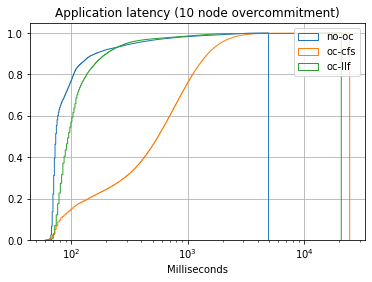

mean 858.8012524960102 224.23615875736598 0.7388963300814378
peak 4089.9877883000077 4449.780288585829 -0.08796908912908227


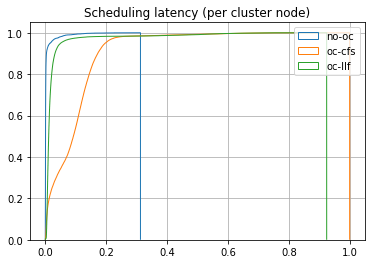

mean 0.8485454185967334 0.5229019948804525 0.38376663945084727
peak 2.3626285414000052 1.6265266709333321 0.311560559592024


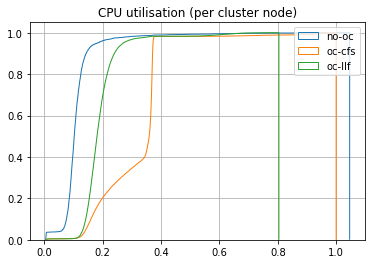

In [651]:
plot_latency_cdf(dfs_profile,dfs_oc10nodes,dfs_oc10nodes_llf,density=1)
plt.title("Application latency (10 node overcommitment)")
plt.xlabel("Milliseconds")
plt.legend(loc='upper right')

plt.show()


compare_cdf_cluster_contention(contention_cluster_profile, contention_cluster_oc10nodes, contention_cluster_oc10nodes_llf)
plt.title("Scheduling latency (per cluster node)")
plt.show()

compare_cdf_cluster_usage(usage_cluster_profile, usage_cluster_oc10nodes, usage_cluster_oc10nodes_llf)
plt.title("CPU utilisation (per cluster node)")
plt.show()


<AxesSubplot:>

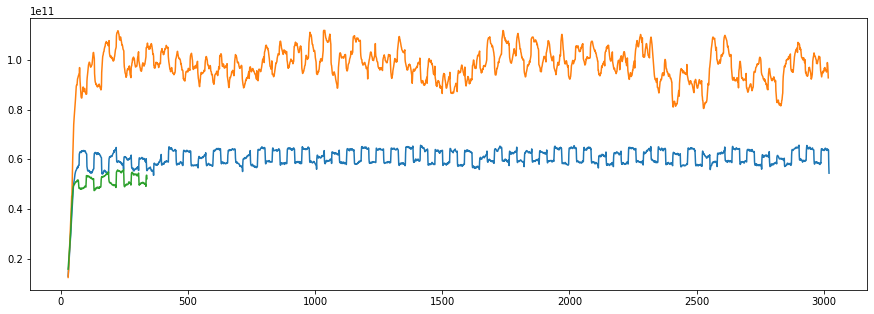

In [932]:
(pd.concat(usage_cluster_oc10nodes_llf[-10:],axis=1).sum(axis=1)).rolling(30).mean().reset_index()[0].plot(figsize=(15,5))
(pd.concat(usage_cluster_oc10nodes[-10:],axis=1).sum(axis=1)).rolling(30).mean().reset_index()[0].plot(figsize=(15,5))
(pd.concat(usage_cluster_profile[-14:],axis=1).sum(axis=1)).rolling(30).mean().reset_index()[0].plot(figsize=(15,5))

<AxesSubplot:>

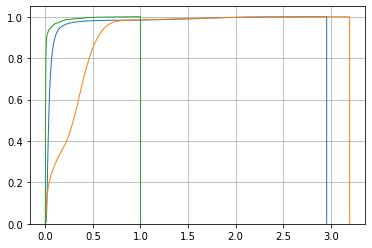

In [994]:
dist_contention_llf = pd.concat([df.sum(axis=1) for df in contention_cluster_oc10nodes_llf[-10:]])
dist_contention_cfs = pd.concat([df.sum(axis=1) for df in contention_cluster_oc10nodes[-10:]])
dist_contention_profile = pd.concat([df.sum(axis=1) for df in contention_cluster_profile[-10:]])

(dist_contention_llf/dist_contention_profile.max()).hist(cumulative=True, density=1, bins=100000,histtype='step',label='200')
(dist_contention_cfs/dist_contention_profile.max()).hist(cumulative=True, density=1, bins=100000,histtype='step',label='200')
(dist_contention_profile/dist_contention_profile.max()).hist(cumulative=True, density=1, bins=100000,histtype='step',label='200')



<AxesSubplot:>

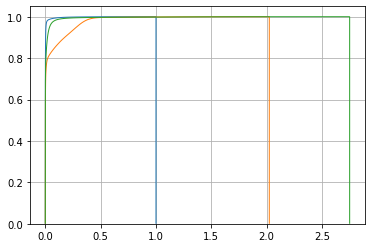

In [980]:
sum_contention_llf = pd.Series(pd.concat(contention_cluster_oc10nodes_llf[-10:],axis=1).values.flatten()).dropna()
sum_contention_cfs = pd.Series(pd.concat(contention_cluster_oc10nodes[-10:],axis=1).values.flatten()).dropna()
sum_contention_profile = pd.Series(pd.concat(contention_cluster_profile[-14:],axis=1).values.flatten()).dropna()

(sum_contention_profile/sum_contention_profile.max()).hist(cumulative=True, density=1, bins=100000,histtype='step',label='200')
(sum_contention_cfs/sum_contention_profile.max()).hist(cumulative=True, density=1, bins=100000,histtype='step',label='200')
(sum_contention_llf/sum_contention_profile.max()).hist(cumulative=True, density=1, bins=100000,histtype='step',label='200')


<AxesSubplot:>

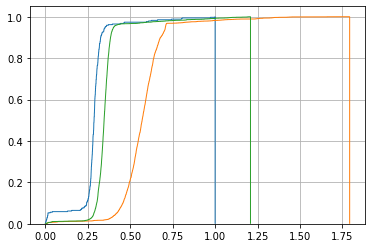

In [984]:
sum_usage_llf = (pd.concat(usage_cluster_oc10nodes_llf[-10:],axis=1).sum(axis=1)).rolling(1).mean()
sum_usage_cfs = (pd.concat(usage_cluster_oc10nodes[-10:],axis=1).sum(axis=1)).rolling(1).mean()
sum_usage_profile = (pd.concat(usage_cluster_profile[-14:],axis=1).sum(axis=1)).rolling(1).mean()

(sum_usage_profile/sum_usage_profile.max()).hist(cumulative=True, density=1, bins=100000,histtype='step',label='200')
(sum_usage_cfs/sum_usage_profile.max()).hist(cumulative=True, density=1, bins=100000,histtype='step',label='200')
(sum_usage_llf/sum_usage_profile.max()).hist(cumulative=True, density=1, bins=100000,histtype='step',label='200')


<AxesSubplot:xlabel='ts'>

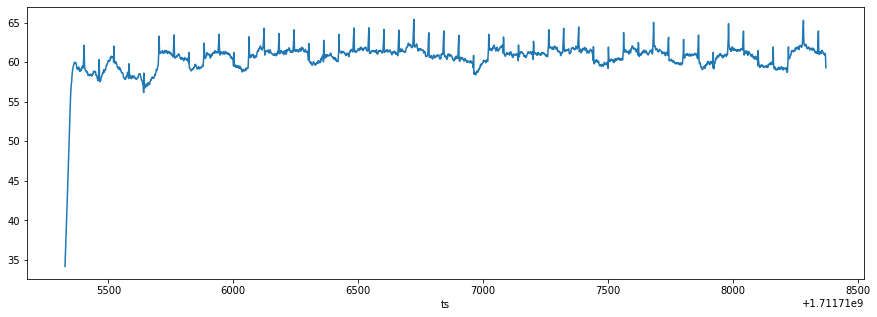

In [182]:
(pd.concat(usage_cluster_oc10nodes_llf[-10:],axis=1).sum(axis=1)/1000000000).rolling(60).mean().plot(figsize=(15,5))

In [313]:
for node_data in dump_profile_schedstat[-15:][:1]:
        
    node_data_json = [json.loads(row) for row in node_data[:-1]]
#     print(node_data_json[0])
#     print(node_data_json[-1])    
    
    ts1 = node_data_json[0]['timestamp']
    ts2 = node_data_json[-1]['timestamp']
    
    print(ts2 - ts1)
    
    per_cpu_data_1 = [(cpu_data.split(' ')[-3:]) for cpu_data in node_data_json[0]['schedstat']]
    per_cpu_data_2 = [(cpu_data.split(' ')[-3:]) for cpu_data in node_data_json[0]['schedstat']]
    
    
    print(per_cpu_data_1[0], per_cpu_data_1[0])


344.96599292755127
['365981605615593', '183964027371218', '4125212091'] ['365981605615593', '183964027371218', '4125212091']


In [429]:
funcs = (pd.concat(usage_cluster_oc10nodes[-10:],axis=1)).columns
len([re.findall("pytorch.*",func)[0] for func in funcs]) == len(funcs), len(funcs), 


dfu_cfs = (pd.concat(usage_cluster_oc10nodes[-10:],axis=1))

dfu_cfs.shape


(3019, 782)

In [215]:
funcs = (pd.concat(usage_cluster_oc10nodes_llf[-10:],axis=1)).columns
len([re.findall("pytorch.*",func)[0] for func in funcs]) == len(funcs), len(funcs), 


dfu_llf = (pd.concat(usage_cluster_oc10nodes_llf[-10:],axis=1))

dfu_llf.shape


(3022, 782)

In [851]:
funcs = (pd.concat(usage_cluster_profile[-15:],axis=1)).columns
len([re.findall("pytorch.*",func)[0] for func in funcs]) == len(funcs), len(funcs)

dfu_profile = (pd.concat(usage_cluster_profile[-15:],axis=1))

dfu_profile.shape

(341, 782)

In [852]:
peaks = dfu_profile.rolling(5).mean().max().values/1000000000
# print(peaks)

binpacked = (binpacking.to_constant_volume(peaks,12))
ideal_capacity = len(binpacked)
print("binpacking",ideal_capacity, len(peaks))


binpacking 13 782


In [855]:
peaks = dfu_llf.rolling(7).mean()[:1500].max().values/1000000000
# print(peaks)

binpacked = (binpacking.to_constant_volume(peaks,12))
ideal_capacity = len(binpacked)
print("binpacking",ideal_capacity, len(peaks))


binpacking 14 782


In [839]:
0.75 * 12 * 10 / 600

0.15

In [849]:
600 * 0.15  / 120 

0.75

In [842]:
600 / (12 / 0.15)

7.5

In [430]:
peaks = (dfu_cfs.rolling(1)).mean().max().values/1000000000
# print(peaks)

binpacked = (binpacking.to_constant_volume(peaks,12))
ideal_capacity = len(binpacked)
print("binpacking",ideal_capacity, len(peaks))


binpacking 62 782


3.4361258955609757
3.094163363413374
3.394317679299694
3.3961954531932514
3.873980117126543
3.1981262677361966
3.270130075863777
3.73152762036875
5.155982707091483
3.6528702947931033
4.673448230616613
3.2679329451906254
2.706725447540625
3.7971351903079364
4.123513231887821


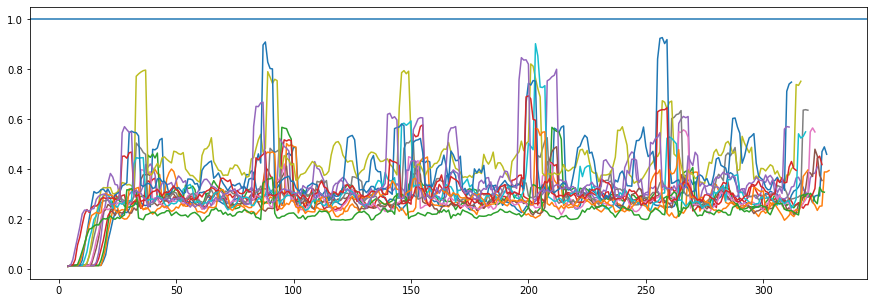

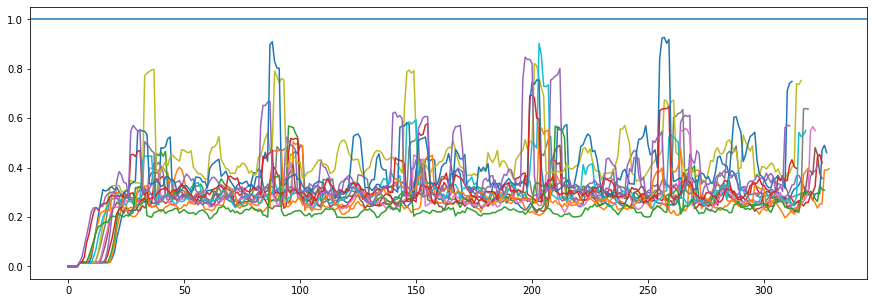

In [552]:
for node in usage_cluster_profile[-15:]:
    ((node).sum(axis=1)/12000000000).reset_index()[0].rolling(5).mean().plot(figsize=(15,5))
    print((node).sum(axis=1).mean()/1000000000)
plt.axhline(1)
plt.show()

for node in usage_cluster_profile[-15:]:
    ((node).rolling(5).mean().sum(axis=1)/12000000000).reset_index()[0].plot(figsize=(15,5))
#     print((node).sum(axis=1).mean()/1000000000)
plt.axhline(1)

0.515254098097353 0.51202060482096
0.6039925314444876 0.600360413585524
0.4967165494934094 0.49361990647092957
0.4870618055060343 0.48421499725514017
0.5197712181766733 0.5170475531405837
0.4989682865300498 0.49635342916686814
0.4858016535738899 0.4838235499221763
0.5700448009764314 0.5679469074183962
0.5026248254149732 0.5003699144903735
0.5743141259969116 0.5720502923574683


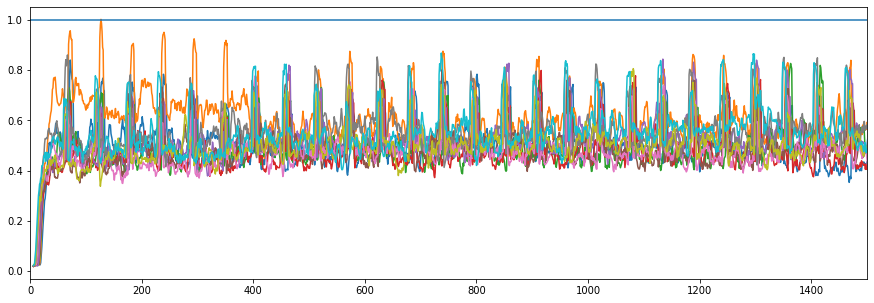

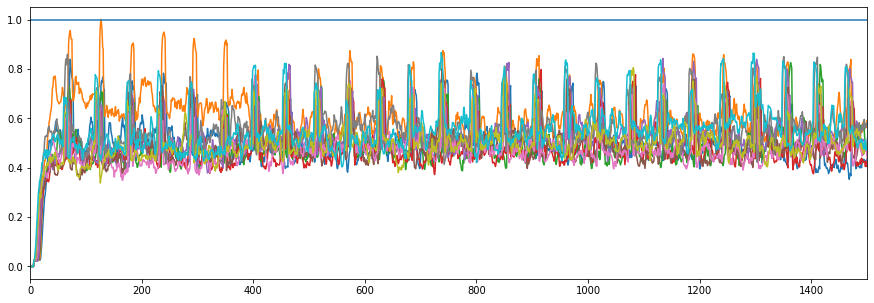

In [555]:
for node in usage_cluster_oc10nodes_llf[-10:]:
    ((node).sum(axis=1)/12000000000).reset_index()[0].rolling(7).mean().plot(figsize=(15,5),xlim=(0,1500))
    print((node).sum(axis=1).rolling(60).mean().mean()/12000000000, (node).sum(axis=1).mean()/12000000000)
    
plt.axhline(1)

plt.show()

for node in usage_cluster_oc10nodes_llf[-10:]:
    ((node).rolling(7).mean().sum(axis=1)/12000000000).reset_index()[0].plot(figsize=(15,5),xlim=(0,1500))
#     print((node).sum(axis=1).rolling(60).mean().mean()/12000000000, (node).sum(axis=1).mean()/12000000000)
    
plt.axhline(1)

In [ ]:
for node in usage_cluster_oc10nodes_llf[-10:]:
    (node).plot.area(xlim=(0,300),legend=False)
    print((node).sum(axis=1).rolling(60).mean().mean()/12000000000, (node).sum(axis=1).mean()/12000000000)
    plt.show()
    
# plt.axhline(1)

<AxesSubplot:>

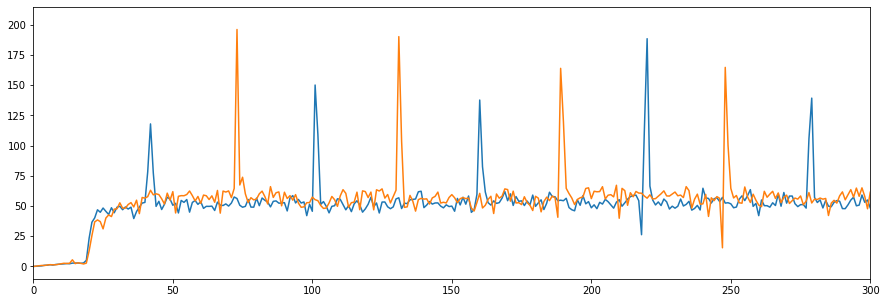

In [921]:
(dfu_profile.sum(axis=1).reset_index()[0]/1000000000).plot(figsize=(15,5))
(dfu_llf.sum(axis=1).reset_index()[0]/1000000000).plot(figsize=(15,5),xlim=(0,300))

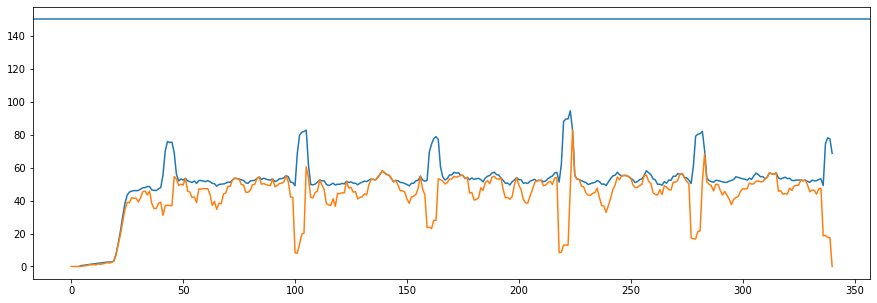

In [549]:
(dfu_profile.sum(axis=1).reset_index()[0]/1000000000).rolling(5).mean().plot(figsize=(15,5))
(dfu_profile.rolling(5).mean().sum(axis=1).reset_index()[0]/1000000000).plot(figsize=(15,5))

plt.axhline(10 * 15)

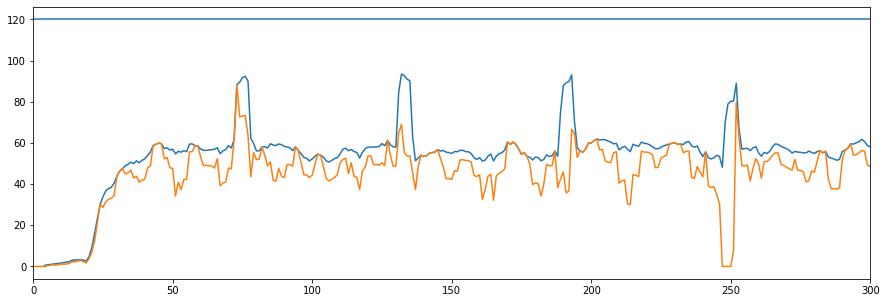

In [546]:
(dfu_llf.sum(axis=1).reset_index()[0]/1000000000).rolling(5).mean().plot(figsize=(15,5),xlim=(0,300))
(dfu_llf.rolling(5).mean().sum(axis=1).reset_index()[0]/1000000000).plot(figsize=(15,5),xlim=(0,300))

plt.axhline(10 * 12)

180

In [19]:
(3022)/60

50.36666666666667

In [31]:
60 / 12

5.0

200    122115
504        20
Name: status_code, dtype: int64

200    1155780
504       2717
429       2641
Name: status_code, dtype: int64

200    1150146
504       4426
429        276
502          6
Name: status_code, dtype: int64

1sec target -6.2932671863926295 -8.445216158752658


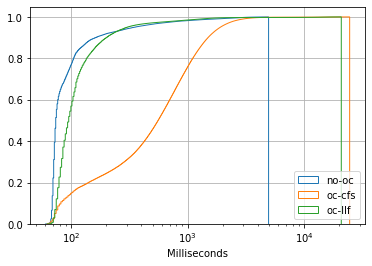

mean 858.8012524960102 224.23615875736598 0.7388963300814378
peak 4089.9877883000077 4449.780288585829 -0.08796908912908227


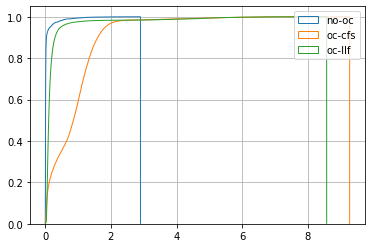

mean 0.8485454185967334 0.5229019948804525 0.38376663945084727
peak 2.3626285414000052 1.6265266709333321 0.311560559592024


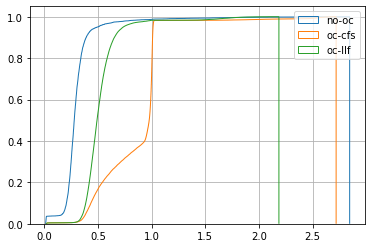

In [645]:
plot_latency_cdf(dfs_profile,dfs_oc10nodes,dfs_oc10nodes_llf,density=1)
# plt.title("Application latency (10 node overcommitment)")
plt.xlabel("Milliseconds")
plt.legend(loc='lower right')

plt.show()


compare_cdf_cluster_contention(contention_cluster_profile, contention_cluster_oc10nodes, contention_cluster_oc10nodes_llf)
# plt.title("Scheduling latency (per cluster node)")
plt.show()

compare_cdf_cluster_usage(usage_cluster_profile, usage_cluster_oc10nodes, usage_cluster_oc10nodes_llf)
# plt.title("CPU utilisation (per cluster node)")
plt.show()


In [871]:

def compare_clusters(dump_schedstat1,dump_schedstat12,control_nodes=10):

    dfs = []
    
    dfs1 = []
    dfs2 = []
    
    diff_factor = 30

    for index, dump in enumerate(dump_schedstat1):    

        fig, (ax1, ax2) = plt.subplots(1, 2)
        
        rows = []        
        for line in dump[:-1]:

            data = json.loads(line)
            cpustats = (data['schedstat'])
            ts = (data['timestamp'])

            usage_per_cpu = [int(cpustat.split(' ')[7]) for cpustat in cpustats]
            wait_per_cpu = [int(cpustat.split(' ')[8]) for cpustat in cpustats]

            row = [ts] +usage_per_cpu+ wait_per_cpu
            rows.append(row)

        columns = ['ts'] + [f'usage-cpu{x}' for x in range(12)] + [f'wait-cpu{x}' for x in range(12)]
        df = pd.DataFrame(rows[:],columns=columns)    
#         display(df)
        

        df = df.set_index('ts')
        dfdiff = df - df.shift(diff_factor)
        dfdiff = dfdiff.reset_index().drop('ts',axis=1)
        dfdiff = dfdiff / diff_factor
        

        dfdiff['node_usage'] = dfdiff[[f'usage-cpu{x}' for x in range(12)]].sum(axis=1)/12000000000
        dfdiff['node_wait'] = dfdiff[[f'wait-cpu{x}' for x in range(12)]].sum(axis=1)/12000000000
        dfs1.append(dfdiff)

        
        dfdiff['node_usage'].rolling(1).mean().plot(figsize=(30,5),ax=ax1,title=f"node-usage-{labels[index]}",color='orange')
        
        print("usage before", dfdiff['node_usage'].mean(), "contention before", dfdiff['node_wait'].mean())


        dfcontention = dfdiff['node_wait']
#         dfcontention = dfcontention[dfcontention>0]
        

        dfcontention.rolling(1).mean().plot(figsize=(30,5),ax=ax2,title=f"node-contention-{labels[index]}",color='orange')
        ax1.axhline(1)
        ax2.axhline(1)
        

        dump = dump_schedstat12[index]
        rows = []
        for line in dump[:-1]:

            data = json.loads(line)
            cpustats = (data['schedstat'])
            ts = (data['timestamp'])

            usage_per_cpu = [int(cpustat.split(' ')[7]) for cpustat in cpustats]
            wait_per_cpu = [int(cpustat.split(' ')[8]) for cpustat in cpustats]

            row = [ts] +usage_per_cpu+ wait_per_cpu
            rows.append(row)

        columns = ['ts'] + [f'usage-cpu{x}' for x in range(12)] + [f'wait-cpu{x}' for x in range(12)]
        df = pd.DataFrame(rows[:],columns=columns)  
#         display(df)

        df = df.set_index('ts')
    
        dfdiff = df - df.shift(diff_factor)
        dfdiff = dfdiff.reset_index().drop('ts',axis=1)
        dfdiff = dfdiff / diff_factor

        dfdiff['node_usage'] = dfdiff[[f'usage-cpu{x}' for x in range(12)]].sum(axis=1)/12000000000
        dfdiff['node_wait'] = dfdiff[[f'wait-cpu{x}' for x in range(12)]].sum(axis=1)/12000000000
        dfs2.append(dfdiff)

        
        dfdiff['node_usage'].rolling(1).mean().plot(figsize=(30,5),ax=ax1,title=f"node-usage-{labels[index]}",color='green')
        print("usage after", dfdiff['node_usage'].mean(), "contention after", dfdiff['node_wait'].mean())
        
        dfcontention = dfdiff['node_wait']
#         dfcontention = dfcontention[dfcontention>0]
        
        dfcontention.rolling(1).mean().plot(figsize=(30,5),ax=ax2,title=f"node-contention-{labels[index]}",color='green')
        ax1.axhline(1)
        ax2.axhline(1)            
        
        plt.show()
        
    return dfs1,dfs2
      

usage before 0.16485162006219634 contention before 0.0013653886874797538
usage after 0.16485162006219634 contention after 0.0013653886874797538


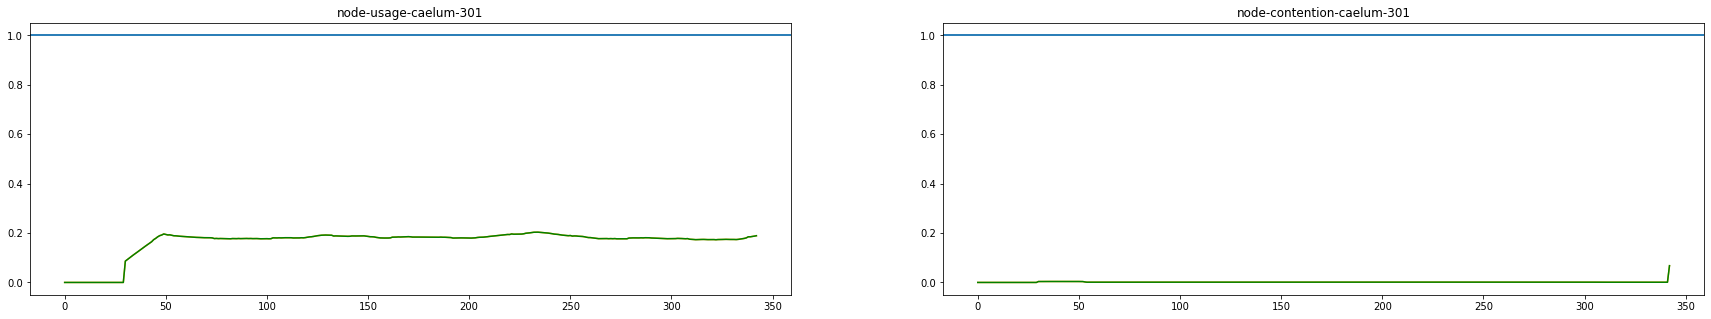

usage before 0.16965067155992064 contention before 0.04020548452523486
usage after 0.16965067155992064 contention after 0.04020548452523486


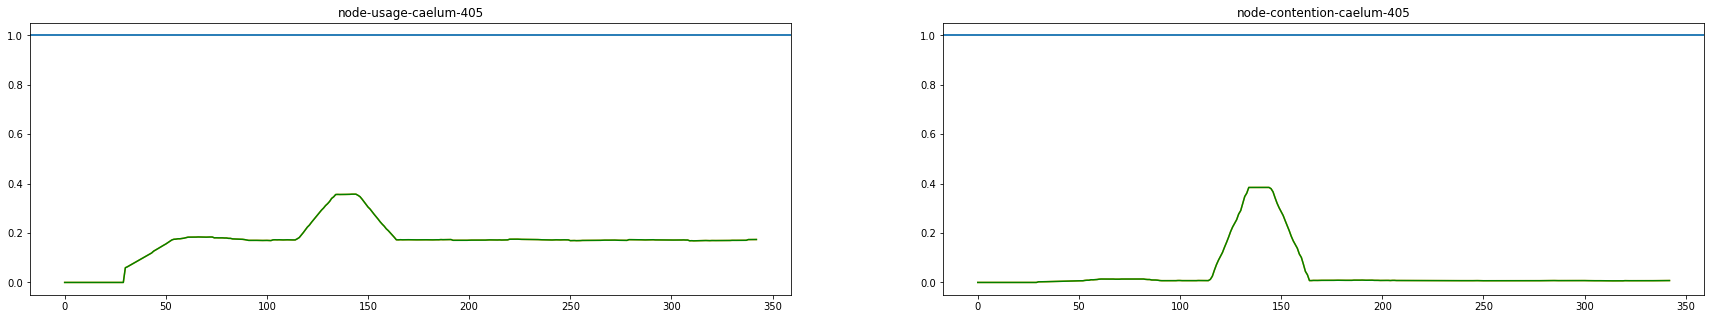

usage before 0.17254929705189248 contention before 0.03079212982582034
usage after 0.17254929705189248 contention after 0.03079212982582034


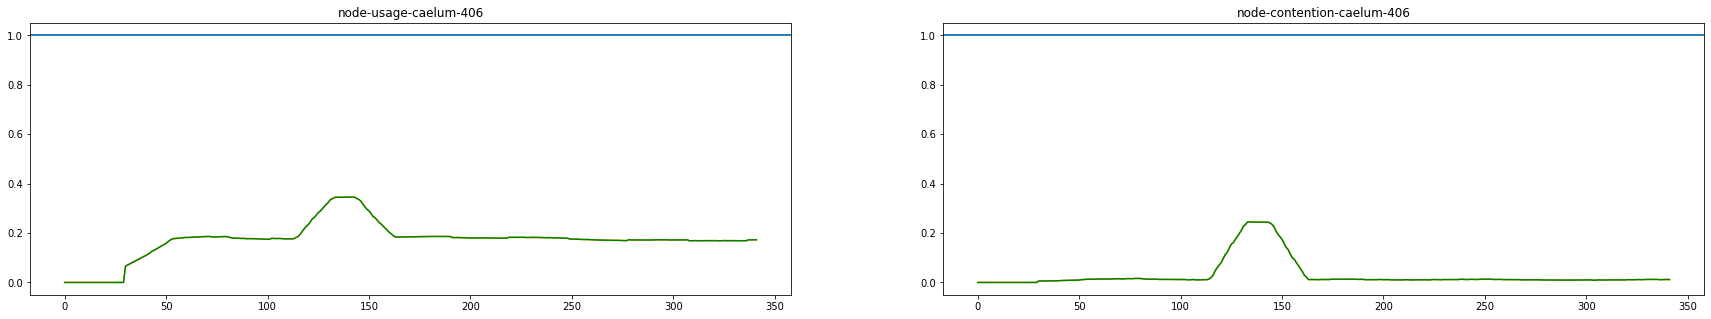

usage before 0.12484202356203704 contention before 0.005831506134868421
usage after 0.12484202356203704 contention after 0.005831506134868421


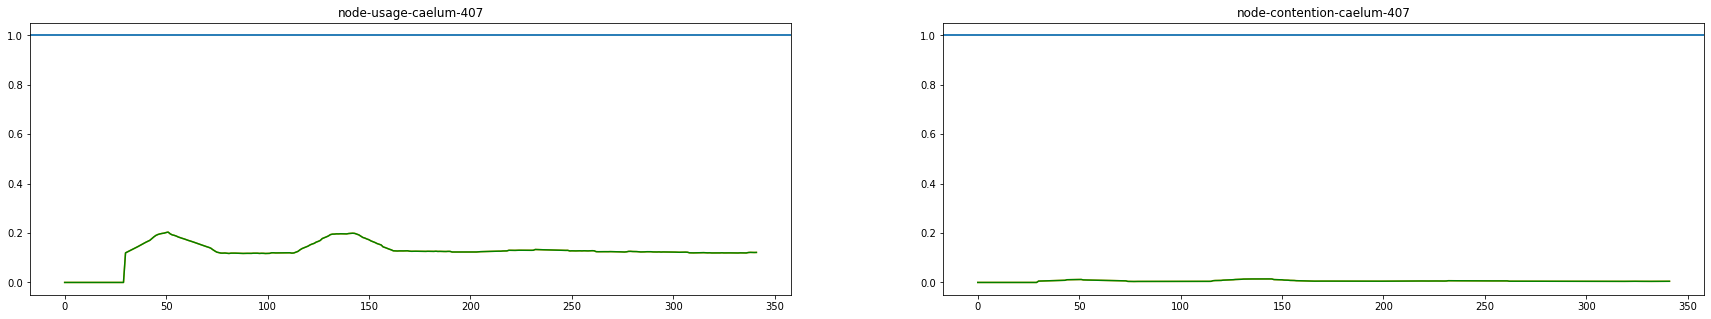

usage before 0.1498165949585689 contention before 0.02506093478253736
usage after 0.1498165949585689 contention after 0.02506093478253736


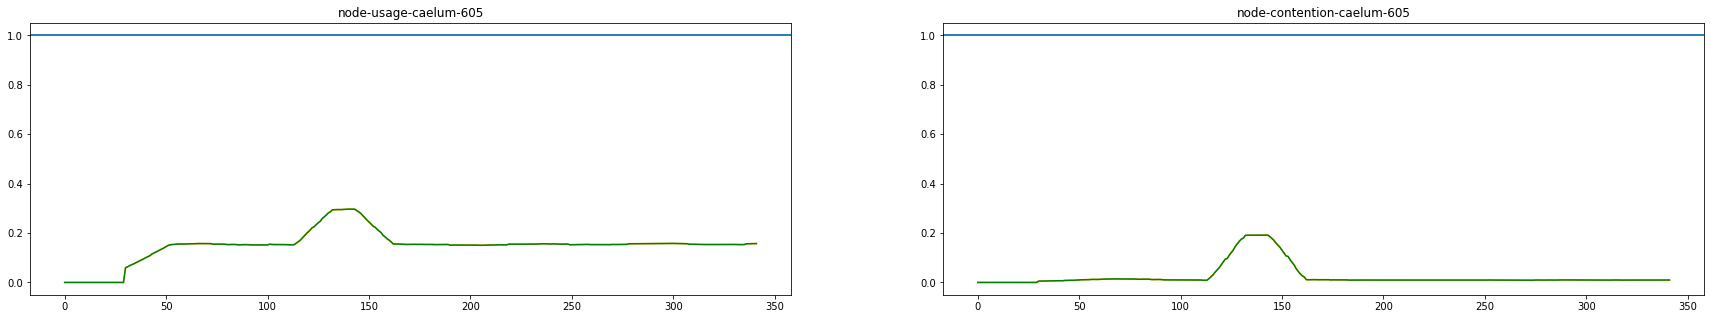

usage before 0.1921090375888235 contention before 0.016809327581911764
usage after 0.1921090375888235 contention after 0.016809327581911764


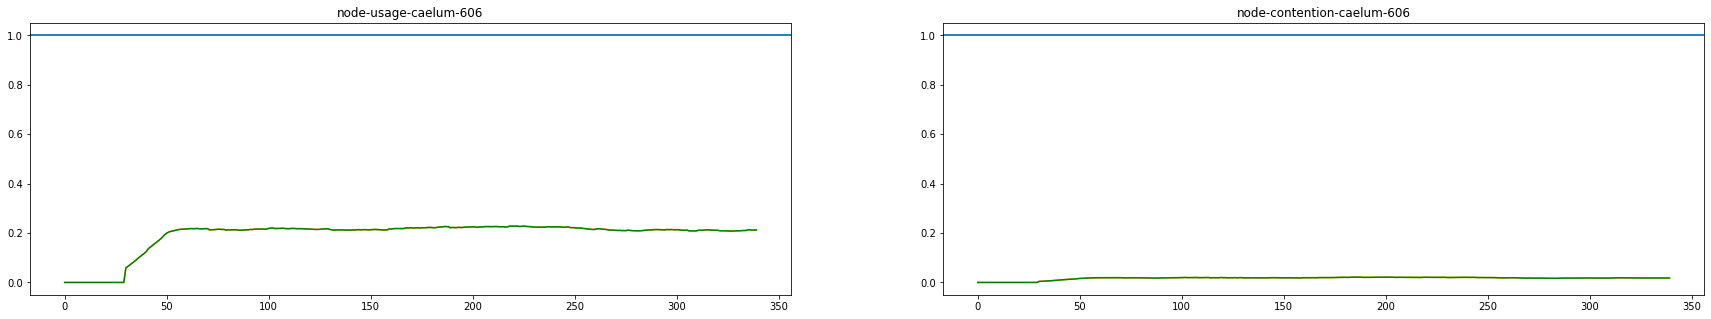

usage before 0.30132873731258464 contention before 0.08584610327635502
usage after 0.30132873731258464 contention after 0.08584610327635502


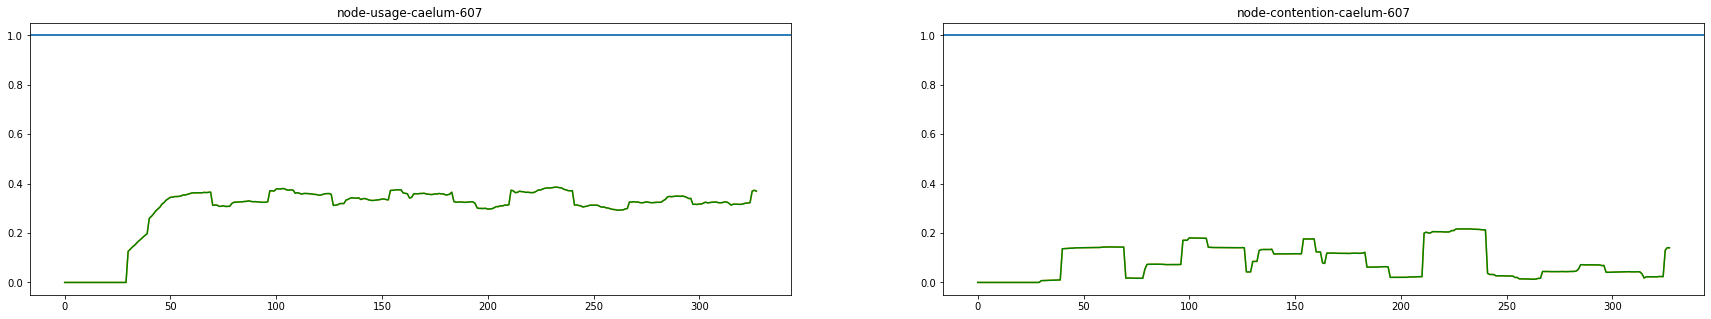

usage before 0.2736545700753956 contention before 0.057727225994595954
usage after 0.2736545700753956 contention after 0.057727225994595954


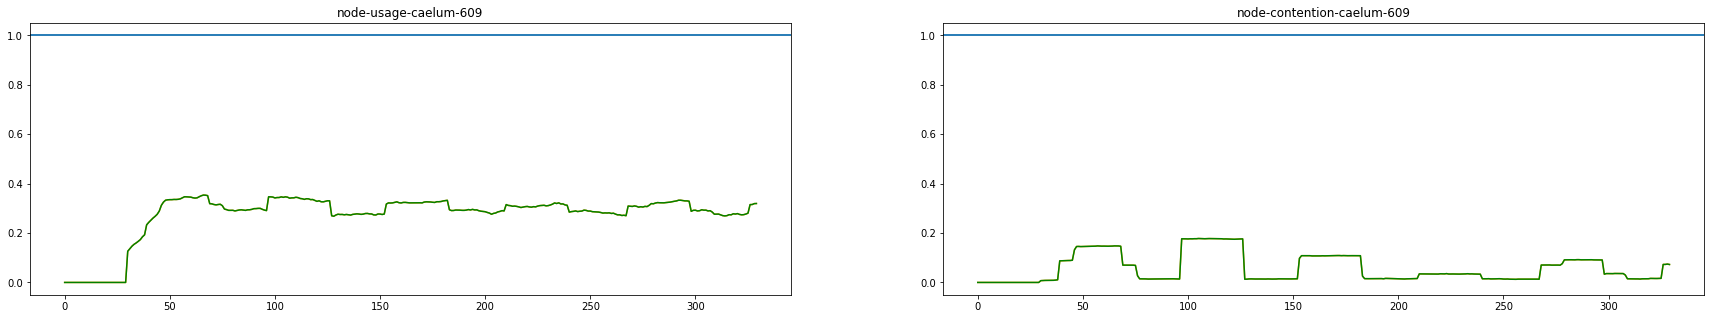

usage before 0.2992296279464346 contention before 0.07255556430892615
usage after 0.2992296279464346 contention after 0.07255556430892615


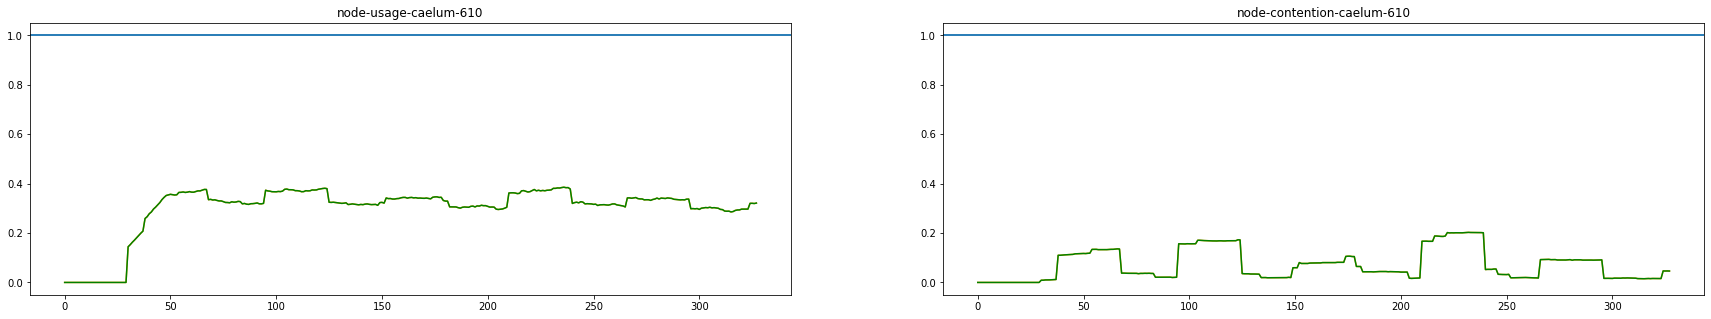

usage before 0.29803584266443256 contention before 0.07696215744336561
usage after 0.29803584266443256 contention after 0.07696215744336561


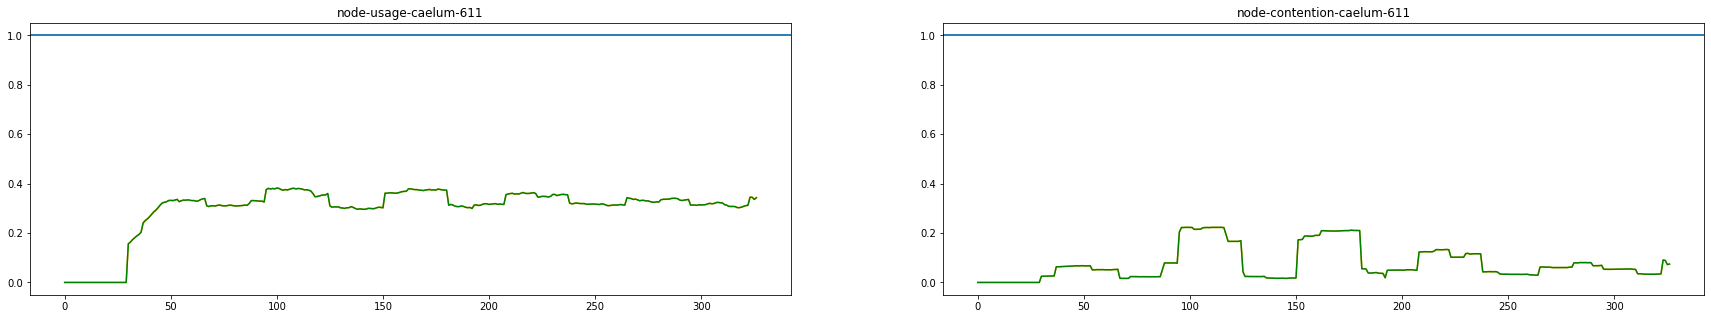

usage before 0.33659791034402436 contention before 0.12249294092286521
usage after 0.33659791034402436 contention after 0.12249294092286521


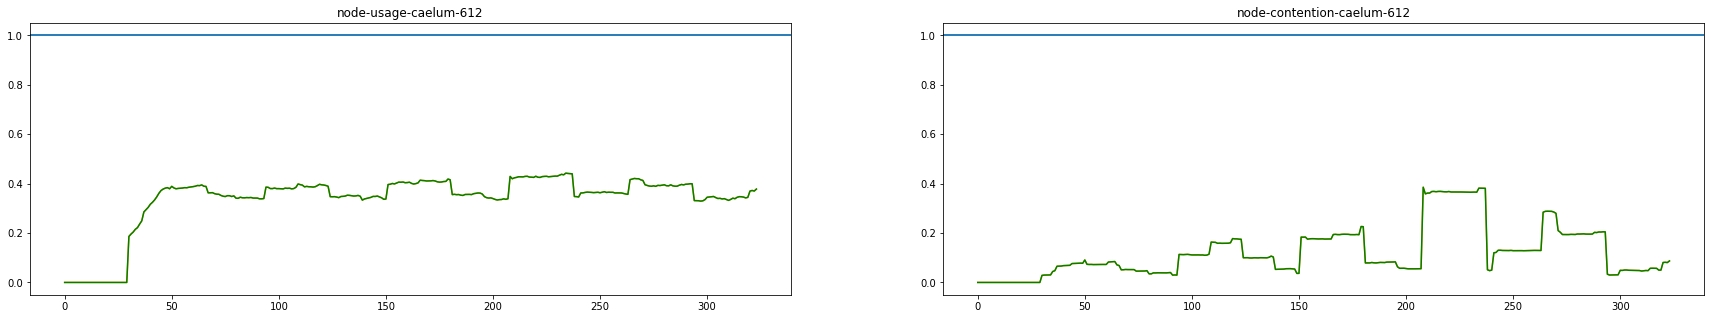

usage before 0.2802362008782805 contention before 0.04296208940910021
usage after 0.2802362008782805 contention after 0.04296208940910021


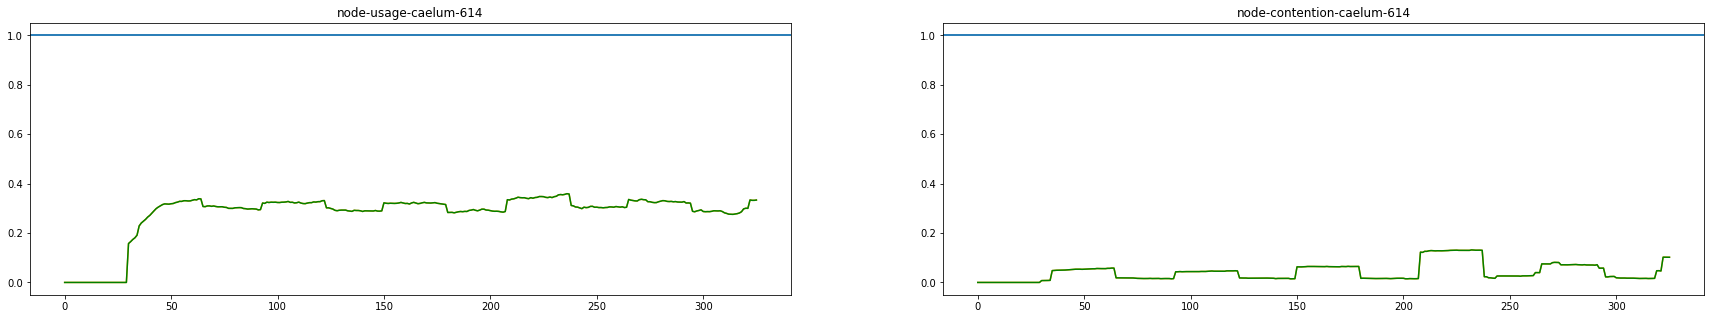

usage before 0.2846730309560271 contention before 0.0573657273631773
usage after 0.2846730309560271 contention after 0.0573657273631773


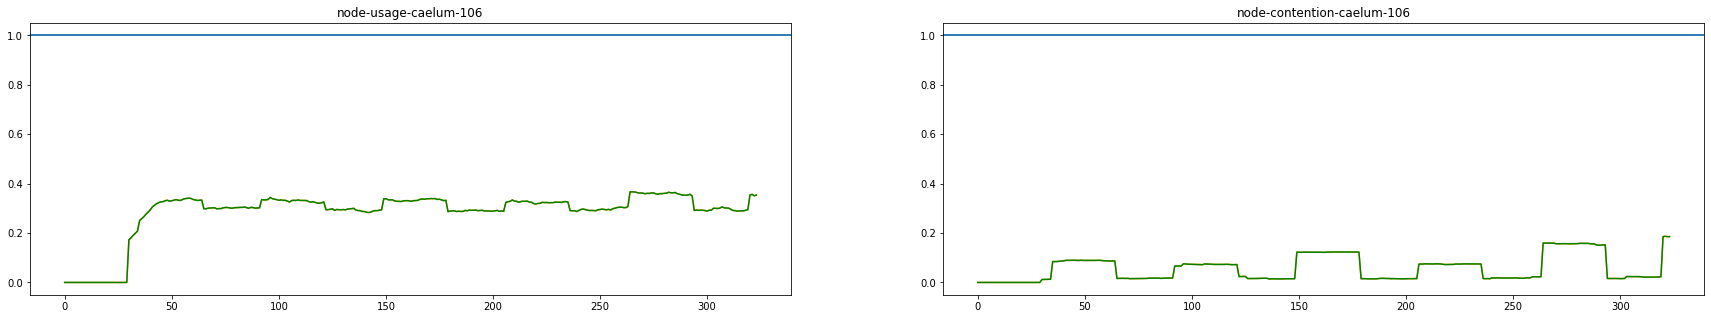

usage before 0.32049602154940104 contention before 0.10563386296575521
usage after 0.32049602154940104 contention after 0.10563386296575521


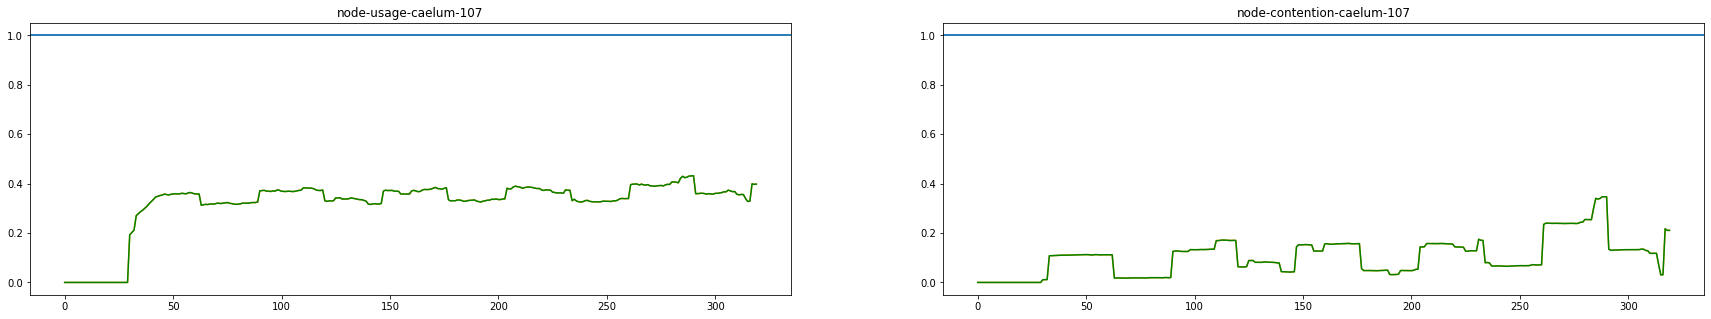

usage before 0.4352733726684192 contention before 0.23111561226697336
usage after 0.4352733726684192 contention after 0.23111561226697336


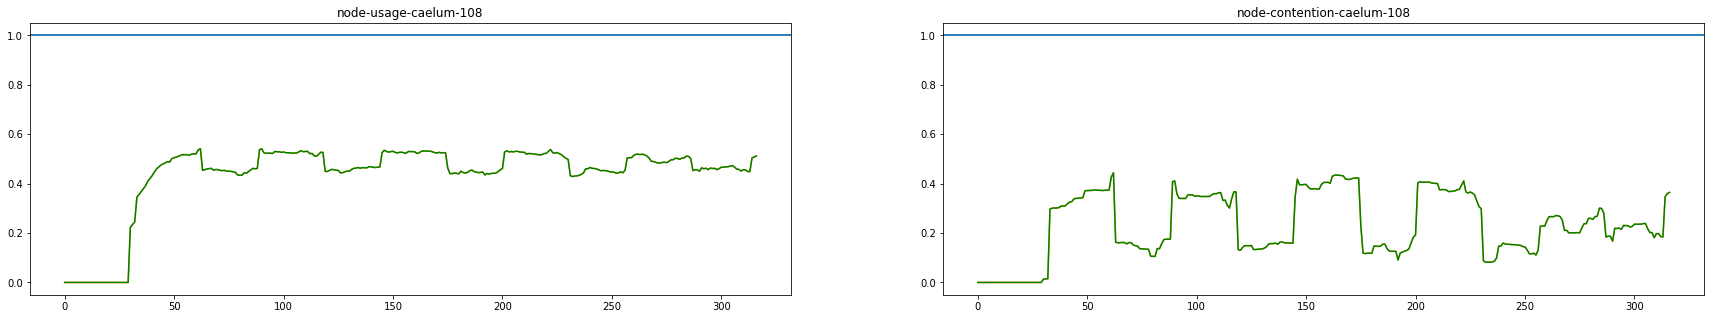

usage before 0.31604309474867637 contention before 0.11945248337305818
usage after 0.31604309474867637 contention after 0.11945248337305818


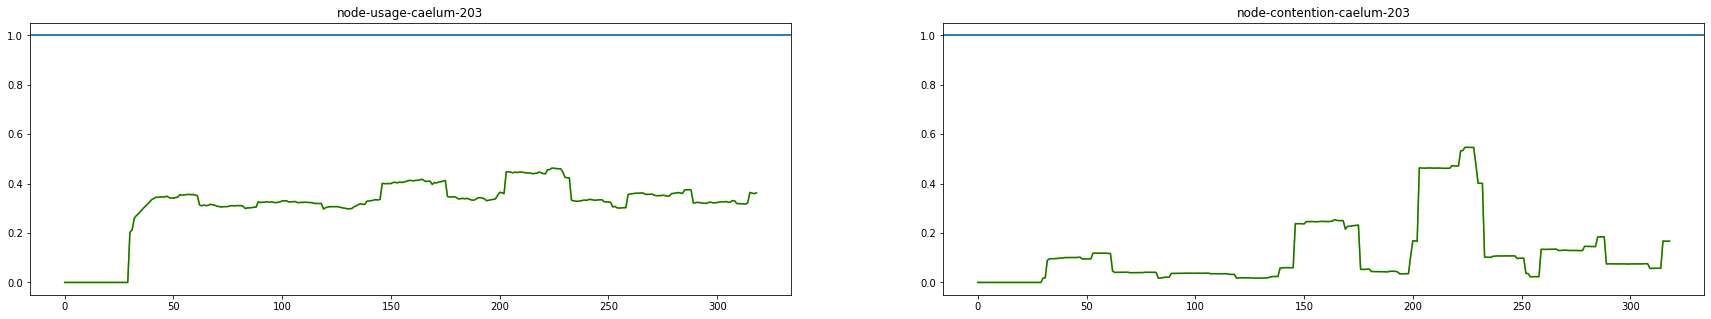

usage before 0.3936250190062211 contention before 0.2786582754116791
usage after 0.3936250190062211 contention after 0.2786582754116791


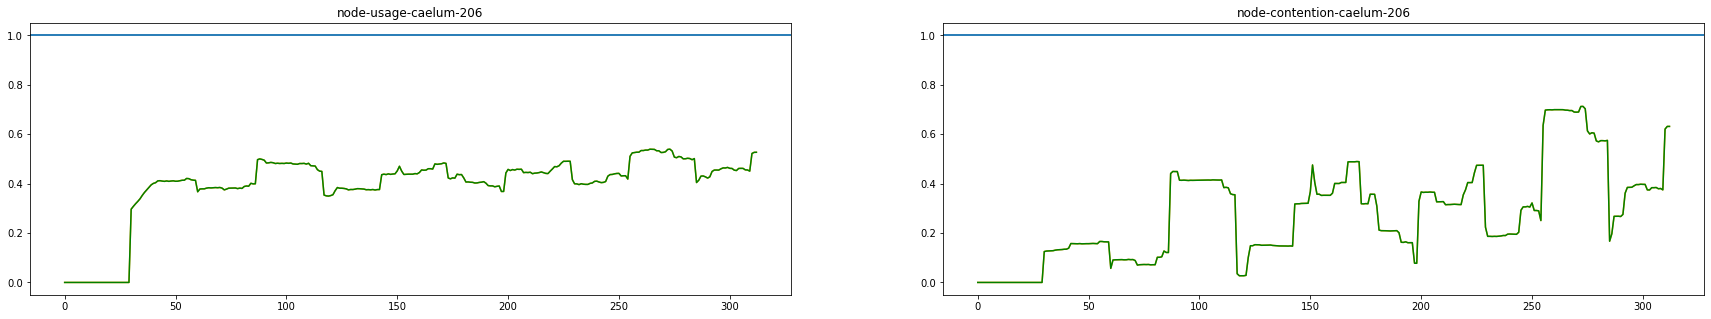

usage before 0.28423773687200593 contention before 0.06980193895134995
usage after 0.28423773687200593 contention after 0.06980193895134995


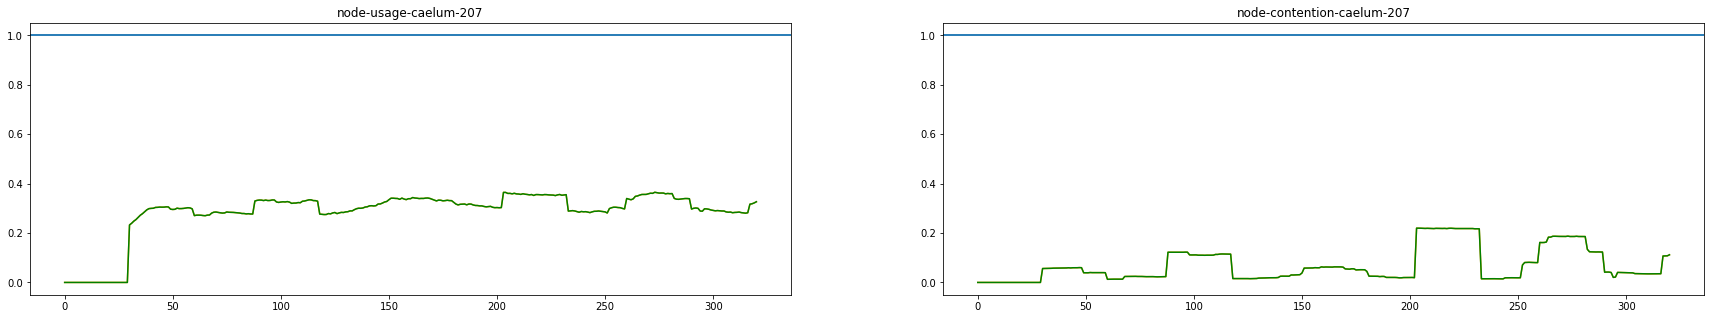

usage before 0.23991382343256318 contention before 0.0309595158169955
usage after 0.23991382343256318 contention after 0.0309595158169955


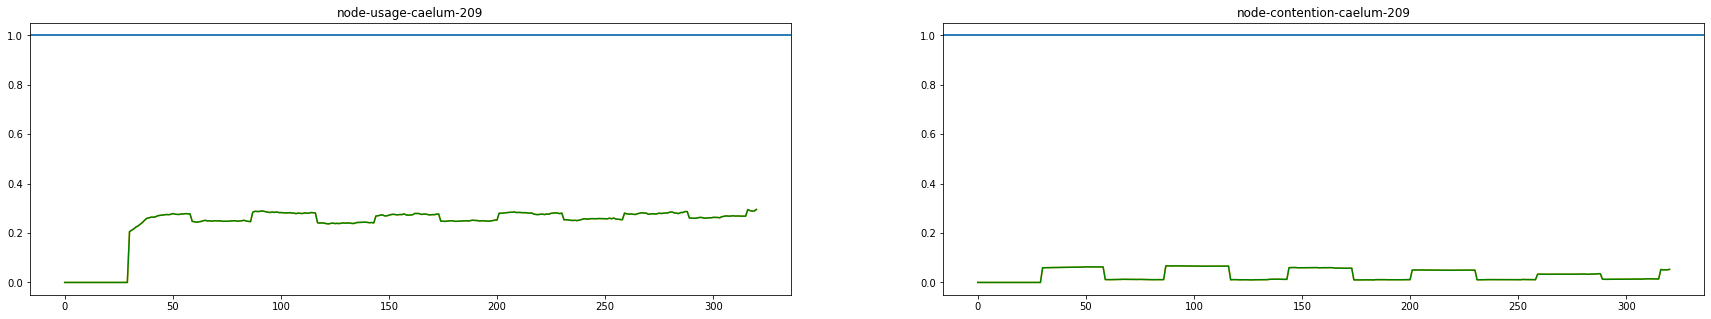

usage before 0.3250136144934336 contention before 0.10164633214204465
usage after 0.3250136144934336 contention after 0.10164633214204465


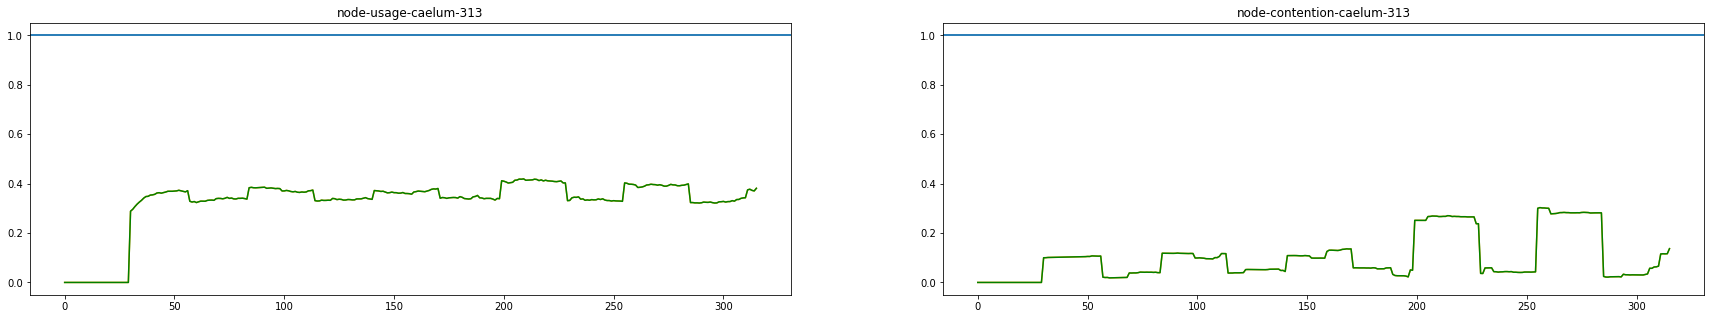

usage before 0.34896339618617345 contention before 0.1798860698764779
usage after 0.34896339618617345 contention after 0.1798860698764779


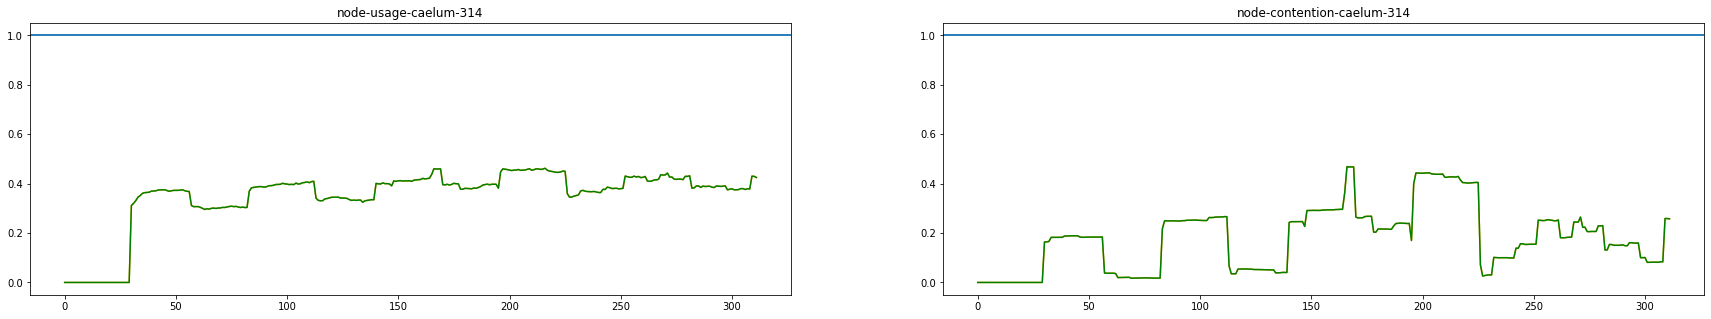

In [872]:
dump_profile_schedstat

dfs0,dfs0 = compare_clusters(dump_profile_schedstat,dump_profile_schedstat)

usage before 0.0945531985095472 contention before 0.0013759496240316423
usage after 0.09274461987055546 contention after 0.0013307894864684033


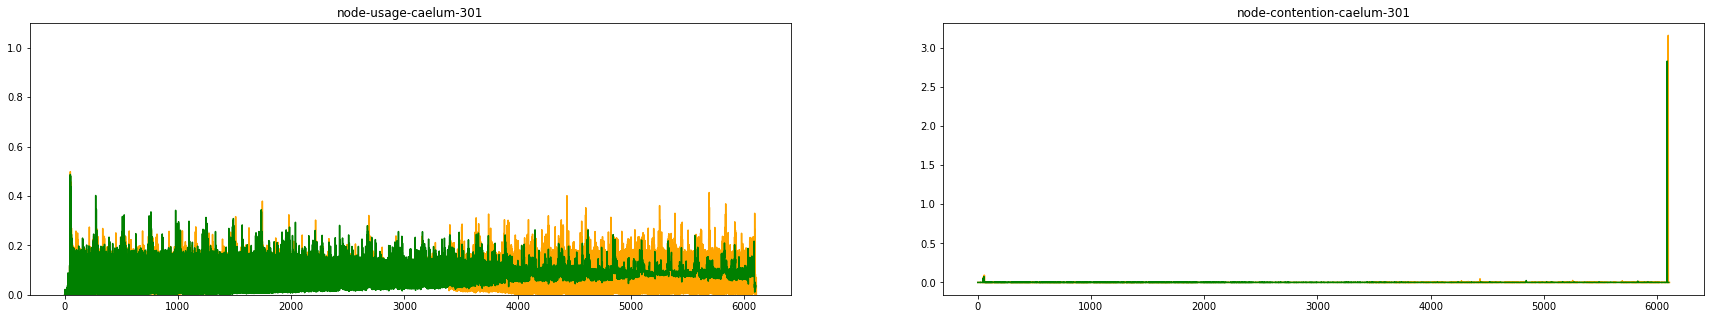

usage before 0.18506944374424444 contention before 0.01800846517795963
usage after 0.2260106021150273 contention after 0.1120064727256011


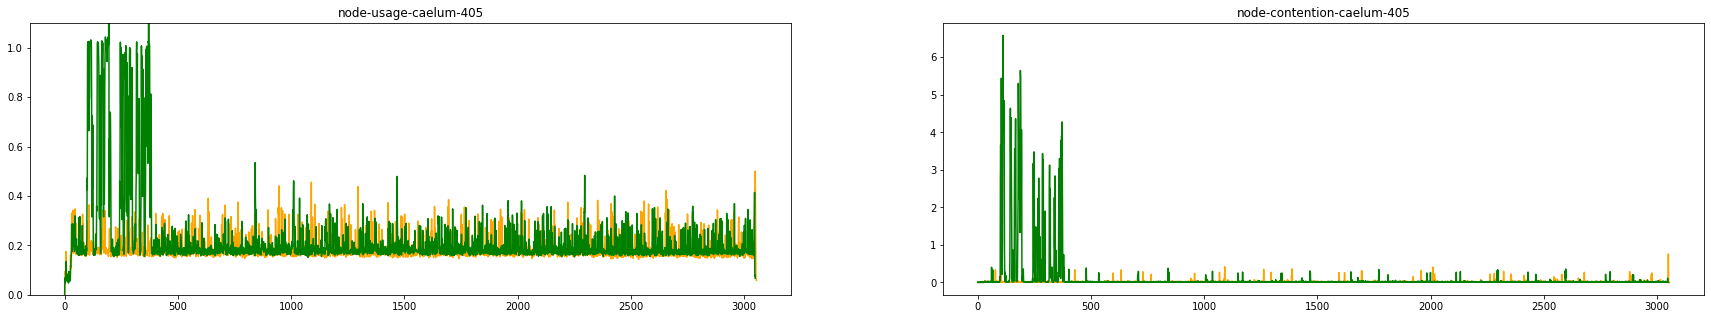

usage before 0.2961086378609747 contention before 0.019388550973804847
usage after 0.30171964424541137 contention after 0.021597553691603842


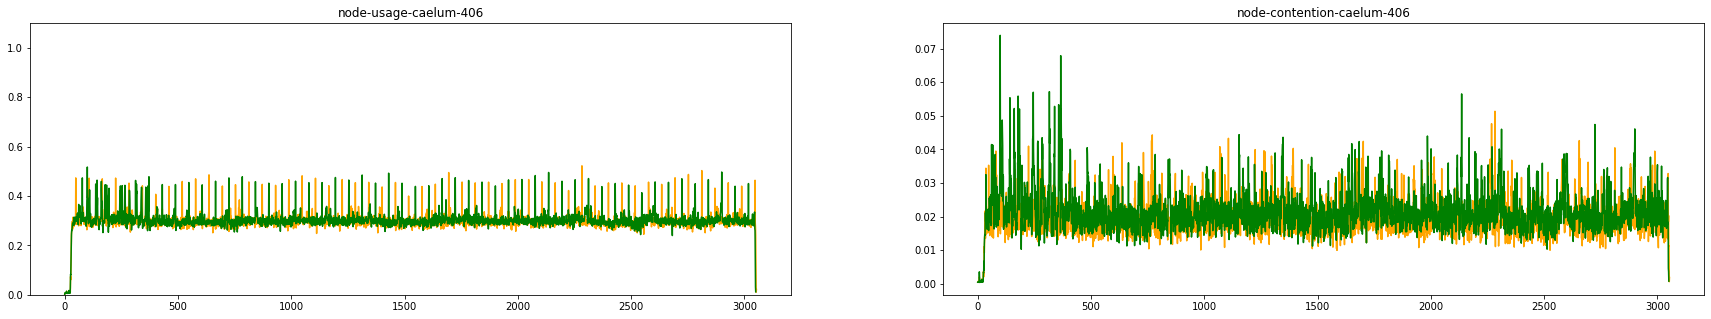

usage before 0.21265488254770096 contention before 0.022766163199077108
usage after 0.23124321168726747 contention after 0.10713911805299302


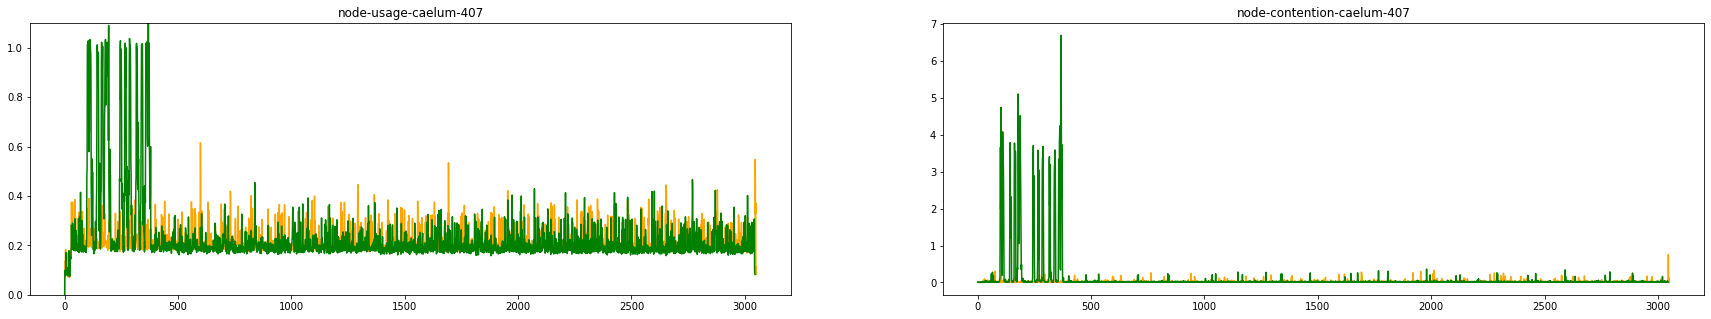

usage before 0.18285005734084453 contention before 0.017938322865016936
usage after 0.21654409517719267 contention after 0.10855676980809821


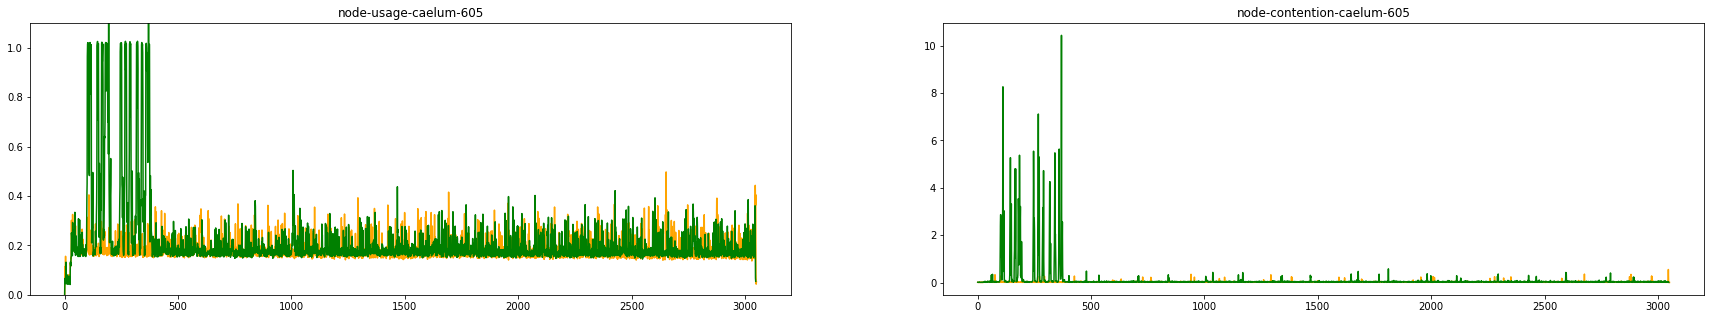

usage before 0.24021993810460354 contention before 0.03686442569995085
usage after 0.2790821646833935 contention after 0.13442300350030065


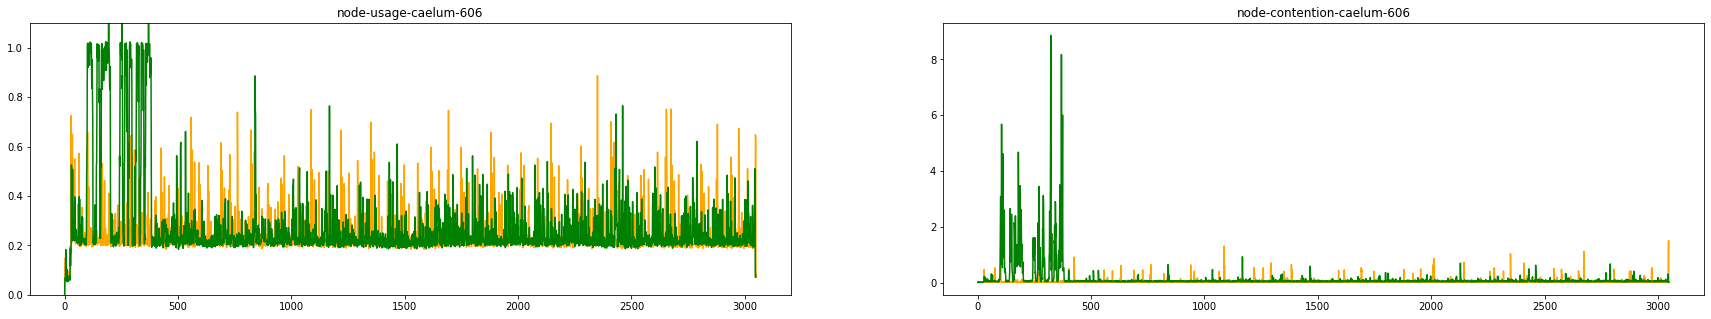

usage before 0.03174185556035992 contention before 0.0031478192111639865
usage after 0.02995064181991015 contention after 0.006074079834429104


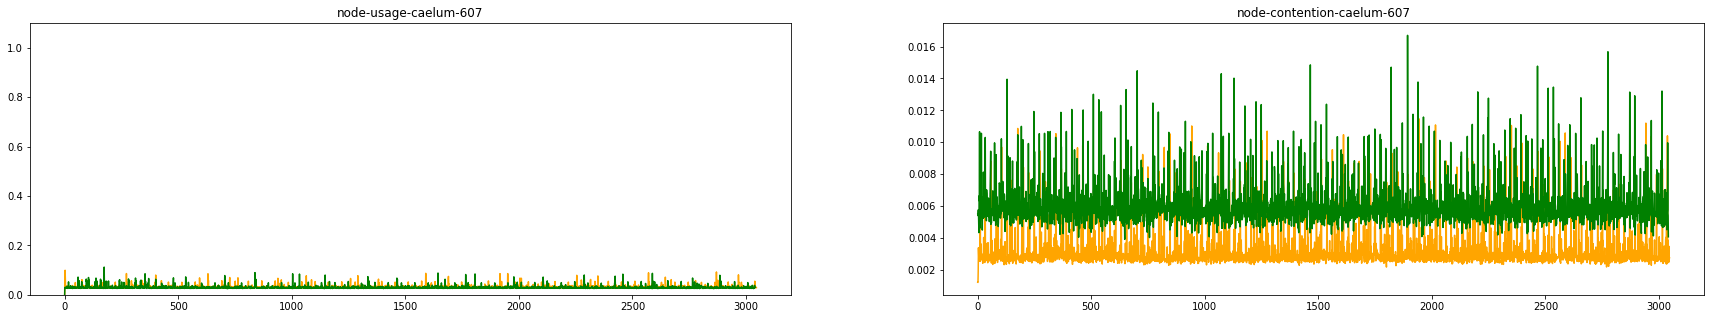

usage before 0.032626049735249046 contention before 0.0036437481110016424
usage after 0.0314849097214732 contention after 0.005898000021758194


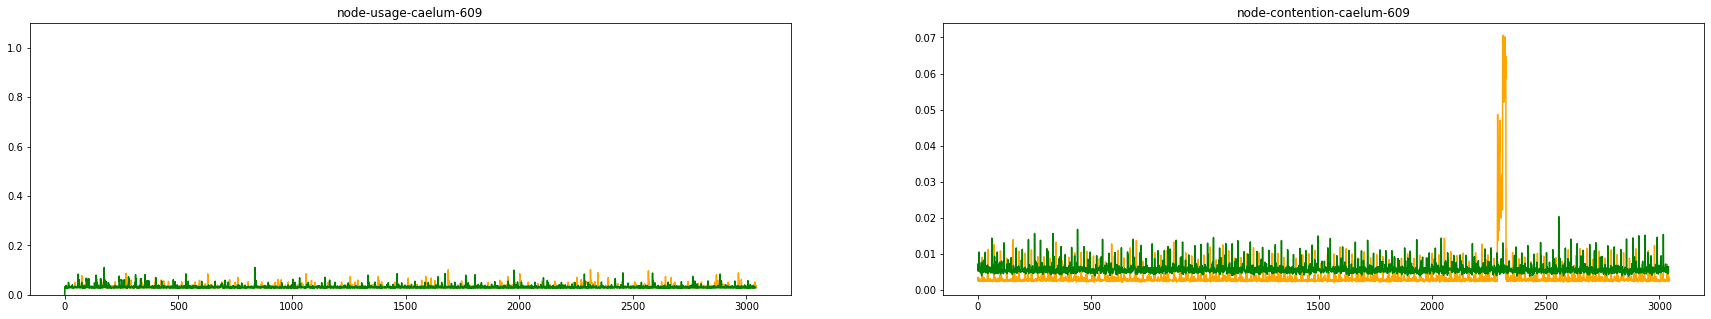

usage before 0.03461975956916174 contention before 0.003278953479262421
usage after 0.033367245274561405 contention after 0.005967366699671052


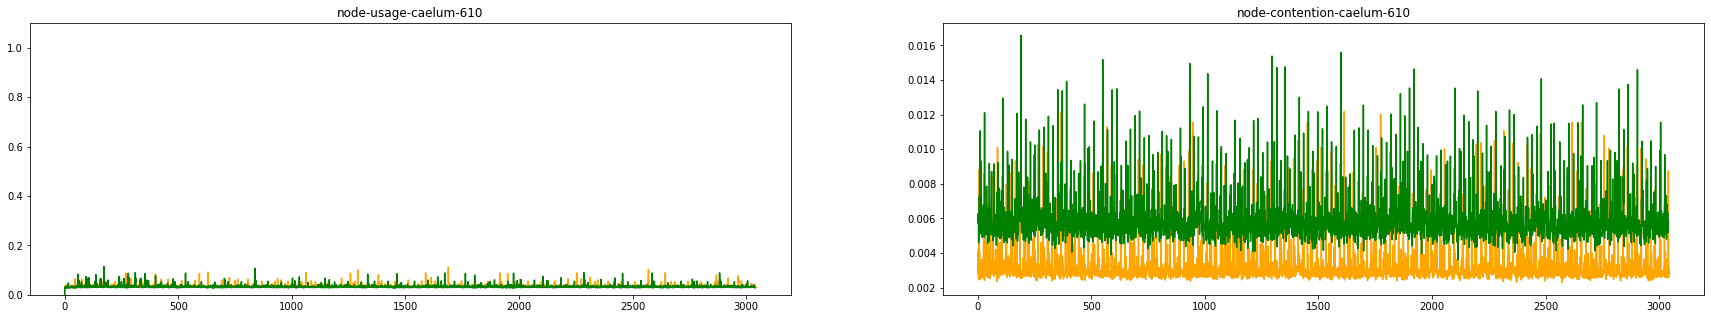

usage before 0.06527745978704919 contention before 0.0038353589818306013
usage after 0.06561892833628803 contention after 0.00590834699171044


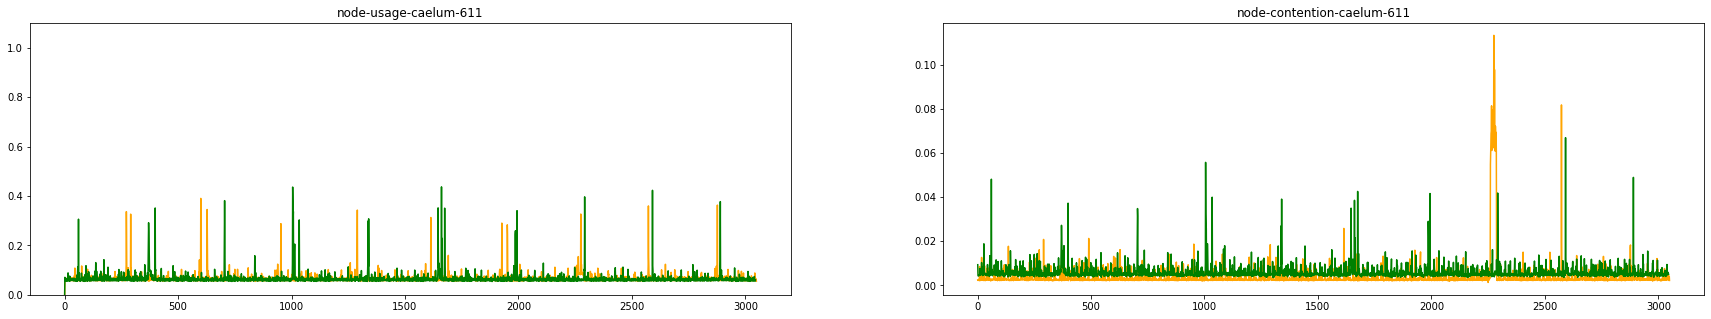

usage before 0.0339945776668583 contention before 0.0031886308283234775
usage after 0.033107698836951756 contention after 0.006030341154605263


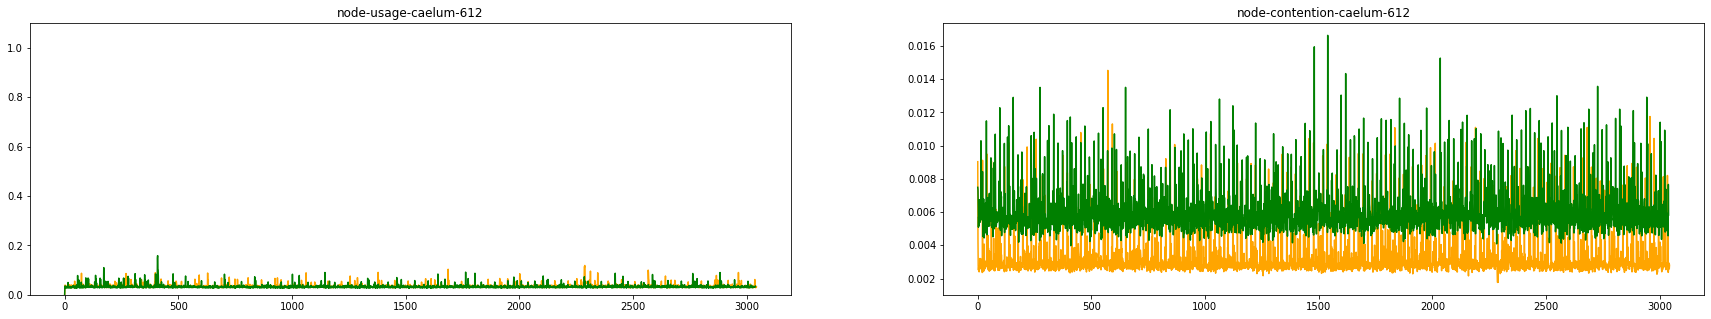

usage before 0.9008838604197564 contention before 2.50747248043994
usage after 0.5769617870678033 contention after 0.3809895195206396


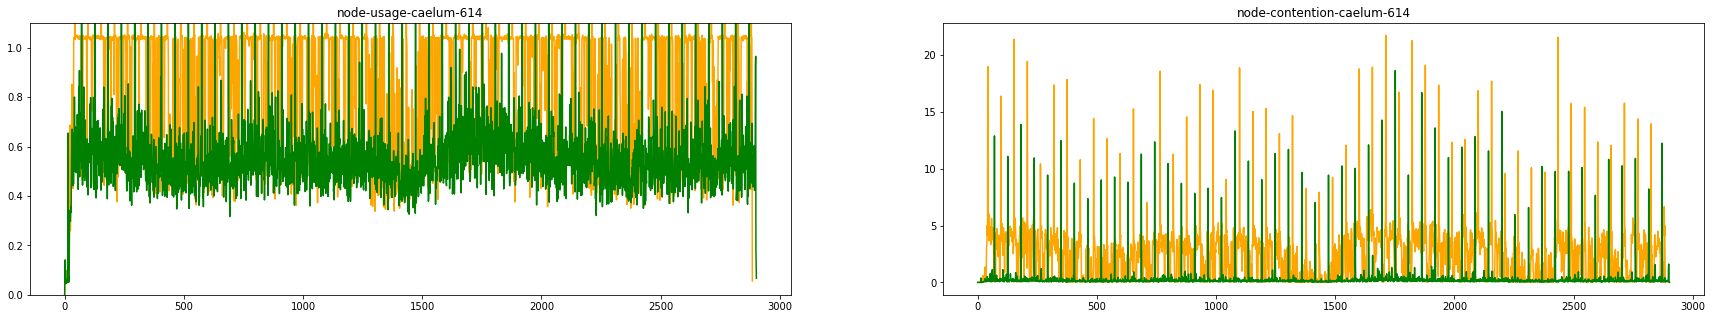

usage before 1.0125061885844056 contention before 3.598667991916637
usage after 0.6696077494337532 contention after 0.5427859617472386


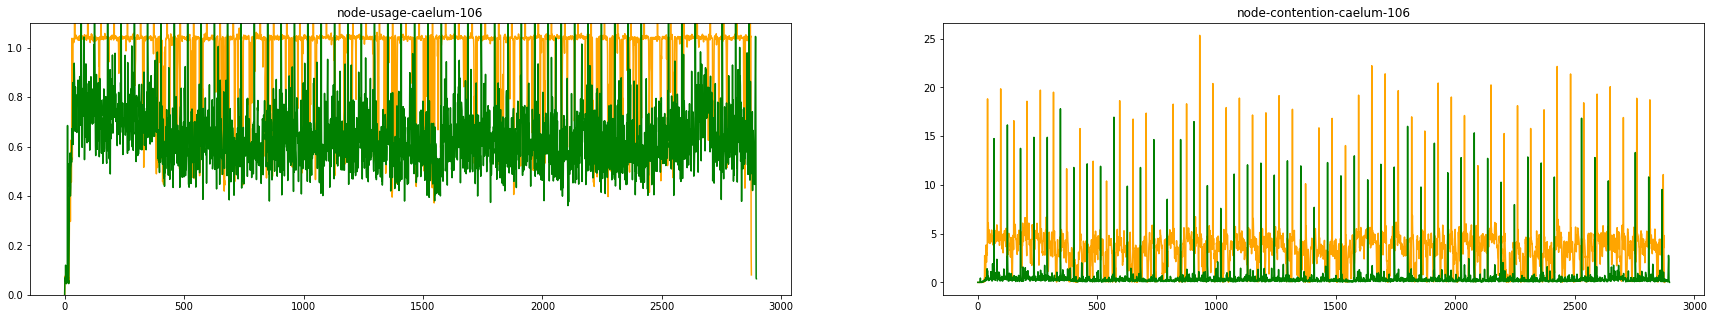

usage before 0.8421795109487691 contention before 1.9164740078655513
usage after 0.5587293260355013 contention after 0.3237774285922516


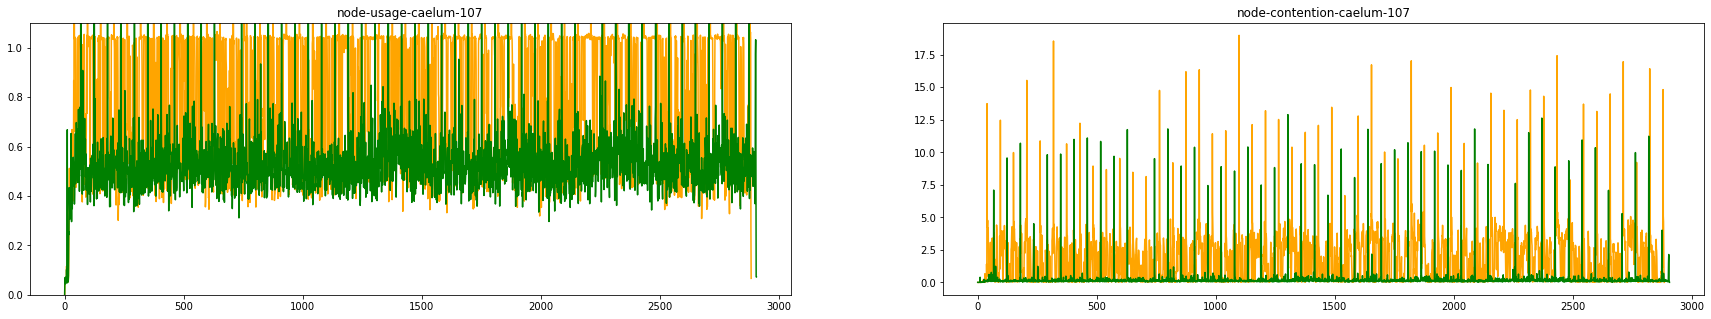

usage before 0.8407182213423907 contention before 2.1112041152268666
usage after 0.5479467391492948 contention after 0.32260928169458775


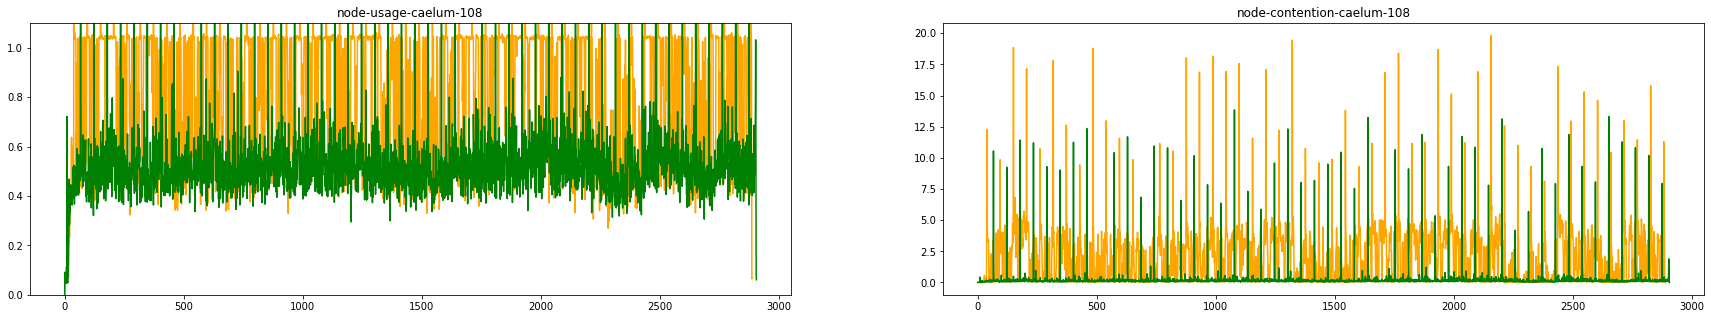

usage before 0.911431134096116 contention before 2.4762677361480554
usage after 0.581471893438841 contention after 0.35411416065390133


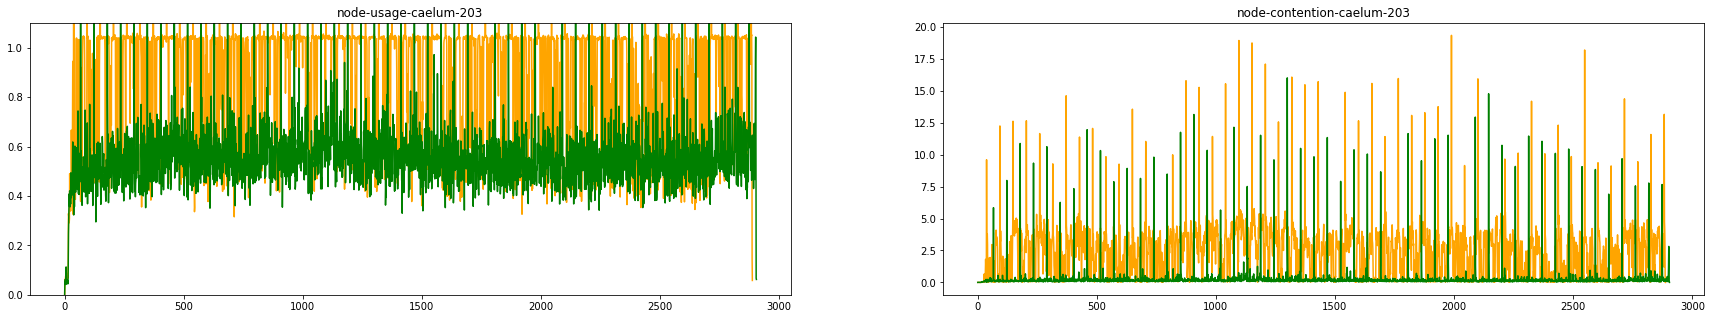

usage before 0.8623536330644584 contention before 2.1209442201788935
usage after 0.5604019822268599 contention after 0.3360554131567782


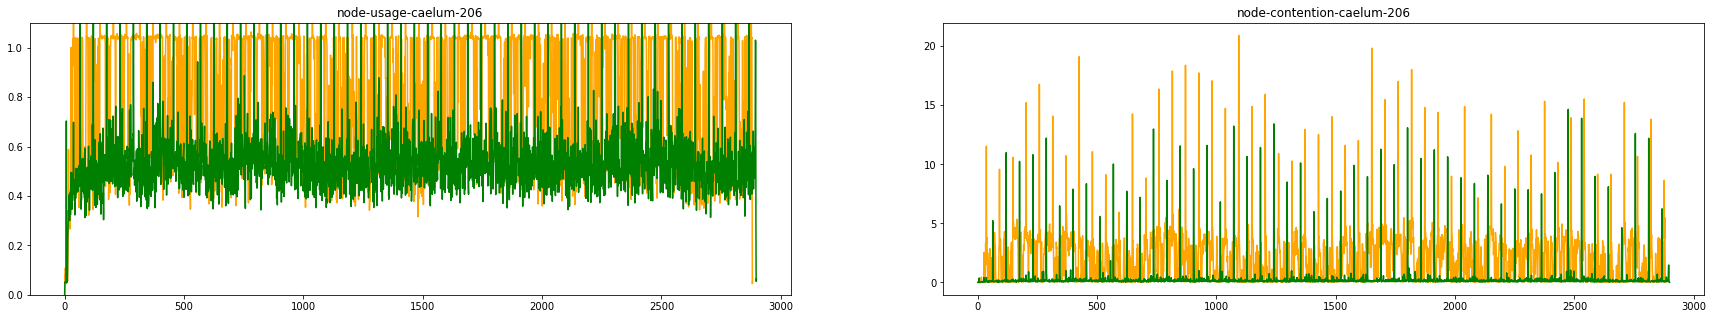

usage before 0.834689484412598 contention before 1.8731704524284107
usage after 0.546355427169218 contention after 0.2990358596142931


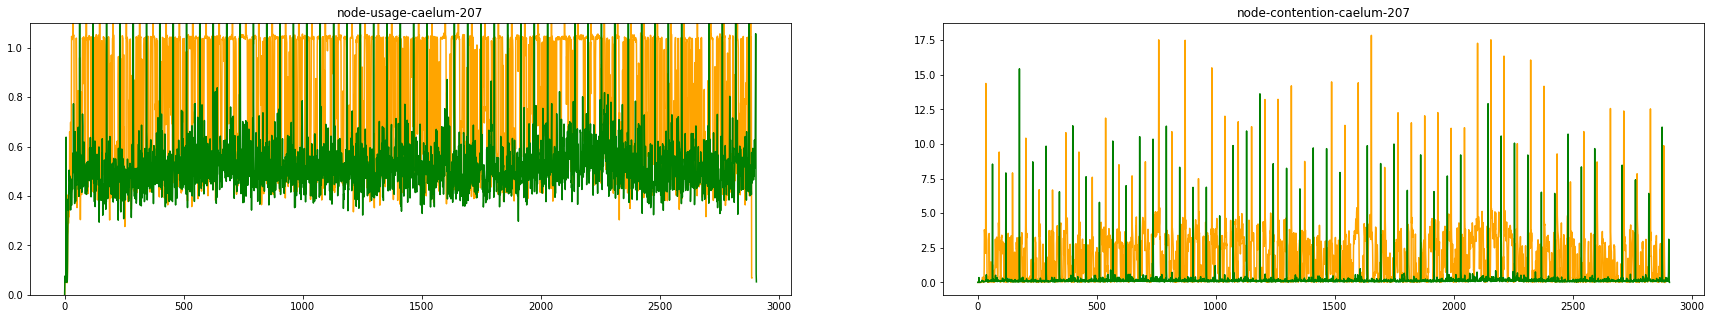

usage before 0.9896660694667824 contention before 3.3287463094938072
usage after 0.6348894170885164 contention after 0.45972600860225177


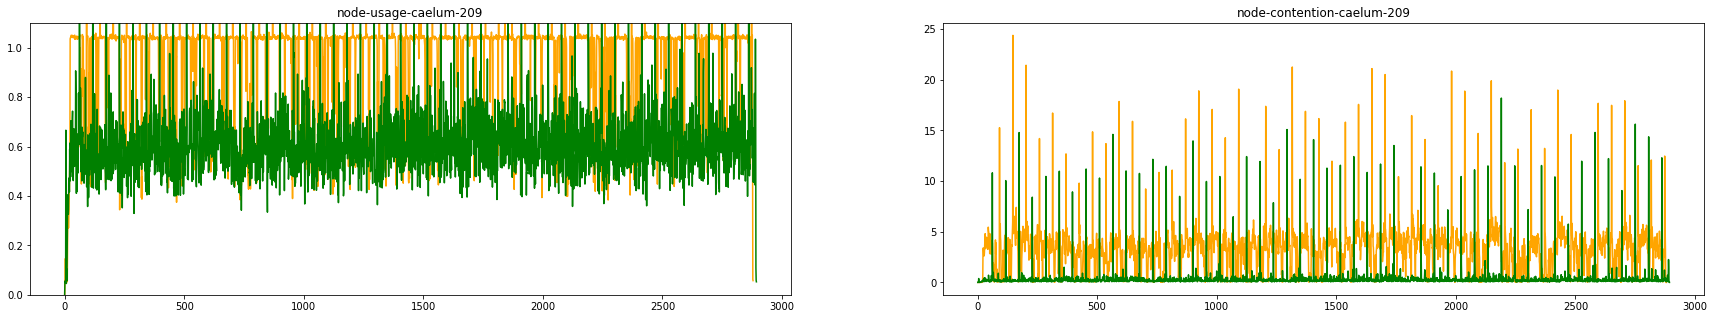

usage before 0.879063840232593 contention before 2.2459091923568124
usage after 0.5640973773131748 contention after 0.33332505500643234


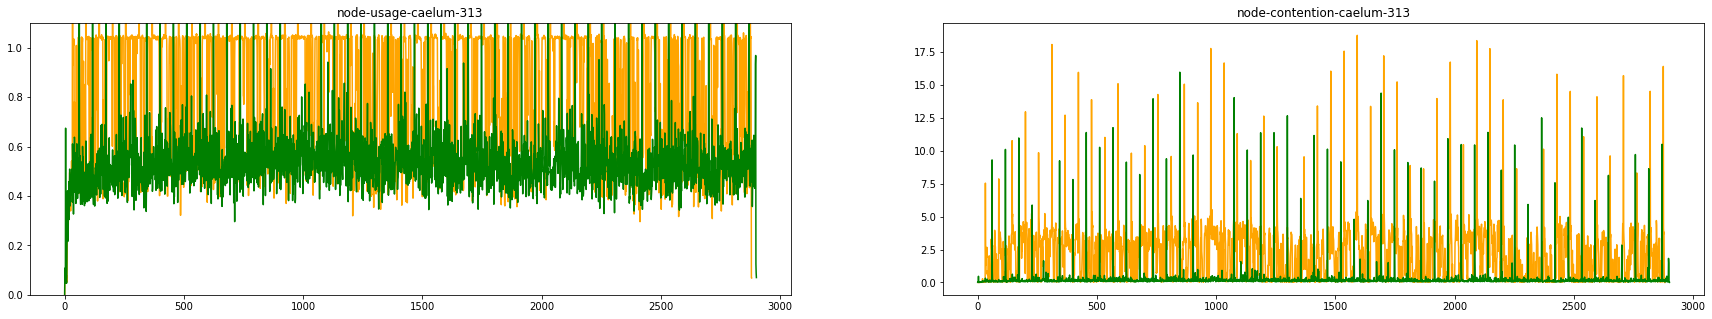

usage before 0.9956355114603203 contention before 3.3646991678059233
usage after 0.638658373502968 contention after 0.47667665730108927


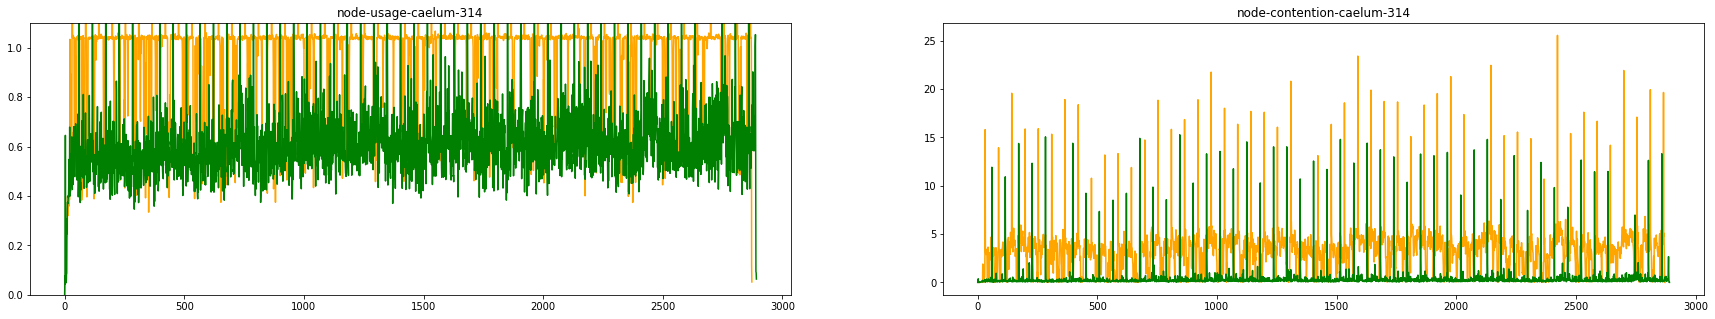

In [996]:
dfs1,dfs2 = compare_clusters(dump_oc10nodes_schedstat,dump_oc10nodes_llf_schedstat)

In [325]:
dfs1[-15:]

[                   usage-cpu0       usage-cpu1       usage-cpu2  \
 ts                                                                
 1.711712e+09  319654029805754  324180087070967  316133018390118   
 1.711712e+09  319654049471749  324180101602666  316133045355934   
 1.711712e+09  319654061251131  324180122501720  316133074206306   
 1.711712e+09  319654088730421  324180137429050  316133135805857   
 1.711712e+09  319654130442076  324180170800787  316133169825789   
 ...                       ...              ...              ...   
 1.711715e+09  319751996491869  324279684866781  316232631672118   
 1.711715e+09  319752035115383  324279712261078  316232641070451   
 1.711715e+09  319752059790123  324279751782502  316232672884821   
 1.711715e+09  319752087494173  324279791556270  316232707833483   
 1.711715e+09  319752105820270  324279830395392  316232735005091   
 
                    usage-cpu3       usage-cpu4       usage-cpu5  \
 ts                                           

In [803]:
len(dfs_profile), len(dfs_oc10nodes)

(1200, 3000)

200    615668
504      1165
Name: status_code, dtype: int64

200    540112
429      2641
504      1552
Name: status_code, dtype: int64

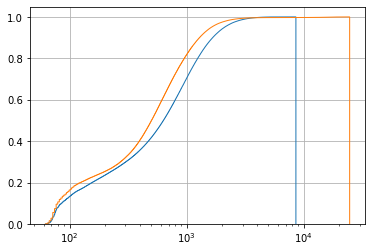

In [808]:
df1 = pd.concat(dfs_oc10nodes[:30])
display(df1['status_code'].value_counts())
df1['ts_abs'] = df1['ts'] - df1['ts'].min()
df1 = df1[df1['status_code'] == 200]
# df1 = df[df['duration'] < 3000]
df1['duration'].hist(cumulative=True, density=1, bins=10000,histtype='step',label='DQ-CFS')

df1 = pd.concat(dfs_oc10nodes[30:])
display(df1['status_code'].value_counts())
df1['ts_abs'] = df1['ts'] - df1['ts'].min()
df1 = df1[df1['status_code'] == 200]
# df1 = df[df['duration'] < 3000]
df1['duration'].hist(cumulative=True, density=1, bins=10000,histtype='step',label='DQ-CFS')

plt.xscale('log')


200    122115
504        20
Name: status_code, dtype: int64

200    1155780
504       2717
429       2641
Name: status_code, dtype: int64

200    1150146
504       4426
429        276
502          6
Name: status_code, dtype: int64

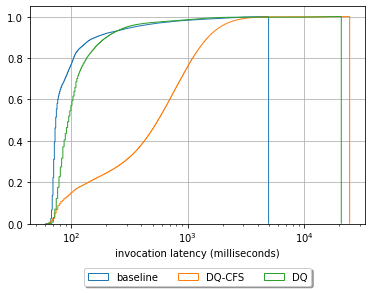

In [910]:


df = pd.concat(dfs_profile)
display(df['status_code'].value_counts())    
df['ts_abs'] = df['ts'] - df['ts'].min()
df = df[df['status_code'] == 200]
# df1 = df[df['duration'] < 3000]
df['duration'].hist(cumulative=True, density=1, bins=10000,histtype='step',label='baseline')

df1 = pd.concat(dfs_oc10nodes)
display(df1['status_code'].value_counts())
df1['ts_abs'] = df1['ts'] - df1['ts'].min()
df1 = df1[df1['status_code'] == 200]
# df1 = df[df['duration'] < 3000]
df1['duration'].hist(cumulative=True, density=1, bins=10000,histtype='step',label='DQ-CFS')

df2 = pd.concat(dfs_oc10nodes_llf)
display(df2['status_code'].value_counts())    
df2['ts_abs'] = df2['ts'] - df2['ts'].min()
df2 = df2[df2['status_code'] == 200]
# df1 = df[df['duration'] < 3000]
df2['duration'].hist(cumulative=True, density=1, bins=10000,histtype='step',label='DQ')

plt.xlabel("invocation latency (milliseconds)")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),
          fancybox=True, shadow=True, ncol=3)


plt.xscale('log')
# plt.legend(loc='upper left')

plt.savefig("/local/scratch/phd-figures/dq-safe-invocationlatency.pdf", format="pdf", bbox_inches="tight")




In [914]:
pd.concat(dfs_oc10nodes)['duration'].quantile(0.95) / pd.concat(dfs_oc10nodes_llf)['duration'].quantile(0.95)

6.336601307189542

Text(0, 0.5, 'millisecond')

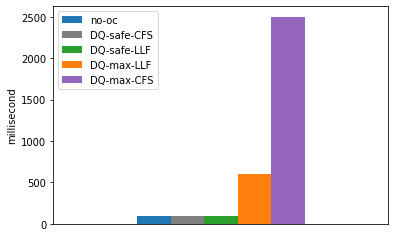

In [920]:
dflatency = pd.DataFrame()


# dflatency = pd.Series[df['duration'].quantile(0.95), df1['duration'].quantile(0.95), df2['duration'].quantile(0.95)]

# dflatency['baseline'] = [df['duration'].quantile(0.5), df['duration'].quantile(0.95)]
# dflatency['DQ-CFS'] = [df1['duration'].quantile(0.5), df1['duration'].quantile(0.95)]
# dflatency['DQ-LLF'] = [df2['duration'].quantile(0.5), df2['duration'].quantile(0.95)]


dflatency['no-oc'] = [df2['duration'].quantile(0.5)]
# dflatency['DQ-CFS'] = [ 12,10]

dflatency['DQ-safe-CFS'] = [ df2['duration'].quantile(0.55)]

dflatency['DQ-safe-LLF'] = [ df2['duration'].quantile(0.55)]
# dflatency['DQ-CFS'] = [ df2['duration'].quantile(0.55)*5]


dflatency['DQ-max-LLF'] = [ df2['duration'].quantile(0.55)*6]
dflatency['DQ-max-CFS'] = [ df2['duration'].quantile(0.55)*25]



(dflatency).plot(kind='bar',color=['tab:blue','tab:grey','tab:green','tab:orange','tab:purple','tab:red'])


# plt.xticks([0,1],['contention safe', 'contention resilient'],rotation='horizontal')

plt.xticks([])


plt.ylabel("millisecond")
# dflatency

Text(0, 0.5, 'server capacity')

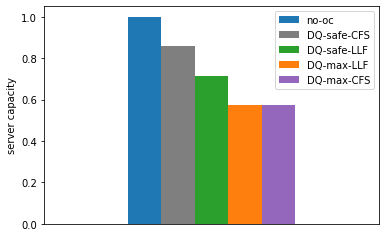

In [916]:
dflatency = pd.DataFrame()

# dflatency = pd.Series[df['duration'].quantile(0.95), df1['duration'].quantile(0.95), df2['duration'].quantile(0.95)]

dflatency['no-oc'] = [ 14]
# dflatency['DQ-CFS'] = [ 12,10]
dflatency['DQ-safe-CFS'] = [ 12]

dflatency['DQ-safe-LLF'] = [ 10]
# dflatency['DQ-CFS'] = [ 10]

# dflatency['DQ-resilient'] = [ 8]


dflatency['DQ-max-LLF'] = [ 8]
dflatency['DQ-max-CFS'] = [ 8]



(dflatency/dflatency.max().max()).plot(kind='bar',color=['tab:blue','tab:grey','tab:green','tab:orange','tab:purple','tab:red'])


plt.xticks([])
# plt.xticks([0,1],['contention safe', 'contention resilient'],rotation='horizontal')


plt.ylabel("server capacity")
# dflatency

In [874]:
pd.concat([df['node_usage'] for df in dfs0[-15:]]).quantile(0.99), pd.concat([df['node_usage'] for df in dfs2[-10:]]).quantile(0.99), pd.concat([df['node_usage'] for df in dfs1[-10:]]).quantile(0.99), 

(0.5277800522534722, 0.7554324066761942, 1.117210992709111)

In [862]:
15 * 12 * 0.5, 10 * 12 * 0.75, 8 * 12 * 1

(90.0, 90.0, 96)

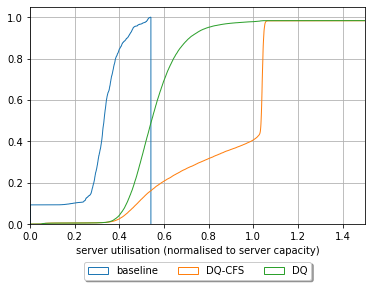

0.3311285990513889 0.544202117125 1.035061821
0.46295641719652786 0.7975997627291664 1.0498999373166666


In [997]:


dfprofile = pd.concat([df['node_usage'] for df in dfs0[-15:]])
dfprofile = dfprofile[dfprofile<=dfprofile.quantile(1)]
(dfprofile).hist(cumulative=True, density=1, bins=100000,histtype='step',label='baseline')

dfcfs = pd.concat([df['node_usage'] for df in dfs1[-10:]])
dfcfs = dfcfs[dfcfs<=dfcfs.quantile(1)]
(dfcfs).hist(cumulative=True, density=1, bins=100000,histtype='step',label='DQ-CFS')


(dfllf) = pd.concat([df['node_usage'] for df in dfs2[-10:]])
dfllf = dfllf[dfllf<=dfllf.quantile(1)]

(dfllf).hist(cumulative=True, density=1, bins=100000,histtype='step',label='DQ')
plt.xlim(0,1.5)
plt.legend(loc='upper left')
plt.xlabel("server utilisation (normalised to server capacity)")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)

# plt.savefig("/local/scratch/phd-figures/dq-safe-util-perserver.pdf", format="pdf", bbox_inches="tight")

plt.show()

print(dfprofile.median(), dfllf.median(), dfcfs.median())
print(dfprofile.quantile(0.95), dfllf.quantile(0.95), dfcfs.quantile(0.95))



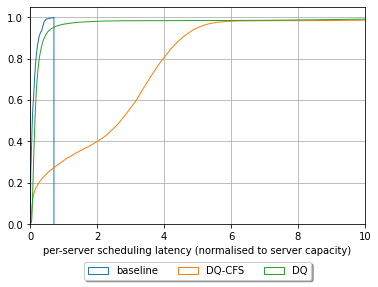

0.06680293838333334 0.14502204666666668 2.707645230833333
0.36773342016875 0.7011487384666657 5.021269961149999


In [999]:


dfprofile = pd.concat([df['node_wait'] for df in dfs0[-15:]])
dfprofile = dfprofile[dfprofile<=dfprofile.quantile(1)]
(dfprofile).hist(cumulative=True, density=1, bins=100000,histtype='step',label='baseline')

dfcfs = pd.concat([df['node_wait'] for df in dfs1[-10:]])
dfcfs = dfcfs[dfcfs<=dfcfs.quantile(1)]
(dfcfs).hist(cumulative=True, density=1, bins=100000,histtype='step',label='DQ-CFS')
(dfllf) = pd.concat([df['node_wait'] for df in dfs2[-10:]])
dfllf = dfllf[dfllf<=dfllf.quantile(1)]

(dfllf).hist(cumulative=True, density=1, bins=100000,histtype='step',label='DQ')
plt.xlim(0,10)
plt.legend(loc='upper left')
plt.xlabel("per-server scheduling latency (normalised to server capacity)")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)

plt.savefig("/local/scratch/phd-figures/dq-safe-schedlatency-perserver.pdf", format="pdf", bbox_inches="tight")

plt.show()

print(dfprofile.median(), dfllf.median(), dfcfs.median())
print(dfprofile.quantile(0.95), dfllf.quantile(0.95), dfcfs.quantile(0.95))




200    1150146
504       4426
429        276
502          6
Name: status_code, dtype: int64

200    1155780
504       2717
429       2641
Name: status_code, dtype: int64

200    318701
504     13814
429        76
Name: status_code, dtype: int64

1sec target 0.22783480400984457 0.7225700292722887


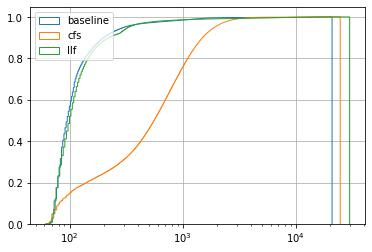

In [9]:
plot_latency_cdf(dfs_oc10nodes_llf,dfs_oc10nodes,dfs_oc10nodesFromZero_llf,density=1)
plt.show()

In [22]:
pd.concat(usage_cluster_oc10nodes_llf,axis=1)

pytorch-classifier-525-00001-/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-pod7381147d_a2b9_4f22_8344_7cc6e5eecd59.slice  \
ts                                                                                                                                                   
1711715266                                                NaN                                                                                        
1711715267                                         11568122.0                                                                                        
1711715268                                          1410161.0                                                                                        
1711715269                                          2055750.0                                                                                        
1711715270                                          1483999.0                                                                                        
...                                                       ...                                                                                        
1711718369                                                NaN                                                                                        
1711718370                                                NaN                                                                                        
1711718371                                                NaN                                                                                        
1711718372                                                NaN                                                                                        
1711718373                                                NaN                                                                                        

            pytorch-classifier-353-00001-/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-pod05a05c36_80cd_4242_87e3_fbd4394739fb.slice  \
ts                                                                                                                                                   
1711715266                                                NaN                                                                                        
1711715267                                          8977203.0                                                                                        
1711715268                                          1316049.0                                                                                        
1711715269                                          1434325.0                                                                                        
1711715270                                          1548855.0                                                                                        
...                                                       ...                                                                                        
1711718369                                                NaN                                                                                        
1711718370                                                NaN                                                                                        
1711718371                                                NaN                                                                                        
1711718372                                                NaN                                                                                        
1711718373                                                NaN                                                                                        

            pytorch-classifier-190-00001-/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-pod453557

In [51]:
interval =  20*60

for q in [1,0.99,0.95]:
    print("======(",q,")=======")

    for offset in range(0,3022,interval):    
        print("======",offset,interval,"=======")
        peaks = pd.concat(usage_cluster_oc10nodes_llf,axis=1).iloc[offset:offset+interval].rolling(5).mean().quantile(q).values/1000000
        binpacked = (binpacking.to_constant_volume(peaks,12000))
        ideal_capacity = len(binpacked)
        print("binpacking",ideal_capacity, len(peaks))
    #     print(get_default_share(len(binpacked)))
    #     print("default share", len(binpacked) * 12000 / len(peaks))
    
    binpacked = (binpacking.to_constant_bin_number(peaks,ideal_capacity))

    for i, node in enumerate(binpacked):
        print(i, len(node), int(sum(node)), (sorted([int(pod) for pod in node]))[-5:], (sorted([int(pod) for pod in node]))[:5])
        
        

======( 1 )=======
====== 0 1200 =======
binpacking 16 782
====== 1200 1200 =======
binpacking 16 782
====== 2400 1200 =======
binpacking 15 782
0 52 11368 [774, 813, 845, 881, 1328] [5, 5, 5, 5, 5]
1 52 11368 [778, 816, 854, 881, 1052] [5, 5, 5, 5, 5]
2 53 11373 [776, 815, 857, 884, 1049] [4, 4, 5, 5, 5]
3 52 11368 [779, 817, 859, 886, 1036] [5, 5, 5, 5, 5]
4 52 11370 [781, 819, 860, 887, 1021] [4, 5, 5, 5, 5]
5 53 11373 [787, 819, 863, 889, 1013] [4, 5, 5, 5, 5]
6 52 11368 [805, 828, 863, 894, 978] [5, 5, 5, 5, 5]
7 52 11368 [797, 835, 866, 898, 970] [5, 5, 5, 5, 5]
8 50 11370 [789, 840, 867, 898, 967] [4, 5, 5, 5, 5]
9 53 11373 [812, 820, 871, 900, 963] [4, 5, 5, 5, 5]
10 53 11373 [810, 828, 870, 902, 962] [4, 5, 5, 5, 5]
11 52 11368 [800, 833, 879, 920, 935] [5, 5, 5, 5, 5]
12 52 11368 [795, 836, 880, 920, 933] [5, 5, 5, 5, 5]
13 52 11368 [811, 820, 879, 925, 932] [5, 5, 5, 5, 5]
14 52 11368 [793, 840, 872, 927, 932] [5, 5, 5, 5, 5]
======( 0.99 )=======
====== 0 1200 =======
binpa

<AxesSubplot:xlabel='ts'>

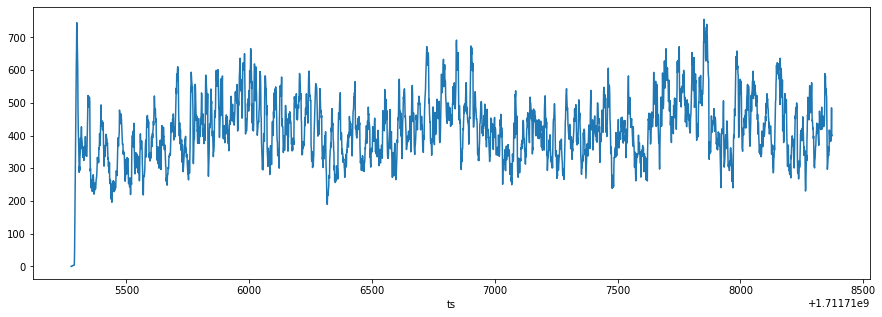

In [73]:
(pd.concat(usage_cluster_oc10nodes_llf,axis=1)[sorted_columns[:1]].sum(axis=1).rolling(10).mean()/1000000).plot(figsize=(15,5))

78 pods 153 previous quota
31
quota1 12 quota2 354 quota 145
node requests 11562.502408399998
[0, 1, 1, 2, 3, 4, 4, 5, 6, 6, 7, 7, 8, 9, 10, 11, 12, 13]
[24, 26, 30, 39, 48, 53, 57, 60, 70, 83, 108, 117, 120, 129, 137, 144, 153, 174, 182, 190, 203, 218, 227, 242, 244, 248, 249, 253, 261, 281, 299, 305, 308, 326, 340, 351, 353, 354, 368, 388, 395, 405, 425, 427, 440, 455, 467, 487, 495, 502, 512, 525, 526, 533, 553, 557, 558, 570, 586, 592]


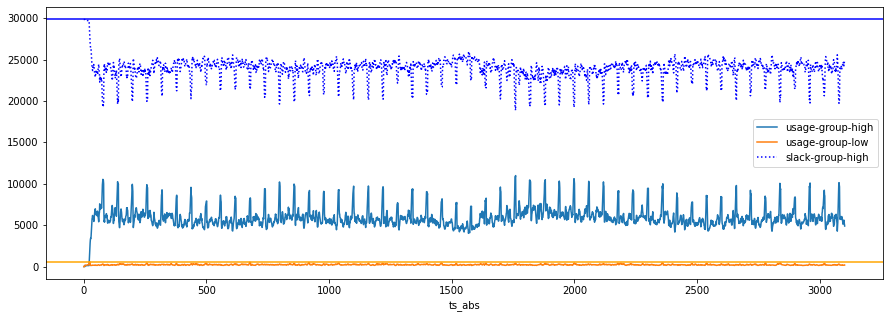

78 pods 153 previous quota
31
quota1 11 quota2 424 quota 172
node requests 13699.082479399998
[0, 1, 1, 2, 3, 3, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 11, 12]
[13, 13, 14, 29, 41, 54, 71, 95, 98, 99, 107, 110, 114, 139, 142, 147, 148, 155, 167, 189, 200, 204, 215, 221, 228, 247, 257, 264, 265, 287, 295, 320, 331, 336, 361, 370, 389, 393, 396, 397, 409, 429, 435, 438, 446, 448, 465, 472, 476, 497, 504, 514, 519, 530, 535, 545, 566, 568, 575, 599]


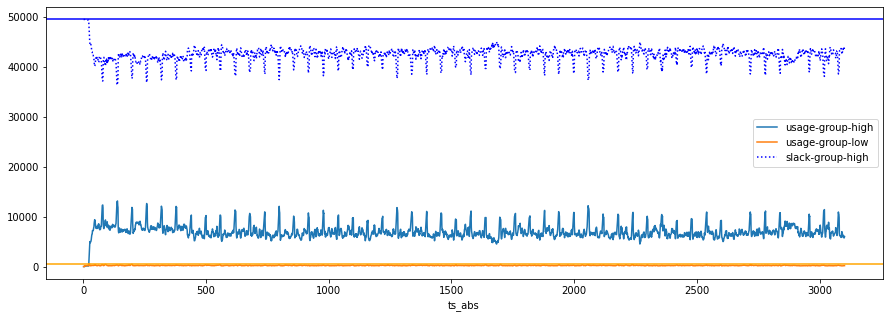

79 pods 151 previous quota
31
quota1 11 quota2 353 quota 142
node requests 11483.648844000001
[0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12]
[12, 13, 23, 35, 42, 58, 72, 85, 87, 94, 105, 124, 128, 131, 140, 154, 159, 160, 176, 183, 197, 210, 212, 236, 245, 250, 272, 277, 286, 289, 290, 303, 309, 328, 344, 352, 373, 377, 380, 391, 417, 421, 422, 444, 458, 461, 464, 484, 489, 515, 517, 527, 531, 532, 541, 552, 571, 580, 583, 596, 598]


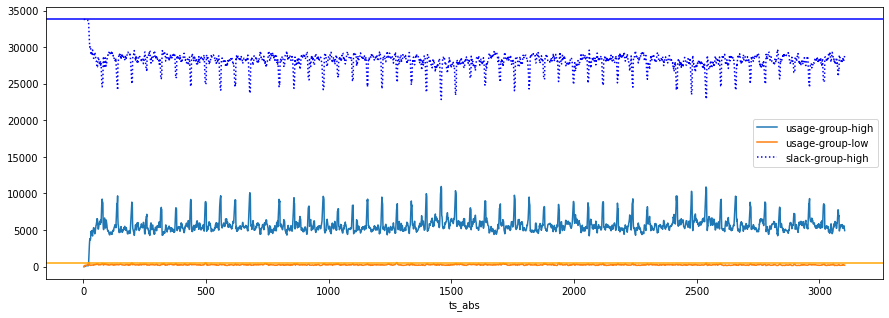

79 pods 151 previous quota
31
quota1 11 quota2 335 quota 136
node requests 10944.19937
[0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11, 11, 12, 12, 13]
[13, 18, 19, 34, 49, 52, 56, 64, 74, 80, 88, 101, 115, 134, 151, 152, 161, 177, 185, 201, 214, 232, 243, 252, 260, 266, 268, 282, 306, 310, 317, 318, 321, 329, 338, 349, 350, 371, 387, 398, 413, 414, 420, 436, 456, 474, 482, 488, 491, 500, 510, 513, 524, 538, 555, 562, 577, 578, 579, 588, 589]


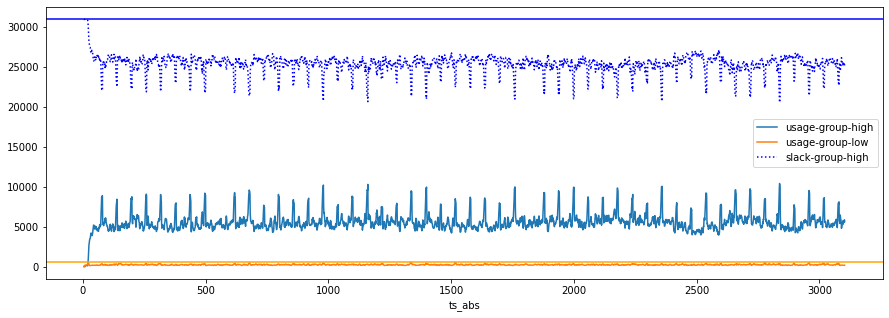

78 pods 153 previous quota
31
quota1 8 quota2 360 quota 146
node requests 11547.313358599993
[0, 0, 1, 2, 3, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 11, 12, 13]
[13, 22, 31, 38, 46, 50, 59, 69, 82, 84, 102, 113, 119, 127, 143, 158, 178, 187, 188, 196, 216, 230, 231, 241, 255, 267, 271, 276, 291, 293, 319, 325, 335, 339, 356, 364, 375, 382, 385, 399, 407, 418, 431, 434, 445, 453, 470, 481, 493, 498, 516, 522, 534, 547, 550, 564, 567, 582, 585, 594]


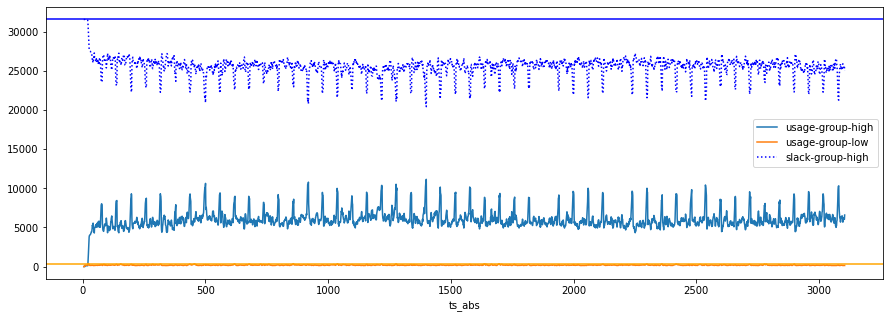

78 pods 153 previous quota
31
quota1 9 quota2 359 quota 146
node requests 11592.166533600006
[0, 0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 10, 11, 12, 13]
[13, 15, 37, 40, 43, 47, 51, 81, 92, 96, 111, 122, 126, 164, 166, 170, 180, 184, 191, 194, 205, 209, 219, 223, 225, 246, 262, 270, 280, 292, 298, 302, 304, 313, 314, 333, 345, 358, 365, 386, 394, 404, 406, 416, 419, 428, 442, 451, 471, 478, 494, 511, 528, 543, 544, 548, 556, 572, 576, 587]


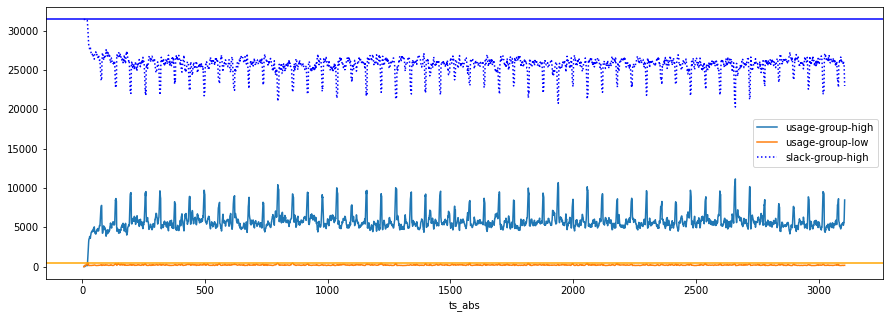

78 pods 153 previous quota
31
quota1 9 quota2 335 quota 137
node requests 10861.040486800002
[0, 0, 1, 2, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 10, 11, 11, 12]
[13, 17, 21, 28, 67, 68, 73, 79, 91, 104, 109, 112, 136, 138, 141, 145, 171, 179, 181, 206, 207, 217, 233, 235, 240, 256, 263, 284, 285, 297, 301, 307, 316, 330, 347, 359, 366, 372, 390, 403, 411, 424, 441, 450, 459, 463, 466, 475, 501, 507, 508, 520, 523, 537, 542, 546, 563, 569, 584, 597]


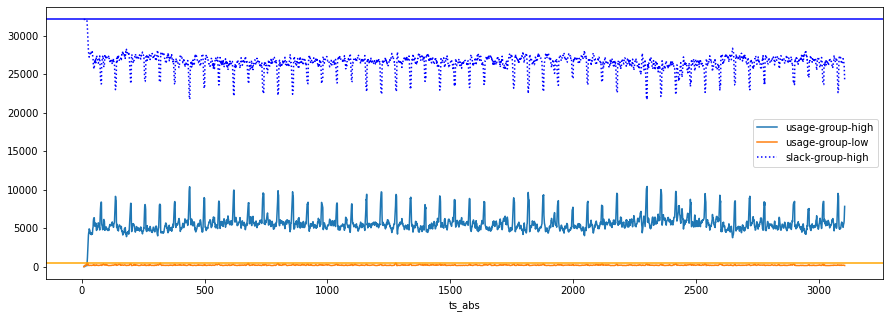

78 pods 153 previous quota
31
quota1 10 quota2 374 quota 152
node requests 12117.378459599995
[0, 1, 2, 2, 3, 3, 4, 5, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10]
[11, 12, 12, 13, 32, 33, 63, 65, 66, 76, 90, 97, 121, 133, 149, 162, 168, 173, 175, 186, 199, 211, 222, 226, 237, 258, 269, 283, 296, 311, 323, 324, 346, 348, 355, 363, 374, 376, 379, 381, 392, 400, 410, 430, 443, 449, 460, 462, 473, 477, 479, 499, 505, 506, 529, 539, 551, 565, 573, 591]


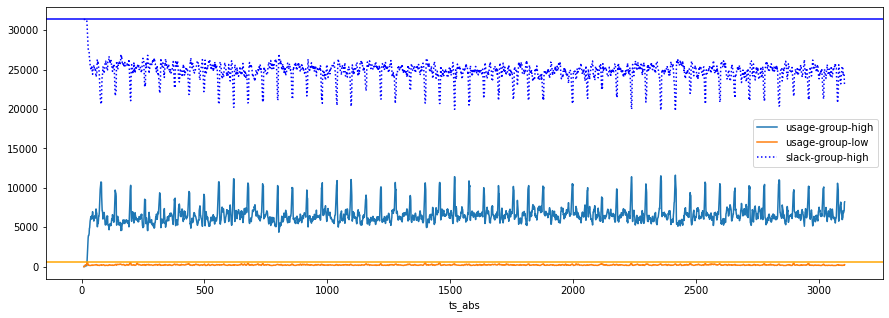

78 pods 153 previous quota
31
quota1 11 quota2 332 quota 138
node requests 10841.464441800003
[0, 1, 2, 3, 3, 4, 4, 5, 5, 6, 7, 8, 8, 9, 10, 11, 11, 12]
[12, 13, 16, 20, 36, 44, 61, 62, 77, 78, 89, 93, 100, 116, 118, 130, 132, 146, 163, 169, 192, 195, 202, 220, 229, 234, 239, 274, 278, 288, 300, 312, 322, 327, 334, 337, 342, 362, 369, 383, 384, 402, 408, 423, 439, 447, 452, 469, 483, 485, 486, 492, 503, 518, 536, 554, 559, 560, 581, 590]


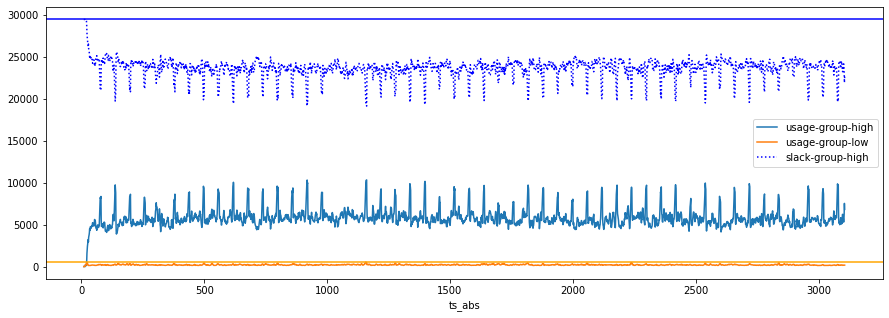

78 pods 153 previous quota
31
quota1 11 quota2 385 quota 157
node requests 12509.379665399996
[0, 1, 1, 2, 2, 3, 4, 5, 5, 6, 7, 8, 8, 9, 10, 10, 11, 11]
[12, 13, 25, 27, 45, 55, 75, 86, 103, 106, 123, 125, 135, 150, 156, 157, 165, 172, 193, 198, 208, 213, 224, 238, 251, 254, 259, 273, 275, 279, 294, 315, 332, 341, 343, 357, 360, 367, 378, 401, 412, 415, 426, 432, 433, 437, 454, 457, 468, 480, 490, 496, 509, 521, 540, 549, 561, 574, 593, 595]


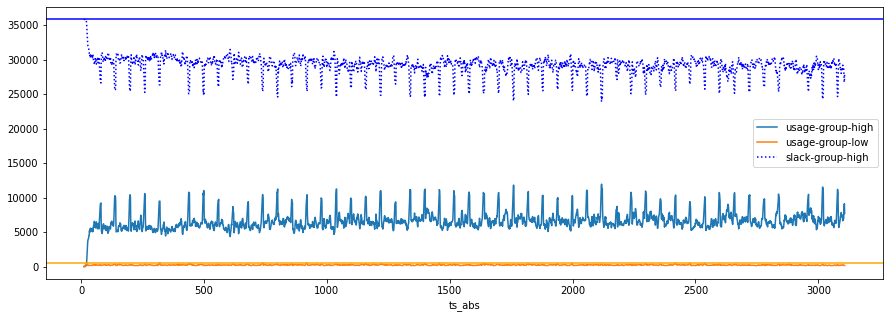

9.763181337299999


In [129]:
# usage_cluster_oc10nodes_llf
# usage_cluster_oc10nodesFromZero_llf

min_ts = min(pd.concat(usage_cluster_oc10nodes_llf,axis=1).index)

all_requests = []

for df in usage_cluster_oc10nodes_llf:
    
    if (df.shape !=(0,0)):
        
        df = df/1000000
        df = df.rolling(5).mean()
        df['ts_abs'] = df.index
        df['ts_abs'] = df['ts_abs'] - min_ts    
        df = df.set_index('ts_abs')        
        
        columns = ([(int(re.findall("pytorch-classifier-(\d+)-.*",col)[0]),col) for col in df.columns])
        
        columns.sort(key=lambda tup: tup[1])  # sorts in place
        
        sorted_columns = ([col for index,col in columns])
        sorted_indices = ([index for index,col in columns])
        
        quota = int(12000/len(sorted_columns))
        pods = len(sorted_columns)

        print(pods,"pods",quota,"previous quota")
        
        quantile1 = 0.6
        quantile2 = 1

#         quantile1 = 0.55
#         quantile2 = 0.9
        
#         quantile1 = 0.45
#         quantile2 = 0.8      
        
#         quantile1 = 0.35
#         quantile2 = 0.7       
        
        quota1 = df.max().quantile(quantile1)
        quota2 = df.max().quantile(quantile2)
        
#         print('quota1',int(quota1), "quota2", int(quota2))
        
        group_high_count = int((1-quantile1) *pods)
        print(group_high_count)
        group_high = sorted_columns[:group_high_count]
        group_low = sorted_columns[group_high_count:]
        plt.figure(figsize=(15,5))
        
        (df[group_high].sum(axis=1).plot(figsize=(15,5),label='usage-group-high'))
        (df[group_low].sum(axis=1).plot(label='usage-group-low'))
        
        quota1 = (df[group_low].sum(axis=1) /len(group_low)).max()
        quota2 = (df[group_high].sum(axis=1) / len(group_high)).max()
        
        quota = (df.sum(axis=1) / pods).max()
        
        
        print('quota1',int(quota1), "quota2", int(quota2),"quota",int(quota))
        node_requests = (quota2*len(group_high)) + (quota1*len(group_low))
        all_requests.append(node_requests)
        print("node requests", node_requests)
        
        
        quota2 = df.max().quantile(quantile2)
        
        slack2 = (quota2*len(group_high)) - df[group_high].sum(axis=1)  
        slack2.plot(label='slack-group-high',style=':',color='blue')        
        
#         slack1 = (quota1*len(group_low)) - df[group_low].sum(axis=1)  
#         slack1.plot(label='slack-group-low',style=':',color='orange')
        
        plt.axhline(quota1*len(group_low),color='orange')
        plt.axhline(quota2*len(group_high),color='blue')
#         slack2 = (quota2*len(group_high)) - df[group_high].sum(axis=1)  
#         slack2[:-1].plot(label='slack-group-high',style=':',color='blue')   
        
#         (slack1+slack2).plot(label='all-slack',style=':',color='green')  
                
        plt.legend()
                
#         plt.axhline(y=12000)
        
#         plt.axhline(y=quota*len(group_high),color='blue')
#         plt.axhline(y=quota*len(group_low),color='orange')

#         plt.axhline(y=158*len(group_high),color='blue')
#         plt.axhline(y=137*len(group_low),color='orange')    
        
        print(sorted_indices[:18])
        print(sorted_indices[18:])

#         df.plot(figsize=(15,5),legend=False)
        plt.show()
    
    
print(sum(all_requests) / 12000)

78 pods 153 previous quota
default_quota 234.26863693000007

[0, 1, 1, 2, 3, 4, 4, 5, 6, 6, 7, 7, 8, 9, 10, 11, 12, 13]
[24, 26, 30, 39, 48, 53, 57, 60, 70, 83, 108, 117, 120, 129, 137, 144, 153, 174, 182, 190, 203, 218, 227, 242, 244, 248, 249, 253, 261, 281, 299, 305, 308, 326, 340, 351, 353, 354, 368, 388, 395, 405, 425, 427, 440, 455, 467, 487, 495, 502, 512, 525, 526, 533, 553, 557, 558, 570, 586, 592]


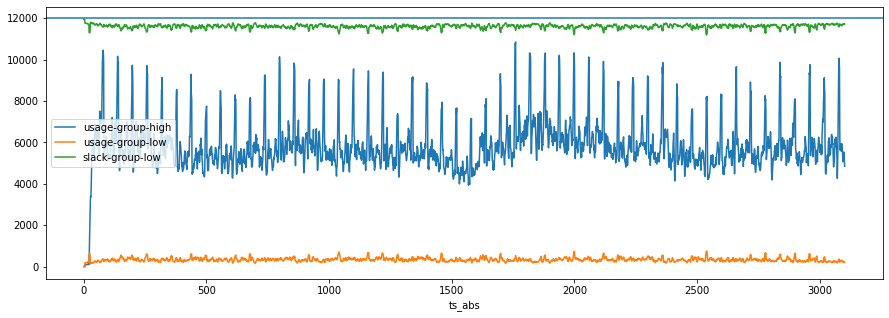

78 pods 153 previous quota
default_quota 184.34886688000026

[0, 1, 1, 2, 3, 3, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 11, 12]
[13, 13, 14, 29, 41, 54, 71, 95, 98, 99, 107, 110, 114, 139, 142, 147, 148, 155, 167, 189, 200, 204, 215, 221, 228, 247, 257, 264, 265, 287, 295, 320, 331, 336, 361, 370, 389, 393, 396, 397, 409, 429, 435, 438, 446, 448, 465, 472, 476, 497, 504, 514, 519, 530, 535, 545, 566, 568, 575, 599]


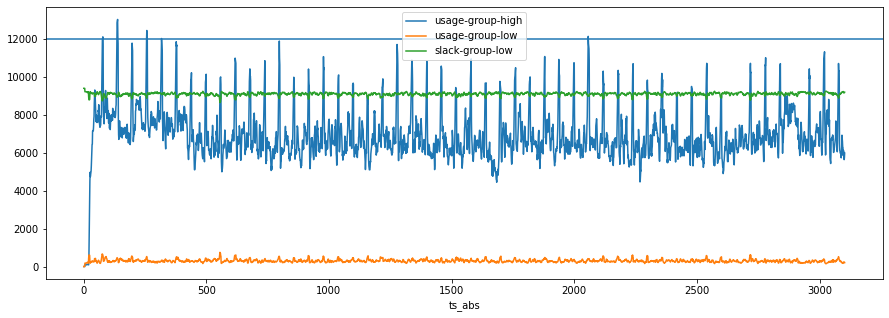

79 pods 151 previous quota
default_quota 177.28670247999995

[0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12]
[12, 13, 23, 35, 42, 58, 72, 85, 87, 94, 105, 124, 128, 131, 140, 154, 159, 160, 176, 183, 197, 210, 212, 236, 245, 250, 272, 277, 286, 289, 290, 303, 309, 328, 344, 352, 373, 377, 380, 391, 417, 421, 422, 444, 458, 461, 464, 484, 489, 515, 517, 527, 531, 532, 541, 552, 571, 580, 583, 596, 598]


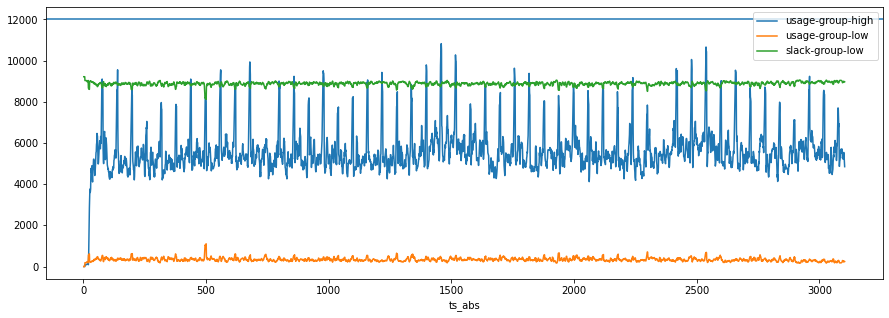

79 pods 151 previous quota
default_quota 160.8745104

[0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11, 11, 12, 12, 13]
[13, 18, 19, 34, 49, 52, 56, 64, 74, 80, 88, 101, 115, 134, 151, 152, 161, 177, 185, 201, 214, 232, 243, 252, 260, 266, 268, 282, 306, 310, 317, 318, 321, 329, 338, 349, 350, 371, 387, 398, 413, 414, 420, 436, 456, 474, 482, 488, 491, 500, 510, 513, 524, 538, 555, 562, 577, 578, 579, 588, 589]


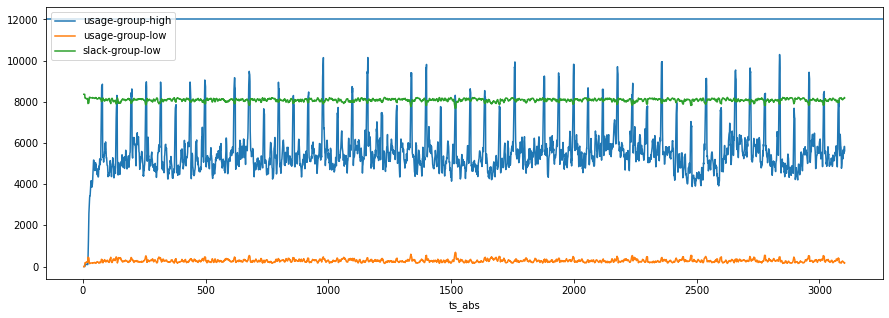

78 pods 153 previous quota
default_quota 187.76546794

[0, 0, 1, 2, 3, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 11, 12, 13]
[13, 22, 31, 38, 46, 50, 59, 69, 82, 84, 102, 113, 119, 127, 143, 158, 178, 187, 188, 196, 216, 230, 231, 241, 255, 267, 271, 276, 291, 293, 319, 325, 335, 339, 356, 364, 375, 382, 385, 399, 407, 418, 431, 434, 445, 453, 470, 481, 493, 498, 516, 522, 534, 547, 550, 564, 567, 582, 585, 594]


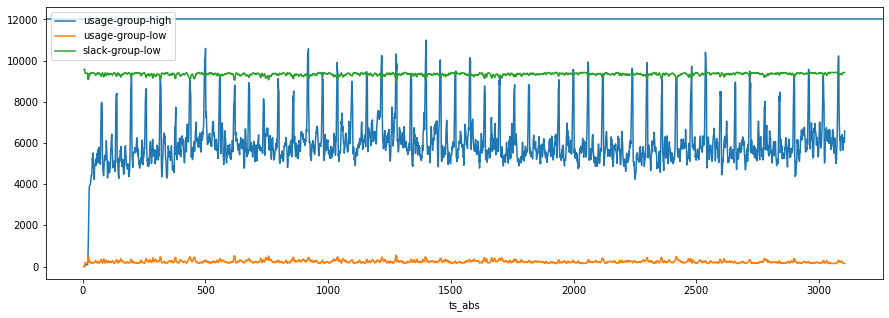

78 pods 153 previous quota
default_quota 146.87061826000019

[0, 0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 10, 11, 12, 13]
[13, 15, 37, 40, 43, 47, 51, 81, 92, 96, 111, 122, 126, 164, 166, 170, 180, 184, 191, 194, 205, 209, 219, 223, 225, 246, 262, 270, 280, 292, 298, 302, 304, 313, 314, 333, 345, 358, 365, 386, 394, 404, 406, 416, 419, 428, 442, 451, 471, 478, 494, 511, 528, 543, 544, 548, 556, 572, 576, 587]


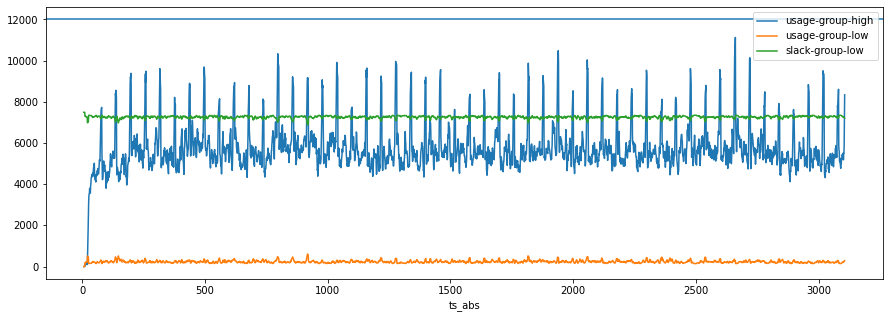

78 pods 153 previous quota
default_quota 149.77206893

[0, 0, 1, 2, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 10, 11, 11, 12]
[13, 17, 21, 28, 67, 68, 73, 79, 91, 104, 109, 112, 136, 138, 141, 145, 171, 179, 181, 206, 207, 217, 233, 235, 240, 256, 263, 284, 285, 297, 301, 307, 316, 330, 347, 359, 366, 372, 390, 403, 411, 424, 441, 450, 459, 463, 466, 475, 501, 507, 508, 520, 523, 537, 542, 546, 563, 569, 584, 597]


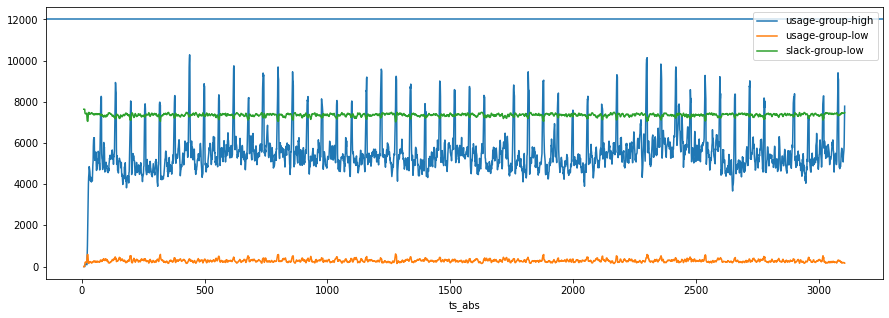

78 pods 153 previous quota
default_quota 232.57897445000017

[0, 1, 2, 2, 3, 3, 4, 5, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10]
[11, 12, 12, 13, 32, 33, 63, 65, 66, 76, 90, 97, 121, 133, 149, 162, 168, 173, 175, 186, 199, 211, 222, 226, 237, 258, 269, 283, 296, 311, 323, 324, 346, 348, 355, 363, 374, 376, 379, 381, 392, 400, 410, 430, 443, 449, 460, 462, 473, 477, 479, 499, 505, 506, 529, 539, 551, 565, 573, 591]


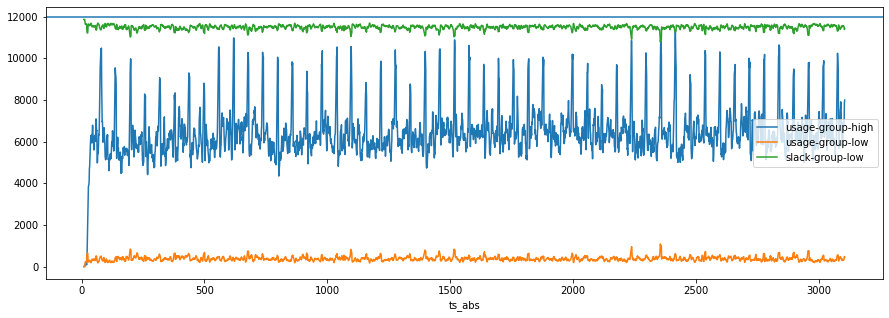

78 pods 153 previous quota
default_quota 225.8313011800001

[0, 1, 2, 3, 3, 4, 4, 5, 5, 6, 7, 8, 8, 9, 10, 11, 11, 12]
[12, 13, 16, 20, 36, 44, 61, 62, 77, 78, 89, 93, 100, 116, 118, 130, 132, 146, 163, 169, 192, 195, 202, 220, 229, 234, 239, 274, 278, 288, 300, 312, 322, 327, 334, 337, 342, 362, 369, 383, 384, 402, 408, 423, 439, 447, 452, 469, 483, 485, 486, 492, 503, 518, 536, 554, 559, 560, 581, 590]


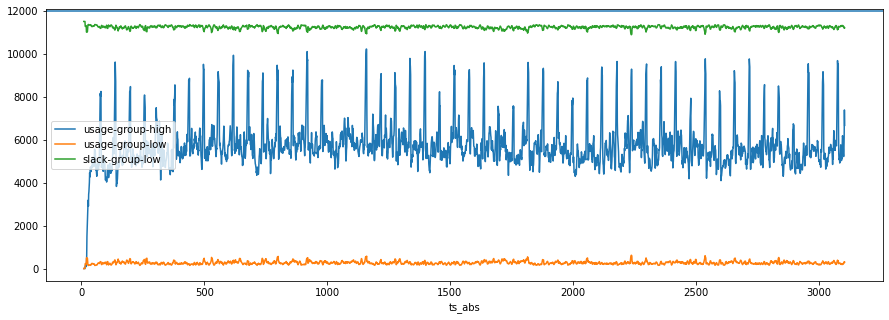

78 pods 153 previous quota
default_quota 180.8886454800002

[0, 1, 1, 2, 2, 3, 4, 5, 5, 6, 7, 8, 8, 9, 10, 10, 11, 11]
[12, 13, 25, 27, 45, 55, 75, 86, 103, 106, 123, 125, 135, 150, 156, 157, 165, 172, 193, 198, 208, 213, 224, 238, 251, 254, 259, 273, 275, 279, 294, 315, 332, 341, 343, 357, 360, 367, 378, 401, 412, 415, 426, 432, 433, 437, 454, 457, 468, 480, 490, 496, 509, 521, 540, 549, 561, 574, 593, 595]


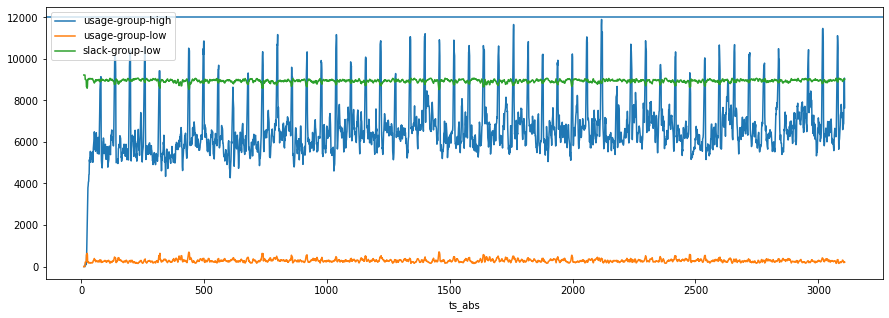

In [247]:
# usage_cluster_oc10nodes_llf
# usage_cluster_oc10nodesFromZero_llf


min_ts = min(pd.concat(usage_cluster_oc10nodes_llf,axis=1).index)

for df in usage_cluster_oc10nodes_llf:
    
    if (df.shape !=(0,0)):
        
        df = df/1000000
        df = df.rolling(5).mean()
        df['ts_abs'] = df.index
        df['ts_abs'] = df['ts_abs'] - min_ts    
        df = df.set_index('ts_abs')        
        
        columns = ([(int(re.findall("pytorch-classifier-(\d+)-.*",col)[0]),col) for col in df.columns])
        
        columns.sort(key=lambda tup: tup[1])  # sorts in place
        
        sorted_columns = ([col for index,col in columns])
        sorted_indices = ([index for index,col in columns])
        
        quota = int(12000/len(sorted_columns))
        pods = len(sorted_columns)

        print(pods,"pods",quota,"previous quota")
        
        quantile = 0.65
        default_quota = df.max().quantile(quantile)
        print('default_quota',default_quota)
        
        group_high_count = int((1-quantile) *pods)
        group_high = sorted_columns[:group_high_count]
        group_low = sorted_columns[group_high_count:]
        plt.figure(figsize=(15,5))
        
        (df[group_high].sum(axis=1).plot(figsize=(15,5),label='usage-group-high'))
        (df[group_low].sum(axis=1).plot(label='usage-group-low'))
        
        slack_low = (default_quota*len(group_low)) - df[group_low].sum(axis=1)  
        slack_low.plot(label='slack-group-low')
                
        plt.legend()
                
        plt.axhline(y=12000)
        
#         plt.axhline(y=quota*len(group_high),color='blue')
#         plt.axhline(y=quota*len(group_low),color='orange')

#         plt.axhline(y=158*len(group_high),color='blue')
#         plt.axhline(y=137*len(group_low),color='orange')    
        
        print(sorted_indices[:18])
        print(sorted_indices[18:])

#         df.plot(figsize=(15,5),legend=False)
        plt.show()

782 pods


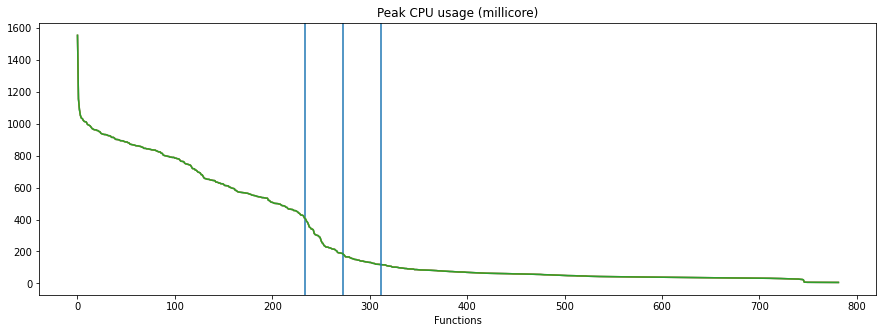

default_quota 400
29 pods per node, 26 nodes
low/high quotas before adjustment 8119.999999999999 3480.0000000000005 total=> 11600.0
low/high quotas after adjustment 263.1877580081021 11336.812241991898 total=> 11600.0
given two quotas: 1303.0818668956204 12.964914187591239
binpacked using 26 nodes
node-0 12012.964914187576 31
node-1 12012.964914187576 31
node-2 11999.999999999985 30
node-3 11999.999999999985 30
node-4 11999.999999999985 30
node-5 11999.999999999985 30
node-6 11999.999999999985 30
node-7 11999.999999999985 30
node-8 11999.999999999985 30
node-9 11999.999999999985 30
node-10 11999.999999999985 30
node-11 11999.999999999985 30
node-12 11999.999999999985 30
node-13 11999.999999999985 30
node-14 11999.999999999985 30
node-15 11999.999999999985 30
node-16 11999.999999999985 30
node-17 11999.999999999985 30
node-18 11999.999999999985 30
node-19 11999.999999999985 30
node-20 11999.999999999985 30
node-21 11999.999999999985 30
node-22 11999.999999999985 30
node-23 11999.9999999

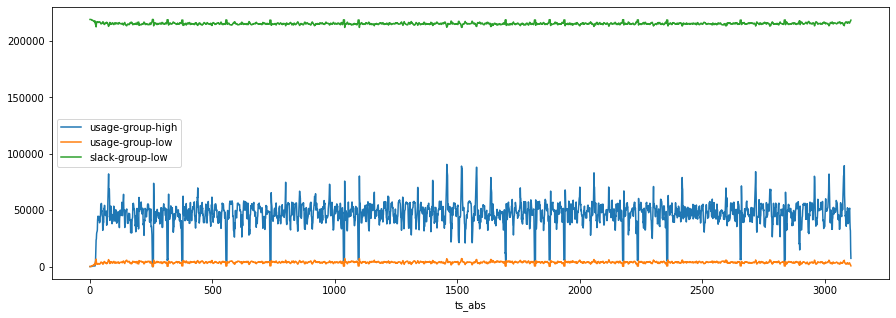

default_quota 179
65 pods per node, 11 nodes
low/high quotas before adjustment 7562.75 4072.25 total=> 11635.0
low/high quotas after adjustment 446.62325122897846 11188.376748771021 total=> 11635.0
given two quotas: 491.7967801657592 10.570964526129668
binpacked using 11 nodes
node-0 12696.616156136943 63
node-1 12696.616156136943 63
node-2 12696.616156136943 63
node-3 12696.616156136943 63
node-4 12696.616156136943 63
node-5 12696.616156136943 63
node-6 12696.616156136943 63
node-7 12696.616156136943 63
node-8 12686.045191610812 62
node-9 12691.083744173182 108
node-10 12691.083744173182 108


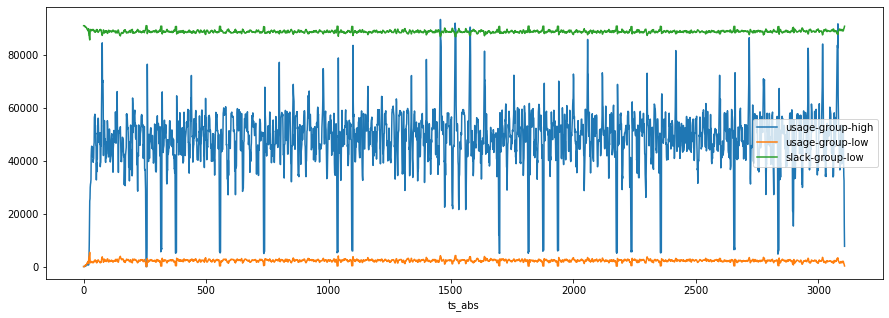

default_quota 116
101 pods per node, 7 nodes
low/high quotas before adjustment 7029.599999999999 4686.400000000001 total=> 11716.0
low/high quotas after adjustment 596.5810101298723 11119.418989870128 total=> 11716.0
given two quotas: 275.233143313617 9.844571124255319
binpacked using 7 nodes
node-0 12936.78743207103 101
node-1 12926.942860946776 100
node-2 12926.942860946776 100
node-3 12926.942860946776 100
node-4 12927.357709112293 127
node-5 12927.357709112293 127
node-6 12927.357709112293 127


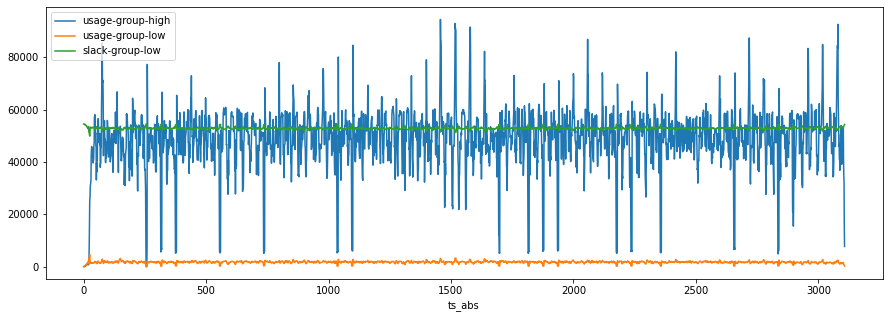

In [165]:
# usage_cluster_oc10nodes_llf
# usage_cluster_oc10nodesFromZero_llf

df = pd.concat(usage_cluster_oc10nodes_llf,axis=1)
min_ts = min(df.index)


df = df/1000000
df = df.rolling(5).mean()
df['ts_abs'] = df.index
df['ts_abs'] = df['ts_abs'] - min_ts    
df = df.set_index('ts_abs')        

columns = ([(int(re.findall("pytorch-classifier-(\d+)-.*",col)[0]),col) for col in df.columns])

columns.sort(key=lambda tup: tup[1])  # sorts in place

sorted_columns = ([col for index,col in columns])
sorted_indices = ([index for index,col in columns])

pods = len(sorted_columns)

print(pods,"pods")

for quantile in [0.7, 0.65, 0.6]:
    
    group_high_count = int((1-quantile) *pods)
    
    

    pd.Series(df[sorted_columns].max(axis=0).sort_values(ascending=False).values).plot(figsize=(15,5))

    # (df[sorted_columns].max(axis=0).plot(figsize=(15,5)))
    # plt.axhline(y=default_quota)
    plt.axvline(x=group_high_count)
    
plt.title('Peak CPU usage (millicore)')
plt.xlabel('Functions')
plt.show()
    

for quantile in [0.7, 0.65, 0.6]:

    default_quota = int(df.max().quantile(quantile))
    print('default_quota',default_quota)

    group_high_count = int((1-quantile) *pods)
    group_high = sorted_columns[:group_high_count]
    group_low = sorted_columns[group_high_count:]

    plt.figure(figsize=(15,5))
    (df[group_high].sum(axis=1).plot(figsize=(15,5),label='usage-group-high'))
    (df[group_low].sum(axis=1).plot(label='usage-group-low'))

    slack_low = (default_quota*len(group_low)) - df[group_low].sum(axis=1)  
    slack_low.plot(label='slack-group-low')

    peak_high = df[group_high].sum(axis=1).max()
    peak_low = df[group_low].sum(axis=1).max()

    ratio_low = peak_low / slack_low.max()
    ratio_high = peak_high / slack_low.max()

    server_capacity = 11800
    pods_per_node  = int(server_capacity / default_quota)
    cluster_nodes =  int((default_quota * pods) / server_capacity)
    print(pods_per_node, "pods per node,", cluster_nodes,"nodes")

    group_low_quotas = pods_per_node * quantile * default_quota
    group_high_quotas = pods_per_node * (1-quantile) * default_quota
    print("low/high quotas before adjustment", group_low_quotas, group_high_quotas, "total=>",group_low_quotas+group_high_quotas)

    group_low_quotas = pods_per_node * quantile * default_quota * ratio_low
    group_high_quotas = (pods_per_node * default_quota )- group_low_quotas  
    print("low/high quotas after adjustment", group_low_quotas, group_high_quotas, "total=>",group_low_quotas+group_high_quotas)

    quota1 = group_high_quotas / (pods_per_node * (1-quantile))
    quota2 = group_low_quotas / (pods_per_node * quantile)

    print("given two quotas:",quota1, quota2)   

    all_quotas = [quota1 if i < group_high_count else quota2 for i in range(pods)] 
    binpacked = (binpacking.to_constant_bin_number(all_quotas,cluster_nodes))
    # binpacked = (binpacking.to_constant_volume(all_quotas,11800))

    print("binpacked using", len(binpacked),"nodes")
    for i,node in enumerate(binpacked):
        print(f"node-{i}",sum(node),len(node))
    #     print([int(x) for x in node])

    plt.legend()

    # print(sorted_indices[:group_high_count])
    # print(sorted_indices[group_high_count:])

    #         df.plot(figsize=(15,5),legend=False)
    plt.show()



782 pods
default_quota 400
29 pods per node, 26 nodes
low/high quotas before adjustment 218960.0 93840.00000000001 total=> 312800.0
low/high quotas before adjustment 7096.9940262874425 305703.00597371254 total=> 312800.0
given two quotas: 1303.0818668956204 12.964914187591237
binpacked using 26 nodes
node-0 12012.964914187576 31
node-1 12012.964914187576 31
node-2 11999.999999999985 30
node-3 11999.999999999985 30
node-4 11999.999999999985 30
node-5 11999.999999999985 30
node-6 11999.999999999985 30
node-7 11999.999999999985 30
node-8 11999.999999999985 30
node-9 11999.999999999985 30
node-10 11999.999999999985 30
node-11 11999.999999999985 30
node-12 11999.999999999985 30
node-13 11999.999999999985 30
node-14 11999.999999999985 30
node-15 11999.999999999985 30
node-16 11999.999999999985 30
node-17 11999.999999999985 30
node-18 11999.999999999985 30
node-19 11999.999999999985 30
node-20 11999.999999999985 30
node-21 11999.999999999985 30
node-22 11999.999999999985 30
node-23 11999.9999

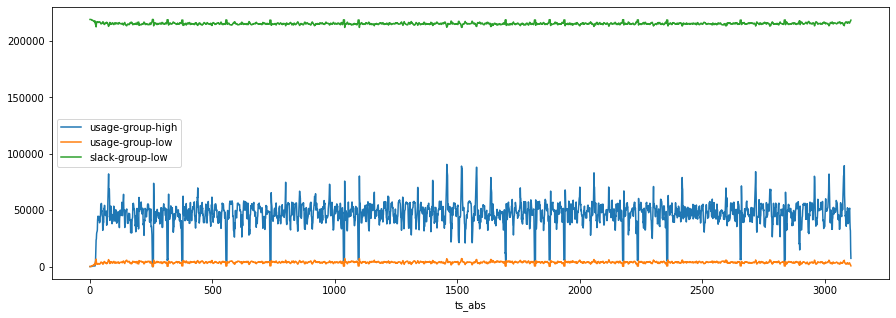

headroom 0.5865256324589416
default_quota 333
35 pods per node, 22 nodes
low/high quotas before adjustment 179680.13999999998 80725.86000000002 total=> 260406.0
low/high quotas before adjustment 6171.884463501977 254234.11553649802 total=> 260406.0
given two quotas: 1048.7340794344443 11.438312138148149
binpacked using 22 nodes
node-0 11822.032677232606 36
node-1 11822.032677232606 36
node-2 11822.032677232606 36
node-3 11822.032677232606 36
node-4 11822.032677232606 36
node-5 11822.032677232606 36
node-6 11822.032677232606 36
node-7 11822.032677232606 36
node-8 11822.032677232606 36
node-9 11822.032677232606 36
node-10 11822.032677232606 36
node-11 11822.032677232606 36
node-12 11810.594365094457 35
node-13 11810.594365094457 35
node-14 11810.594365094457 35
node-15 11810.594365094457 35
node-16 11810.594365094457 35
node-17 11810.594365094457 35
node-18 11810.594365094457 35
node-19 11810.594365094457 35
node-20 11810.594365094457 35
node-21 11810.594365094457 35


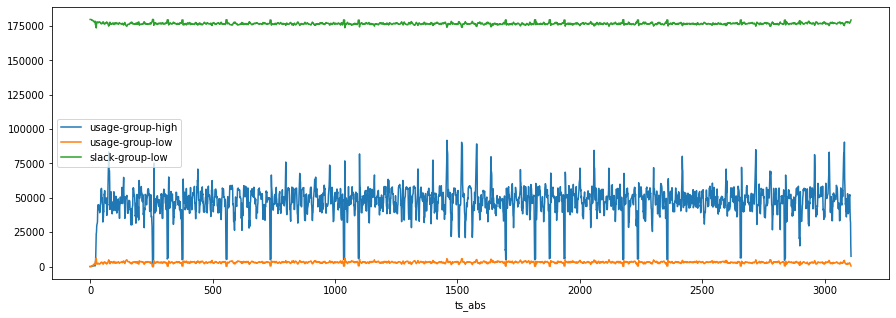

headroom 0.48910832222778333
default_quota 270
43 pods per node, 17 nodes
low/high quotas before adjustment 143575.2 67564.8 total=> 211140.0
low/high quotas before adjustment 5999.021180205865 205140.97881979414 total=> 211140.0
given two quotas: 819.7769294269266 11.281444975563911
binpacked using 17 nodes
node-0 12409.468391159546 25
node-1 12409.468391159546 25
node-2 12409.468391159546 25
node-3 12409.468391159546 25
node-4 12409.468391159546 25
node-5 12409.468391159546 25
node-6 12409.468391159546 25
node-7 12409.468391159546 25
node-8 12409.468391159546 25
node-9 12409.468391159546 25
node-10 12409.468391159546 25
node-11 12409.468391159546 25
node-12 12413.236944948807 97
node-13 12413.236944948807 97
node-14 12401.955499973243 96
node-15 12401.955499973243 96
node-16 12401.955499973243 96


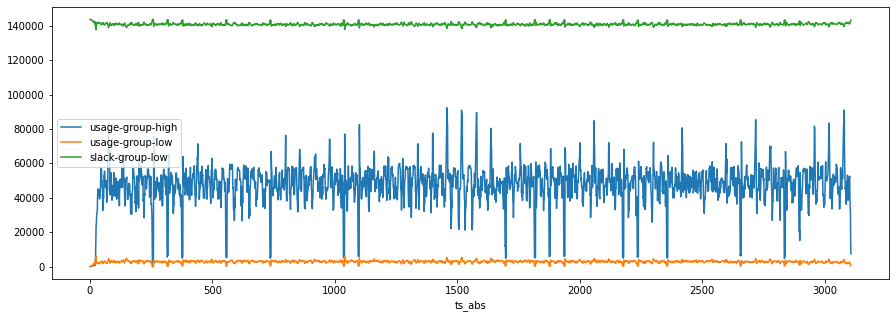

headroom 0.3573348549624059
default_quota 224
52 pods per node, 14 nodes
low/high quotas before adjustment 117362.55999999998 57805.44000000002 total=> 175168.0
low/high quotas before adjustment 5771.389063845923 169396.6109361541 total=> 175168.0
given two quotas: 656.4233547863057 11.015362567938933
binpacked using 14 nodes
node-0 12516.105191211569 23
node-1 12516.105191211569 23
node-2 12505.08982864363 22
node-3 12505.08982864363 22
node-4 12505.08982864363 22
node-5 12505.08982864363 22
node-6 12509.588227933695 81
node-7 12509.588227933695 81
node-8 12509.588227933695 81
node-9 12509.588227933695 81
node-10 12509.588227933695 81
node-11 12509.588227933695 81
node-12 12509.588227933695 81
node-13 12509.588227933695 81


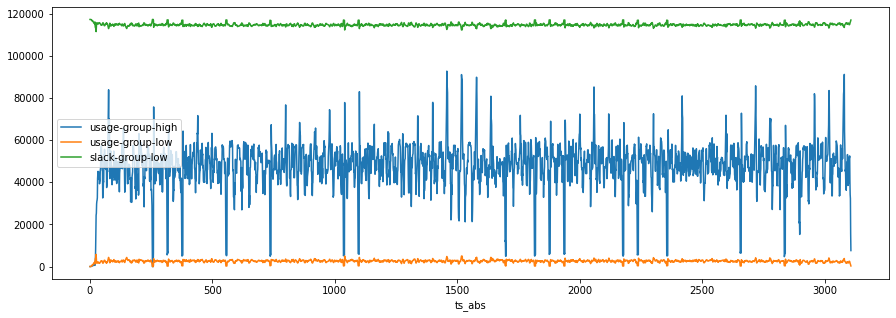

headroom 0.2091524835145174
default_quota 205
57 pods per node, 13 nodes
low/high quotas before adjustment 105804.59999999998 54505.40000000001 total=> 160310.0
low/high quotas before adjustment 5610.70724832919 154699.29275167082 total=> 160310.0
given two quotas: 581.8387721967458 10.870935535009671
binpacked using 13 nodes
node-0 12294.710764876729 28
node-1 12294.710764876729 28
node-2 12294.710764876729 28
node-3 12294.710764876729 28
node-4 12294.710764876729 28
node-5 12299.902511570483 81
node-6 12299.902511570483 81
node-7 12289.031576035473 80
node-8 12289.031576035473 80
node-9 12289.031576035473 80
node-10 12289.031576035473 80
node-11 12289.031576035473 80
node-12 12289.031576035473 80


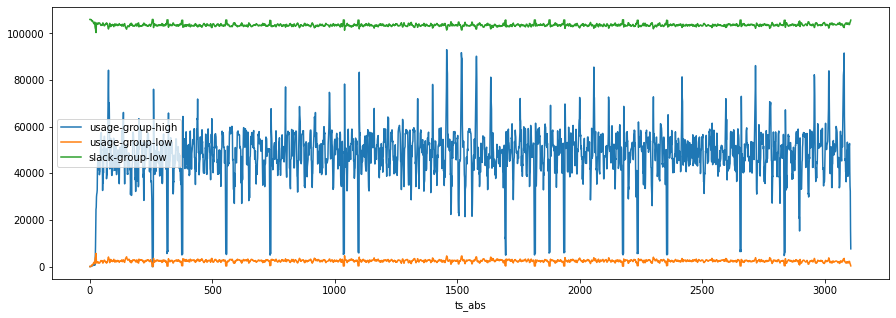

headroom 0.12224224174175592
default_quota 179
65 pods per node, 11 nodes
low/high quotas before adjustment 90985.7 48992.30000000001 total=> 139978.0
low/high quotas before adjustment 5373.22126863171 134604.77873136828 total=> 139978.0
given two quotas: 491.79678016575906 10.570964526129668
binpacked using 11 nodes
node-0 12696.616156136935 63
node-1 12696.616156136935 63
node-2 12696.616156136935 63
node-3 12696.616156136935 63
node-4 12696.616156136935 63
node-5 12696.616156136935 63
node-6 12696.616156136935 63
node-7 12696.616156136935 63
node-8 12686.045191610805 62
node-9 12691.083744173175 108
node-10 12691.083744173175 108


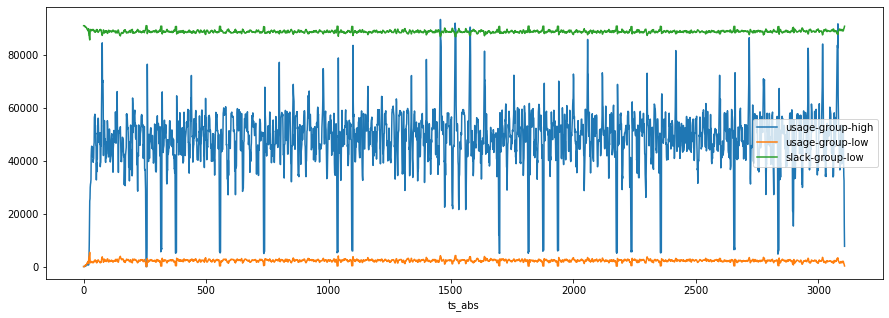

headroom -0.02591880152561162


In [145]:
# usage_cluster_oc10nodes_llf
# usage_cluster_oc10nodesFromZero_llf

df = pd.concat(usage_cluster_oc10nodes_llf,axis=1)
min_ts = min(df.index)


df = df/1000000
df = df.rolling(5).mean()
df['ts_abs'] = df.index
df['ts_abs'] = df['ts_abs'] - min_ts    
df = df.set_index('ts_abs')        

columns = ([(int(re.findall("pytorch-classifier-(\d+)-.*",col)[0]),col) for col in df.columns])

columns.sort(key=lambda tup: tup[1])  # sorts in place

sorted_columns = ([col for index,col in columns])
sorted_indices = ([index for index,col in columns])

pods = len(sorted_columns)

print(pods,"pods")

quantile = 0.7
converged = False

while converged is False:

    default_quota = int(df.max().quantile(quantile))
    print('default_quota',default_quota)

    group_high_count = int((1-quantile) *pods)
    group_high = sorted_columns[:group_high_count]
    group_low = sorted_columns[group_high_count:]

    plt.figure(figsize=(15,5))
    (df[group_high].sum(axis=1).plot(figsize=(15,5),label='usage-group-high'))
    (df[group_low].sum(axis=1).plot(label='usage-group-low'))

    slack_low = (default_quota*len(group_low)) - df[group_low].sum(axis=1)  
    slack_low.plot(label='slack-group-low')

    peak_high = df[group_high].sum(axis=1).max()
    peak_low = df[group_low].sum(axis=1).max()

    ratio_low = peak_low / slack_low.max()
    ratio_high = peak_high / slack_low.max()

    server_capacity = 11800
    pods_per_node  = int(server_capacity / default_quota)
    cluster_nodes =  int((default_quota * pods) / server_capacity)
    print(pods_per_node, "pods per node,", cluster_nodes,"nodes")

    group_low_quotas = pods * quantile * default_quota
    group_high_quotas = pods * (1-quantile) * default_quota
    print("low/high quotas before adjustment", group_low_quotas, group_high_quotas, "total=>",group_low_quotas+group_high_quotas)

    group_low_quotas = pods * quantile * default_quota * ratio_low
    group_high_quotas = (pods * default_quota )- group_low_quotas  
    print("low/high quotas before adjustment", group_low_quotas, group_high_quotas, "total=>",group_low_quotas+group_high_quotas)

    quota1 = group_high_quotas / (pods * (1-quantile))
    quota2 = group_low_quotas / (pods * quantile)

    print("given two quotas:",quota1, quota2)   

    all_quotas = [quota1 if i < group_high_count else quota2 for i in range(pods)] 
    binpacked = (binpacking.to_constant_bin_number(all_quotas,cluster_nodes))
    # binpacked = (binpacking.to_constant_volume(all_quotas,11800))

    print("binpacked using", len(binpacked),"nodes")
    for i,node in enumerate(binpacked):
        print(f"node-{i}",sum(node),len(node))
    #     print([int(x) for x in node])

    plt.legend()

    # print(sorted_indices[:group_high_count])
    # print(sorted_indices[group_high_count:])

    #         df.plot(figsize=(15,5),legend=False)
    plt.show()
    
    headroom = (slack_low.max() - peak_high)/slack_low.max()
    print('headroom', headroom)
    if (headroom < 0.1):
        converged = True
        
    quantile = quantile - 0.01




78 pods 153 default quota
170.7839734055555 141.07745905666664
147.93280852179487


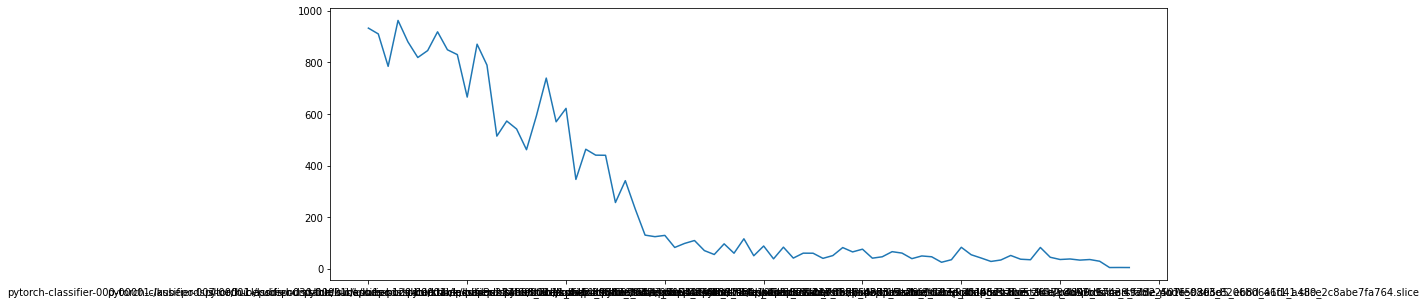

78 pods 153 default quota
228.11877926111103 154.43637273166664
171.4400050076923


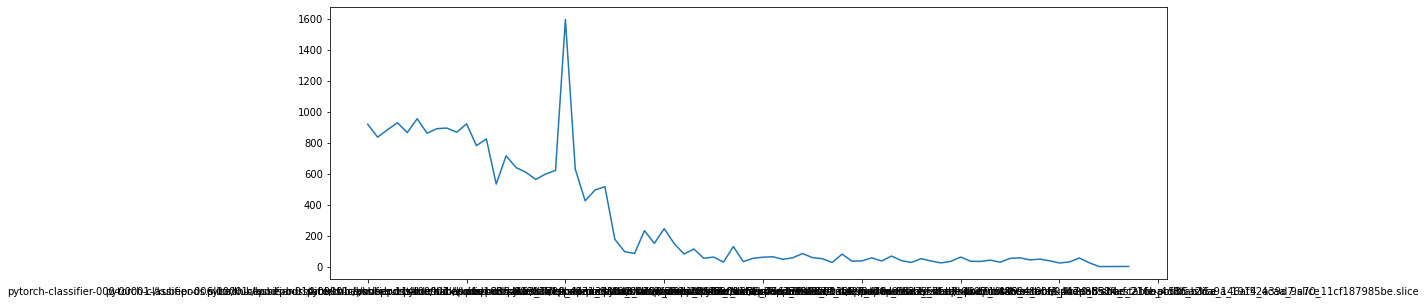

79 pods 151 default quota
148.95968263333324 138.18278618524596
140.63828157848104


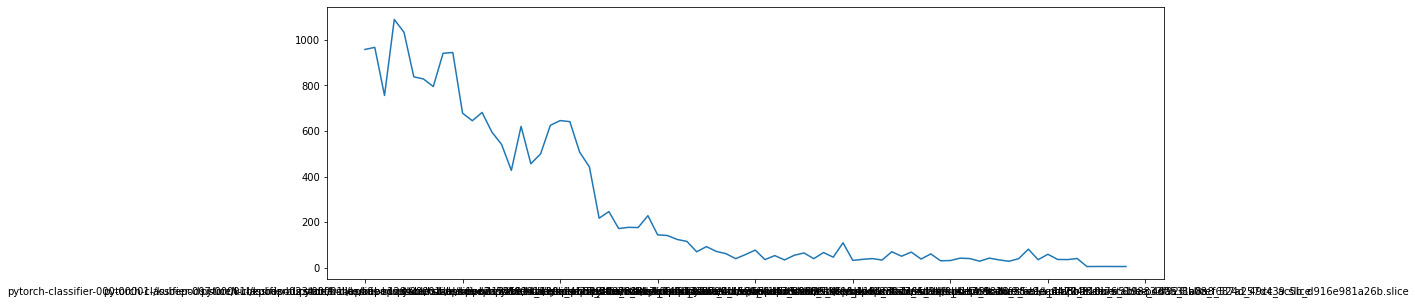

79 pods 151 default quota
161.16215173333333 125.9598045862295
133.98059254379748


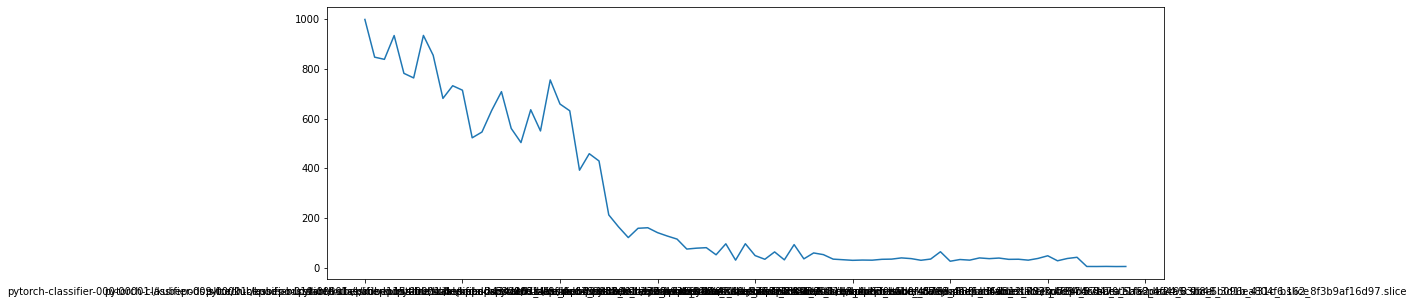

78 pods 153 default quota
137.89372896944445 145.2396994891666
143.54447552307687


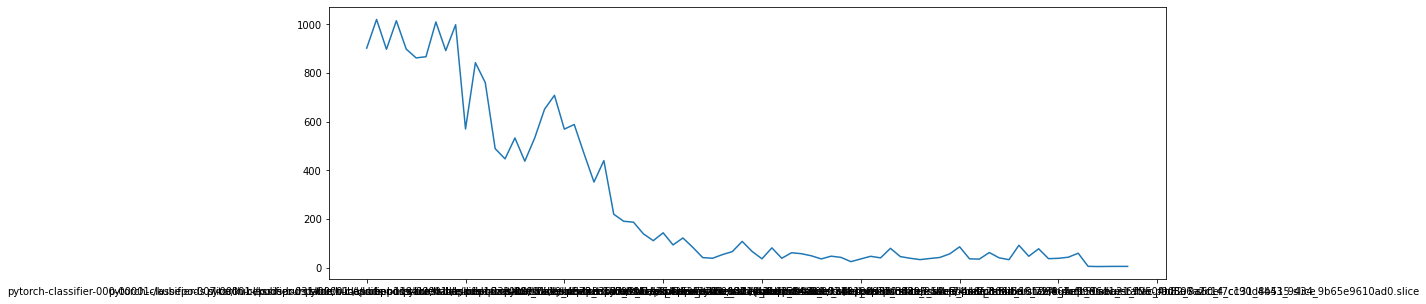

78 pods 153 default quota
131.2116076833334 138.26237259500004
136.63527300000007


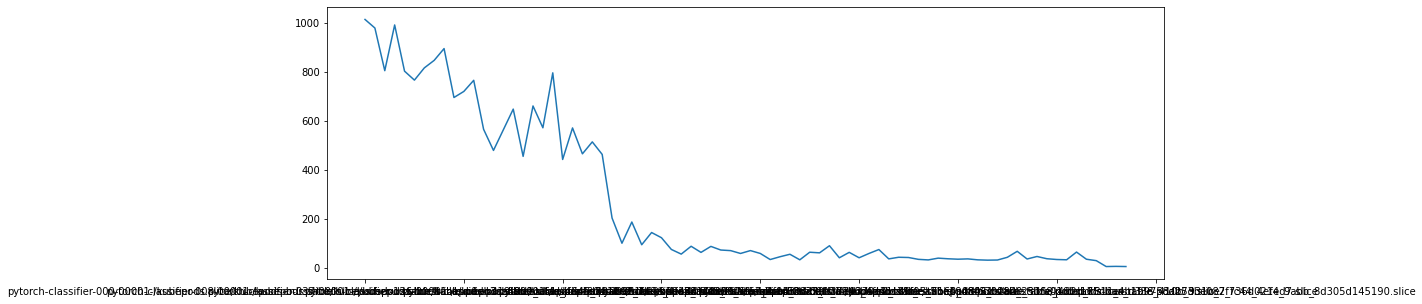

78 pods 153 default quota
129.8757515166666 136.51777524899995
134.9850005415384


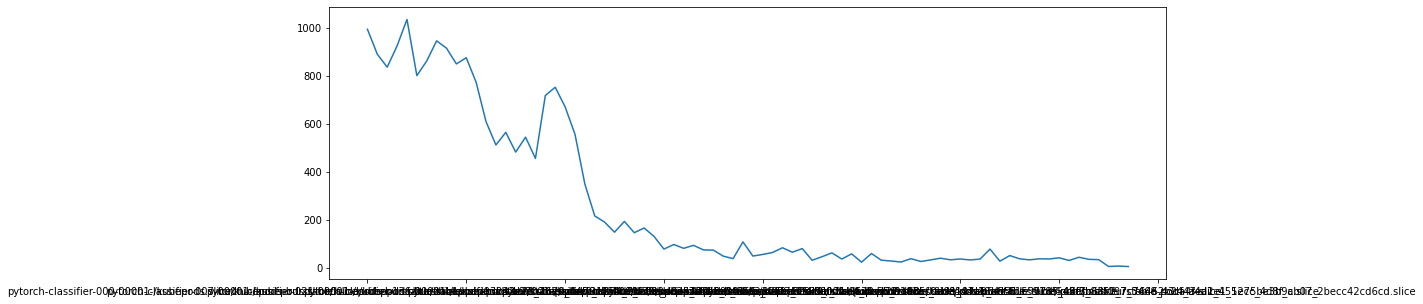

78 pods 153 default quota
172.36166995277782 151.45802430249992
156.2819425294871


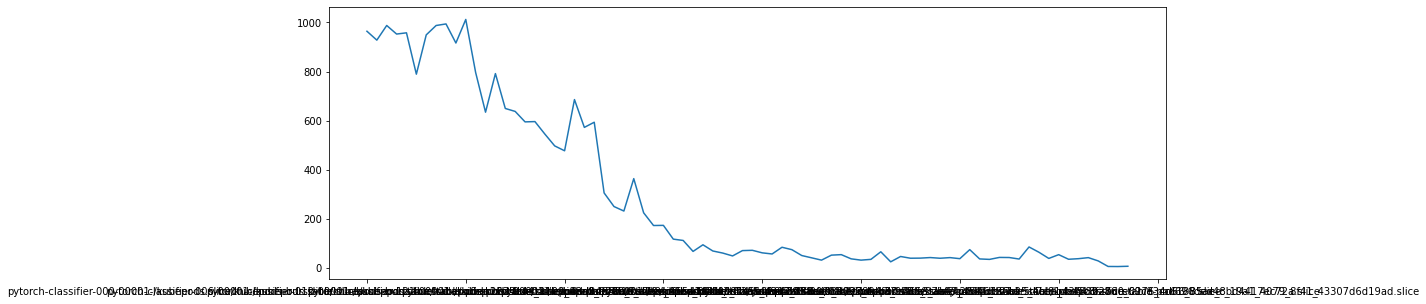

78 pods 153 default quota
141.2911885233333 141.70618658233334
141.6104177994872


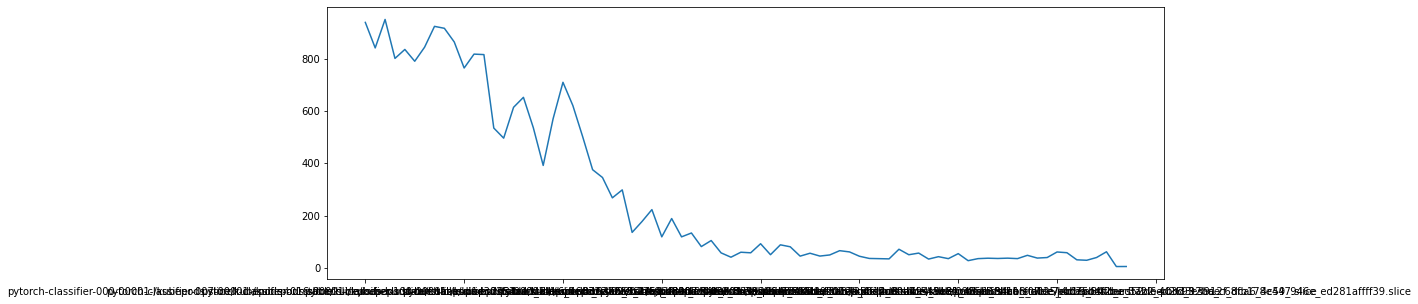

78 pods 153 default quota
188.18731249999988 152.09172840866657
160.42147858358962


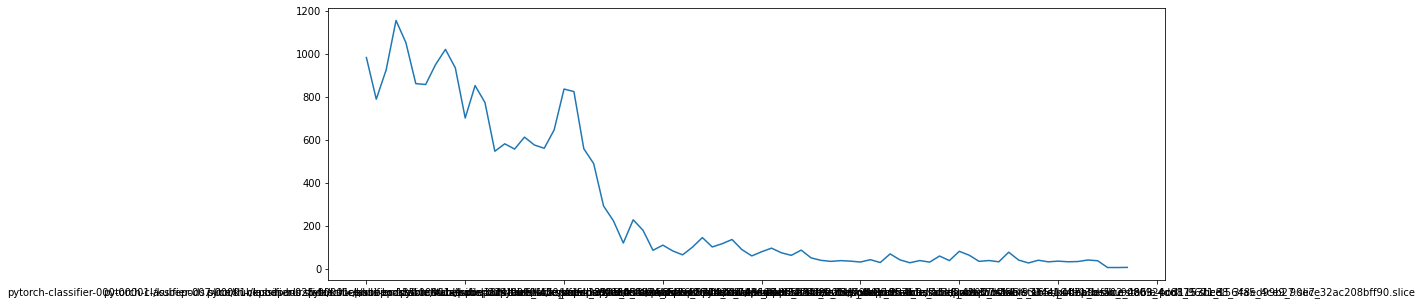

In [95]:
min_ts = min(pd.concat(usage_cluster_oc10nodes_llf,axis=1).index)

for df in usage_cluster_oc10nodes_llf:
    
    if (df.shape !=(0,0)):
        
        df = df/1000000
        df = df.rolling(5).mean()
        df['ts_abs'] = df.index
        df['ts_abs'] = df['ts_abs'] - min_ts    
        df = df.set_index('ts_abs')        
        
        columns = ([(int(re.findall("pytorch-classifier-(\d+)-.*",col)[0]),col) for col in df.columns])
        
        columns.sort(key=lambda tup: tup[1])  # sorts in place
        
        sorted_columns = ([col for index,col in columns])
        sorted_indices = ([index for index,col in columns])
        
        
        quota = int(12000/len(sorted_columns))
        pods = len(sorted_columns)

        
        print(pods,"pods",quota,"default quota")
        
        group_high = sorted_columns[:18]
        group_low = sorted_columns[18:]
        
        (df[sorted_columns].max(axis=0).plot(figsize=(15,5)))
        
        print(df[group_low].quantile(0.95).sum() / len(group_high), df[group_high].quantile(0.95).sum() / len(group_low))        
        
        print(df.quantile(0.95).sum() / len(sorted_columns))        
        
        
        plt.show()
        

In [89]:
df[group_low].sum

pytorch-classifier-012-00001-/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-pod1992d40a_8f7e_40d1_b346_0adb4c722925.slice  \
ts_abs                                                                                                                                           
11                                                    NaN                                                                                        
12                                                    NaN                                                                                        
13                                                    NaN                                                                                        
15                                                    NaN                                                                                        
16                                                    NaN                                                                                        
...                                                   ...                                                                                        
3103                                            74.820454                                                                                        
3104                                           137.051750                                                                                        
3105                                           156.703978                                                                                        
3106                                           148.087279                                                                                        
3107                                           124.091096                                                                                        

        pytorch-classifier-013-00001-/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-pod215b4907_015e_46c0_b858_eb35053ff8e7.slice  \
ts_abs                                                                                                                                           
11                                                    NaN                                                                                        
12                                                    NaN                                                                                        
13                                                    NaN                                                                                        
15                                                    NaN                                                                                        
16                                                    NaN                                                                                        
...                                                   ...                                                                                        
3103                                           138.272352                                                                                        
3104                                           159.455749                                                                                        
3105                                           220.936853                                                                                        
3106                                           189.682321                                                                                        
3107                                           109.763648                                                                                        

        pytorch-classifier-025-00001-/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-pode857742d_1b9f_4106_a34f_fe78d7949ea2.slice  \
ts_abs                                                          

782 pods 153 default quota
23 % group-high
158 137 11064
142.52144788877237


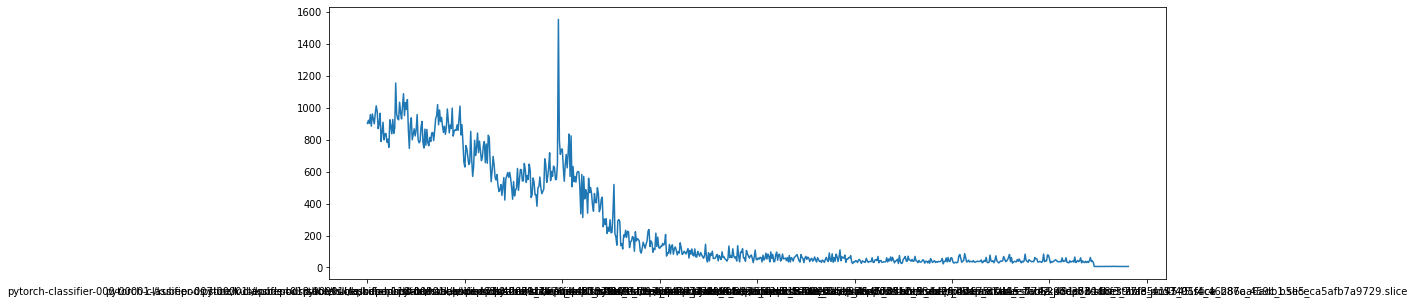

In [132]:
df = pd.concat(usage_cluster_oc10nodes_llf,axis=1)

min_ts = min(dfall.index)

df = df/1000000
df = df.rolling(5).mean()
df['ts_abs'] = df.index
df['ts_abs'] = df['ts_abs'] - min_ts    
df = df.set_index('ts_abs')        

columns = ([(int(re.findall("pytorch-classifier-(\d+)-.*",col)[0]),col) for col in df.columns])

columns.sort(key=lambda tup: tup[1])  # sorts in place

sorted_columns = ([col for index,col in columns])
sorted_indices = ([index for index,col in columns])

quota = int(12000*10/len(sorted_columns))
pods = len(sorted_columns)
print(pods,"pods",quota,"default quota")

print(int((180/pods)*100),"% group-high") 

group_high = sorted_columns[:180]
group_low = sorted_columns[180:]

(df[sorted_columns].max(axis=0).plot(figsize=(15,5)))

quota1 = int(df[group_low].quantile(0.95).sum() / len(group_high))
quota2 = int(df[group_high].quantile(0.95).sum() / len(group_low))

print(quota1, quota2, (quota1*18)+(quota2*(78-18)))        
print(df.quantile(0.95).sum() / len(sorted_columns))

plt.show()

In [199]:
print("RC")
all_quotas = pd.concat(usage_cluster_oc10nodes_llf,axis=1).rolling(5).mean().quantile(0.95).values/1000000

total_nodes = int(np.ceil(sum(all_quotas)/12000))
print("total capacity required", int(sum(all_quotas)),"cores", total_nodes,"nodes")
#     binpacked = (binpacking.to_constant_volume(all_quotas,11800))
binpacked = (binpacking.to_constant_bin_number(all_quotas,total_nodes))

print(len(binpacked),"nodes")
for i, node in enumerate(binpacked):
    print(f"node-{i}",int(sum(node)),len(node))
    print([int(x) for x in node])

RC
total capacity required 111451 cores 10 nodes
10 nodes
node-0 11144 76
[1262, 644, 636, 622, 608, 579, 552, 530, 529, 452, 441, 398, 340, 325, 313, 294, 279, 277, 253, 236, 229, 203, 194, 90, 88, 77, 59, 55, 44, 40, 36, 30, 29, 28, 28, 27, 26, 26, 25, 23, 21, 7, 7, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]
node-1 11145 79
[681, 647, 637, 624, 610, 595, 560, 544, 539, 511, 508, 411, 353, 347, 335, 315, 303, 286, 265, 261, 244, 221, 220, 142, 137, 84, 70, 62, 51, 50, 36, 33, 31, 29, 29, 28, 27, 26, 26, 25, 24, 9, 8, 7, 7, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3]
node-2 11144 78
[671, 647, 638, 626, 619, 579, 577, 543, 536, 515, 495, 431, 348, 344, 327, 318, 307, 285, 264, 260, 241, 223, 215, 161, 124, 84, 69, 61, 52, 50, 36, 32, 31, 30, 28, 27, 27, 27, 25, 25, 23, 15, 8, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

(154.71631683999976, 457.40787779999914)

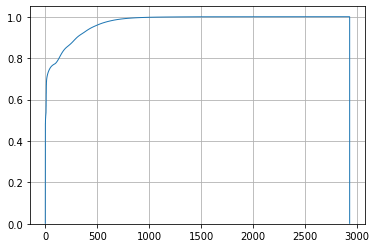

In [119]:
df = pd.concat(usage_cluster_oc10nodes_llf)/1000000
df = pd.Series(df.values.flatten())
df.hist(cumulative=True,histtype='step',bins=10000,density=1)
df.quantile(0.82),df.quantile(0.95)

In [192]:
# usage_cluster_oc10nodes_llf

def compute_default_quotas(usage_cluster, a=0, b=-1):
    

    df = pd.concat(usage_cluster,axis=1)
    min_ts = min(df.index)
    df = df/1000000
    df = df.rolling(5).mean()
    df['ts_abs'] = df.index
    df['ts_abs'] = df['ts_abs'] - min_ts    
    df = df.set_index('ts_abs')
    df = df.iloc[a:b]
    

    columns = ([(int(re.findall("pytorch-classifier-(\d+)-.*",col)[0]),col) for col in df.columns])
    columns.sort(key=lambda tup: tup[1])  # sorts in place
    sorted_columns = ([col for index,col in columns])
    sorted_indices = ([index for index,col in columns])

    
    cluster_size = len([df for df in usage_cluster if df.shape != (0,0) ])
    print("cluster_size", cluster_size)    
    prev_quota = int(12000*cluster_size/len(sorted_columns))
    pods = len(sorted_columns)
    print(pods,"pods",prev_quota,"previous quota")
    

    group_high_count = int(0.2*pods)
    print('group_high pods',group_high_count)

    group_high = sorted_columns[:group_high_count]
    group_low = sorted_columns[group_high_count:]

    quota1 = int(df[group_low].quantile(0.95).sum() / len(group_high))
    quota2 = int(df[group_high].quantile(0.95).sum() / len(group_low))
    quota = int(df.quantile(0.95).sum() / len(sorted_columns))

    print("given two quotas:",quota1, quota2)   
    
    all_quotas = [quota1 if i < group_high_count else quota2 for i in range(pods)] 
    print("total capacity required", sum(all_quotas),"cores", np.ceil(sum(all_quotas)/12000),"nodes")
#     binpacked = (binpacking.to_constant_volume(all_quotas,11800))
    binpacked = (binpacking.to_constant_bin_number(all_quotas,10))

    print(len(binpacked),"nodes")
    for node in binpacked:
        print(sum(node),len(node))
        print(node)

#     (df[sorted_columns].max(axis=0).plot(figsize=(15,5)))
#     plt.show()
    
    return quota, quota1, quota2
    
compute_default_quotas(usage_cluster_oc10nodes_llf)    

cluster_size 10
782 pods 153 previous quota
group_high pods 156
given two quotas: 225 121
total capacity required 110846 cores 10.0 nodes
10 nodes
11102 78
[225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121]
11102 78
[225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121]
11102 78
[225, 225, 225, 225, 225, 225, 225, 225, 225

(142, 225, 121)

In [162]:
compute_default_quotas(usage_cluster_oc10nodes_llf)    

cluster_size 10
782 pods 153 previous quota
group_high pods 156


(142, 225, 121)

In [163]:
compute_default_quotas(usage_cluster_oc10nodes_llf,a=0,b=1000)    

cluster_size 10
782 pods 153 previous quota
group_high pods 156


(138, 212, 120)

In [168]:
compute_default_quotas(usage_cluster_oc10nodes_llf,a=1000,b=2000)    

cluster_size 10
782 pods 153 previous quota
group_high pods 156


(140, 224, 119)

In [ ]:
# usage_cluster_oc10nodes_llf

def compute_default_quotas_v2(usage_cluster, a=0, b=-1):
    

    df = pd.concat(usage_cluster,axis=1)
    min_ts = min(df.index)
    df = df/1000000
    df = df.rolling(5).mean()
    df['ts_abs'] = df.index
    df['ts_abs'] = df['ts_abs'] - min_ts    
    df = df.set_index('ts_abs')
    df = df.iloc[a:b]
    

    columns = ([(int(re.findall("pytorch-classifier-(\d+)-.*",col)[0]),col) for col in df.columns])
    columns.sort(key=lambda tup: tup[1])  # sorts in place
    sorted_columns = ([col for index,col in columns])
    sorted_indices = ([index for index,col in columns])

    
    cluster_size = len([df for df in usage_cluster if df.shape != (0,0) ])
    print("cluster_size", cluster_size)    
    prev_quota = int(12000*cluster_size/len(sorted_columns))
    pods = len(sorted_columns)
    print(pods,"pods",prev_quota,"previous quota")
    

    group_high_count = int(0.2*pods)
    print('group_high pods',group_high_count)

    group_high = sorted_columns[:group_high_count]
    group_low = sorted_columns[group_high_count:]
    
    
    df[group_low].max()

    quota1 = int(df[group_low].quantile(0.95).sum() / len(group_high))
    quota2 = int(df[group_high].quantile(0.95).sum() / len(group_low))
    quota = int(df.quantile(0.95).sum() / len(sorted_columns))

    print("given two quotas:",quota1, quota2)   
    
    all_quotas = [quota1 if i < group_high_count else quota2 for i in range(pods)] 
    print("total capacity required", sum(all_quotas),"cores", np.ceil(sum(all_quotas)/12000),"nodes")
#     binpacked = (binpacking.to_constant_volume(all_quotas,11800))
    binpacked = (binpacking.to_constant_bin_number(all_quotas,10))

    print(len(binpacked),"nodes")
    for node in binpacked:
        print(sum(node),len(node))
        print(node)

#     (df[sorted_columns].max(axis=0).plot(figsize=(15,5)))
#     plt.show()
    
    return quota, quota1, quota2
    
compute_default_quotas(usage_cluster_oc10nodes_llf)    